In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
%cd /content/
!pip install wget
!git clone https://github.com/KKMOfficial/minGPT.git
!pip3 install torch torchvision torchaudio
import wget
test_link = "https://drive.usercontent.google.com/download?id=1vY9l-110dFmbqm2AkRNllqp0MnXJaxH6&export=download&authuser=0&confirm=t&uuid=018afe8b-f360-451b-bac4-f8e714956771&at=APZUnTWO3XNqjvhgXvPBJ6GMkbxT%3A1723832924892"
wget.download(link, out="/content/minGPT/test_trajs.pkl")

train_link = "https://drive.usercontent.google.com/download?id=1tY_DBuZT7XhysO0I11ASW64knTcDVm1P&export=download&authuser=0&confirm=t&uuid=61dc4bed-3d20-4494-9036-f24d24cb66cd&at=APZUnTUIyzkTvbx8uyyv7xllzNDH%3A1724174332424"
wget.download(link, out="/content/minGPT/train_trajs.pkl")

In [ ]:
%cd minGPT
import os
import sys
import json
import pickle
import numpy as np
from math import *
import random

import torch
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt

from mingpt.model import GPT
from mingpt.trainer import Trainer
from mingpt.utils import set_seed, setup_logging, CfgNode as CN

/content/minGPT


In [ ]:
class TrajectoryDataset(Dataset):
    """
    generate sequences of consecutive state-actions in the humanoid environment
    """
    @staticmethod
    def get_default_config(sequence_length=5, traj_addr=None):
        C = CN()
        C.STATE_DIM  = 206
        C.ACTION_DIM = 56
        C.SEQ_LEN    = sequence_length     # 5 (206+56) = 1310 tokens
        C.MIN_RANGE  = -300
        C.MAX_RANGE  = +300
        C.PRECISION  = 1e-2   # 60000 tokens in total
        if not traj_addr is None : C.TRAJ_ADDR=traj_addr
        return C

    def __init__(self, config):
        self.config    = config
        self.traj_list = None
        self.buffer    = []
        self.accum_idx = [ 0 ]
        prep_trajs     = []
        self.encoder   = lambda x: np.floor(((np.round(np.clip(x, a_min=self.config.MIN_RANGE, a_max=self.config.MAX_RANGE), decimals=int(log10(1/self.config.PRECISION)))+300)/\
                                                (self.config.MAX_RANGE-self.config.MIN_RANGE))*self.get_vocab_size()).astype(np.longlong)
        self.decoder   = lambda x: ((x/self.get_vocab_size())*(self.config.MAX_RANGE-self.config.MIN_RANGE))+self.config.MIN_RANGE
        # load trajectory dataset
        with open(self.config.TRAJ_ADDR,"rb") as f: self.traj_list = pickle.load(f)
        # maximum available sample trajectory in each agent trajectory
        for trajectory in self.traj_list :
            if len(trajectory)//2<self.config.SEQ_LEN: continue
            self.buffer     += [ len(trajectory)//2-self.config.SEQ_LEN+1 ]
            self.accum_idx  += [ self.accum_idx[-1] + self.buffer[-1] ]
            # preprocess raw trajectory lists
            prep_trajs += [ np.concatenate(trajectory, axis=1)[0] ]
        # we choose random trajectories then form them when they are needed during the training
        # finding indeces are base on the accumulative index array
        self.accum_idx = np.array(self.accum_idx)[1:]
        # update trajectory list
        self.traj_list = prep_trajs
        self.state_action = self.config.STATE_DIM + self.config.ACTION_DIM

    def get_vocab_size(self):
        # based on range and precision 1d tokens are provided, the semantics for each of these
        # will be learned in the latent space given number of channels
        return int(1+(self.config.MAX_RANGE-self.config.MIN_RANGE)/self.config.PRECISION)

    def get_block_size(self):
        # a simple shifted SEQ_LEN block of state actions
        return self.config.SEQ_LEN * (self.config.STATE_DIM + self.config.ACTION_DIM)

    def __len__(self):
        # total number of the data inside the dataset!
        return self.accum_idx[-1]

    def __getitem__(self, idx):
        # form sample
        traj_index  = np.where(self.accum_idx > idx)[0][0]
        slice_index = idx - (self.accum_idx[traj_index-1] if traj_index>0 else 0)
        # form input domain element
        trajectory  = self.encoder(self.traj_list[traj_index][slice_index*self.state_action:1+(slice_index+self.config.SEQ_LEN)*self.state_action])
        x = torch.tensor(trajectory[0:self.config.SEQ_LEN*(self.config.STATE_DIM+self.config.ACTION_DIM)], dtype=torch.long)
        # form output domain element
        y = torch.tensor(trajectory[1:1+self.config.SEQ_LEN*(self.config.STATE_DIM+self.config.ACTION_DIM)], dtype=torch.long)
        return x, y

In [ ]:
def get_config():

    C = CN()

    # device
    C.device = 'cuda'

    # system
    C.system = CN()
    C.system.seed = 3407
    C.system.work_dir = './out/dynamic'

    # data
    C.data = TrajectoryDataset.get_default_config()
    C.data.TRAJ_ADDR = '/content/drive/MyDrive/trajs.pkl'

    # model
    C.model = GPT.get_default_config()
    C.model.model_type = 'gpt-nano'

    # trainer
    C.trainer = Trainer.get_default_config()
    C.trainer.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster


    return C

device: cuda
system:
    seed: 3407
    work_dir: ./out/dynamic
data:
    STATE_DIM: 206
    ACTION_DIM: 56
    SEQ_LEN: 5
    MIN_RANGE: -300
    MAX_RANGE: 300
    PRECISION: 0.01
    TRAJ_ADDR: /content/drive/MyDrive/trajs.pkl
model:
    model_type: gpt-nano
    n_layer: None
    n_head: None
    n_embd: None
    vocab_size: 60001
    block_size: 1310
    embd_pdrop: 0.1
    resid_pdrop: 0.1
    attn_pdrop: 0.1
trainer:
    device: cuda
    num_workers: 4
    max_iters: None
    batch_size: 2
    learning_rate: 0.0005
    betas: (0.9, 0.95)
    weight_decay: 0.1
    grad_norm_clip: 1.0

number of parameters: 3.03M
running on device cuda
iter_dt 0.00ms; iter 0: train loss 11.00653


100%|██████████| 2302/2302 [00:16<00:00, 140.98it/s]


saving model
iter_dt 66.66ms; iter 10: train loss 10.64726
iter_dt 67.21ms; iter 20: train loss 10.22747
iter_dt 67.71ms; iter 30: train loss 9.75097
iter_dt 65.23ms; iter 40: train loss 9.26043
iter_dt 67.02ms; iter 50: train loss 8.82083
iter_dt 67.00ms; iter 60: train loss 8.38642
iter_dt 67.08ms; iter 70: train loss 7.86601
iter_dt 66.61ms; iter 80: train loss 7.51214
iter_dt 66.50ms; iter 90: train loss 7.14996
iter_dt 69.10ms; iter 100: train loss 6.67921
iter_dt 63.72ms; iter 110: train loss 6.30094
iter_dt 66.73ms; iter 120: train loss 6.26165
iter_dt 66.33ms; iter 130: train loss 5.99902
iter_dt 68.34ms; iter 140: train loss 5.79746
iter_dt 68.94ms; iter 150: train loss 5.80340
iter_dt 68.69ms; iter 160: train loss 5.39833
iter_dt 67.46ms; iter 170: train loss 5.61566
iter_dt 66.91ms; iter 180: train loss 5.37990
iter_dt 62.65ms; iter 190: train loss 5.37561
iter_dt 68.24ms; iter 200: train loss 5.51469
iter_dt 67.96ms; iter 210: train loss 5.47527
iter_dt 66.71ms; iter 220: t

100%|██████████| 2302/2302 [00:16<00:00, 138.23it/s]


saving model
iter_dt 66.42ms; iter 510: train loss 4.64470
iter_dt 66.59ms; iter 520: train loss 4.61954
iter_dt 66.59ms; iter 530: train loss 4.70751
iter_dt 66.54ms; iter 540: train loss 4.43570
iter_dt 67.39ms; iter 550: train loss 4.45335
iter_dt 66.86ms; iter 560: train loss 4.57629
iter_dt 67.09ms; iter 570: train loss 4.63517
iter_dt 66.90ms; iter 580: train loss 4.62322
iter_dt 66.91ms; iter 590: train loss 4.50085
iter_dt 69.87ms; iter 600: train loss 4.61084
iter_dt 70.06ms; iter 610: train loss 4.45595
iter_dt 67.51ms; iter 620: train loss 4.36391
iter_dt 70.41ms; iter 630: train loss 4.68131
iter_dt 66.62ms; iter 640: train loss 4.63806
iter_dt 66.11ms; iter 650: train loss 4.61291
iter_dt 63.87ms; iter 660: train loss 4.69646
iter_dt 69.54ms; iter 670: train loss 4.52328
iter_dt 67.22ms; iter 680: train loss 4.44236
iter_dt 66.60ms; iter 690: train loss 4.38951
iter_dt 67.27ms; iter 700: train loss 4.60141
iter_dt 66.85ms; iter 710: train loss 4.26388
iter_dt 66.65ms; iter

100%|██████████| 2302/2302 [00:16<00:00, 136.47it/s]


saving model
iter_dt 67.63ms; iter 1010: train loss 4.14021
iter_dt 67.24ms; iter 1020: train loss 4.53490
iter_dt 65.67ms; iter 1030: train loss 4.39886
iter_dt 66.20ms; iter 1040: train loss 4.84940
iter_dt 66.24ms; iter 1050: train loss 4.55985
iter_dt 66.13ms; iter 1060: train loss 4.62307
iter_dt 67.63ms; iter 1070: train loss 4.06378
iter_dt 66.26ms; iter 1080: train loss 4.69200
iter_dt 67.05ms; iter 1090: train loss 4.62596
iter_dt 68.06ms; iter 1100: train loss 4.56410
iter_dt 67.52ms; iter 1110: train loss 4.17313
iter_dt 67.01ms; iter 1120: train loss 4.14514
iter_dt 72.18ms; iter 1130: train loss 4.40772
iter_dt 65.39ms; iter 1140: train loss 4.59723
iter_dt 68.65ms; iter 1150: train loss 4.10911
iter_dt 66.11ms; iter 1160: train loss 4.45196
iter_dt 69.38ms; iter 1170: train loss 4.18852
iter_dt 70.04ms; iter 1180: train loss 4.40977
iter_dt 60.77ms; iter 1190: train loss 4.59247
iter_dt 66.72ms; iter 1200: train loss 4.35377
iter_dt 66.37ms; iter 1210: train loss 3.97167


100%|██████████| 2302/2302 [00:16<00:00, 139.15it/s]


saving model
iter_dt 71.58ms; iter 1510: train loss 4.60139
iter_dt 58.34ms; iter 1520: train loss 4.11259
iter_dt 66.49ms; iter 1530: train loss 4.27016
iter_dt 66.89ms; iter 1540: train loss 4.42163
iter_dt 67.28ms; iter 1550: train loss 4.33770
iter_dt 65.77ms; iter 1560: train loss 4.10294
iter_dt 68.09ms; iter 1570: train loss 4.36027
iter_dt 67.37ms; iter 1580: train loss 4.43162
iter_dt 66.85ms; iter 1590: train loss 4.42186
iter_dt 66.46ms; iter 1600: train loss 4.25451
iter_dt 66.82ms; iter 1610: train loss 4.04406
iter_dt 67.25ms; iter 1620: train loss 4.50379
iter_dt 66.30ms; iter 1630: train loss 4.32562
iter_dt 69.64ms; iter 1640: train loss 4.66001
iter_dt 60.76ms; iter 1650: train loss 4.63738
iter_dt 66.72ms; iter 1660: train loss 4.28680
iter_dt 68.32ms; iter 1670: train loss 4.25317
iter_dt 70.83ms; iter 1680: train loss 4.47376
iter_dt 66.08ms; iter 1690: train loss 4.45505
iter_dt 70.43ms; iter 1700: train loss 4.49456
iter_dt 65.95ms; iter 1710: train loss 4.39227


100%|██████████| 2302/2302 [00:16<00:00, 141.60it/s]


saving model
iter_dt 66.79ms; iter 2010: train loss 4.18881
iter_dt 65.38ms; iter 2020: train loss 4.07290
iter_dt 66.33ms; iter 2030: train loss 4.22686
iter_dt 64.45ms; iter 2040: train loss 4.16223
iter_dt 57.74ms; iter 2050: train loss 4.16469
iter_dt 70.60ms; iter 2060: train loss 4.58192
iter_dt 67.20ms; iter 2070: train loss 4.37337
iter_dt 66.82ms; iter 2080: train loss 4.51904
iter_dt 67.75ms; iter 2090: train loss 4.29327
iter_dt 67.83ms; iter 2100: train loss 3.84869
iter_dt 70.40ms; iter 2110: train loss 4.48885
iter_dt 68.02ms; iter 2120: train loss 3.87071
iter_dt 65.15ms; iter 2130: train loss 4.29399
iter_dt 67.53ms; iter 2140: train loss 4.16174
iter_dt 67.10ms; iter 2150: train loss 4.44700
iter_dt 67.72ms; iter 2160: train loss 4.00229
iter_dt 69.93ms; iter 2170: train loss 4.19470
iter_dt 67.53ms; iter 2180: train loss 4.28170
iter_dt 67.08ms; iter 2190: train loss 4.10325
iter_dt 64.16ms; iter 2200: train loss 4.34089
iter_dt 67.21ms; iter 2210: train loss 4.13338


100%|██████████| 2302/2302 [00:16<00:00, 141.57it/s]


saving model
iter_dt 62.78ms; iter 2510: train loss 4.34046
iter_dt 67.74ms; iter 2520: train loss 4.13624
iter_dt 65.40ms; iter 2530: train loss 4.45798
iter_dt 66.12ms; iter 2540: train loss 4.27514
iter_dt 67.37ms; iter 2550: train loss 4.11175
iter_dt 62.35ms; iter 2560: train loss 4.09454
iter_dt 66.55ms; iter 2570: train loss 4.28396
iter_dt 65.96ms; iter 2580: train loss 4.12240
iter_dt 66.69ms; iter 2590: train loss 4.29612
iter_dt 66.03ms; iter 2600: train loss 4.24261
iter_dt 65.54ms; iter 2610: train loss 4.11604
iter_dt 67.14ms; iter 2620: train loss 4.37162
iter_dt 68.86ms; iter 2630: train loss 4.07061
iter_dt 66.64ms; iter 2640: train loss 4.13776
iter_dt 65.55ms; iter 2650: train loss 4.32056
iter_dt 66.49ms; iter 2660: train loss 4.43665
iter_dt 66.28ms; iter 2670: train loss 4.22758
iter_dt 66.31ms; iter 2680: train loss 4.54938
iter_dt 68.08ms; iter 2690: train loss 4.12130
iter_dt 69.18ms; iter 2700: train loss 4.26948
iter_dt 71.36ms; iter 2710: train loss 3.84434


100%|██████████| 2302/2302 [00:16<00:00, 142.02it/s]


saving model
iter_dt 66.46ms; iter 3010: train loss 4.19253
iter_dt 66.45ms; iter 3020: train loss 4.23887
iter_dt 67.41ms; iter 3030: train loss 4.11217
iter_dt 64.10ms; iter 3040: train loss 3.97305
iter_dt 66.39ms; iter 3050: train loss 4.38436
iter_dt 68.25ms; iter 3060: train loss 4.51902
iter_dt 69.68ms; iter 3070: train loss 4.27760
iter_dt 64.61ms; iter 3080: train loss 4.42391
iter_dt 66.06ms; iter 3090: train loss 4.42987
iter_dt 68.05ms; iter 3100: train loss 4.16893
iter_dt 73.29ms; iter 3110: train loss 4.17394
iter_dt 67.27ms; iter 3120: train loss 4.20905
iter_dt 66.25ms; iter 3130: train loss 4.33909
iter_dt 67.39ms; iter 3140: train loss 4.31824
iter_dt 66.12ms; iter 3150: train loss 4.45104
iter_dt 66.25ms; iter 3160: train loss 4.09837
iter_dt 65.02ms; iter 3170: train loss 4.28994
iter_dt 68.02ms; iter 3180: train loss 4.14825
iter_dt 67.97ms; iter 3190: train loss 4.31213
iter_dt 65.62ms; iter 3200: train loss 4.21123
iter_dt 66.12ms; iter 3210: train loss 4.45211


100%|██████████| 2302/2302 [00:16<00:00, 142.50it/s]


saving model
iter_dt 65.22ms; iter 3510: train loss 3.98709
iter_dt 66.48ms; iter 3520: train loss 4.41587
iter_dt 67.85ms; iter 3530: train loss 4.39078
iter_dt 72.37ms; iter 3540: train loss 4.33999
iter_dt 67.19ms; iter 3550: train loss 4.12332
iter_dt 67.86ms; iter 3560: train loss 4.04886
iter_dt 66.44ms; iter 3570: train loss 4.07935
iter_dt 66.23ms; iter 3580: train loss 4.44264
iter_dt 67.99ms; iter 3590: train loss 4.25044
iter_dt 66.76ms; iter 3600: train loss 4.09647
iter_dt 67.04ms; iter 3610: train loss 4.57494
iter_dt 68.50ms; iter 3620: train loss 4.05563
iter_dt 67.40ms; iter 3630: train loss 3.98029
iter_dt 67.79ms; iter 3640: train loss 3.95611
iter_dt 66.81ms; iter 3650: train loss 4.34578
iter_dt 68.15ms; iter 3660: train loss 4.17131
iter_dt 68.74ms; iter 3670: train loss 4.04638
iter_dt 66.47ms; iter 3680: train loss 3.64756
iter_dt 67.52ms; iter 3690: train loss 4.17556
iter_dt 67.51ms; iter 3700: train loss 3.82383
iter_dt 65.39ms; iter 3710: train loss 3.67774


100%|██████████| 2302/2302 [00:16<00:00, 141.11it/s]


saving model
iter_dt 65.49ms; iter 4010: train loss 4.17319
iter_dt 66.17ms; iter 4020: train loss 4.17990
iter_dt 67.74ms; iter 4030: train loss 4.29695
iter_dt 64.51ms; iter 4040: train loss 4.09889
iter_dt 60.28ms; iter 4050: train loss 3.68792
iter_dt 67.86ms; iter 4060: train loss 4.20022
iter_dt 67.56ms; iter 4070: train loss 4.06498
iter_dt 67.09ms; iter 4080: train loss 4.27333
iter_dt 66.55ms; iter 4090: train loss 4.22096
iter_dt 68.14ms; iter 4100: train loss 4.12624
iter_dt 68.26ms; iter 4110: train loss 4.16555
iter_dt 65.68ms; iter 4120: train loss 4.15746
iter_dt 66.43ms; iter 4130: train loss 4.23847
iter_dt 70.33ms; iter 4140: train loss 4.16168
iter_dt 65.39ms; iter 4150: train loss 3.91956
iter_dt 66.56ms; iter 4160: train loss 4.23277
iter_dt 65.61ms; iter 4170: train loss 3.99125
iter_dt 67.92ms; iter 4180: train loss 4.35685
iter_dt 66.86ms; iter 4190: train loss 4.11912
iter_dt 60.52ms; iter 4200: train loss 4.41469
iter_dt 66.21ms; iter 4210: train loss 4.20061


100%|██████████| 2302/2302 [00:16<00:00, 138.00it/s]


saving model
iter_dt 67.63ms; iter 4510: train loss 4.08610
iter_dt 68.02ms; iter 4520: train loss 4.18950
iter_dt 66.23ms; iter 4530: train loss 3.71788
iter_dt 65.76ms; iter 4540: train loss 4.33964
iter_dt 66.61ms; iter 4550: train loss 4.28043
iter_dt 67.27ms; iter 4560: train loss 3.88681
iter_dt 67.74ms; iter 4570: train loss 4.11845
iter_dt 67.14ms; iter 4580: train loss 4.04167
iter_dt 66.76ms; iter 4590: train loss 4.57232
iter_dt 66.24ms; iter 4600: train loss 4.23423
iter_dt 66.90ms; iter 4610: train loss 3.70229
iter_dt 67.85ms; iter 4620: train loss 4.11164
iter_dt 68.63ms; iter 4630: train loss 4.60358
iter_dt 63.02ms; iter 4640: train loss 3.85684
iter_dt 67.26ms; iter 4650: train loss 4.32470
iter_dt 67.29ms; iter 4660: train loss 4.08091
iter_dt 62.49ms; iter 4670: train loss 4.47358
iter_dt 68.35ms; iter 4680: train loss 4.29978
iter_dt 67.32ms; iter 4690: train loss 4.33041
iter_dt 65.76ms; iter 4700: train loss 3.99656
iter_dt 67.32ms; iter 4710: train loss 4.26056


100%|██████████| 2302/2302 [00:16<00:00, 136.79it/s]


saving model
iter_dt 67.24ms; iter 5010: train loss 4.18076
iter_dt 66.28ms; iter 5020: train loss 4.27244
iter_dt 68.20ms; iter 5030: train loss 4.02461
iter_dt 66.63ms; iter 5040: train loss 4.22857
iter_dt 66.34ms; iter 5050: train loss 3.94239
iter_dt 66.77ms; iter 5060: train loss 4.15706
iter_dt 66.33ms; iter 5070: train loss 4.34178
iter_dt 67.11ms; iter 5080: train loss 4.08584
iter_dt 70.85ms; iter 5090: train loss 4.07636
iter_dt 63.59ms; iter 5100: train loss 4.37861
iter_dt 66.31ms; iter 5110: train loss 4.07609
iter_dt 65.87ms; iter 5120: train loss 3.96696
iter_dt 66.72ms; iter 5130: train loss 3.84061
iter_dt 69.10ms; iter 5140: train loss 4.10488
iter_dt 68.25ms; iter 5150: train loss 4.13019
iter_dt 66.74ms; iter 5160: train loss 4.38476
iter_dt 69.88ms; iter 5170: train loss 4.14875
iter_dt 61.25ms; iter 5180: train loss 4.21957
iter_dt 69.90ms; iter 5190: train loss 3.92413
iter_dt 67.25ms; iter 5200: train loss 3.91360
iter_dt 66.50ms; iter 5210: train loss 4.08771


100%|██████████| 2302/2302 [00:16<00:00, 138.43it/s]


saving model
iter_dt 66.88ms; iter 5510: train loss 4.26722
iter_dt 67.17ms; iter 5520: train loss 4.03580
iter_dt 63.87ms; iter 5530: train loss 4.00885
iter_dt 67.13ms; iter 5540: train loss 4.02131
iter_dt 67.97ms; iter 5550: train loss 3.79353
iter_dt 67.40ms; iter 5560: train loss 4.22896
iter_dt 66.39ms; iter 5570: train loss 4.36009
iter_dt 66.53ms; iter 5580: train loss 4.27424
iter_dt 67.16ms; iter 5590: train loss 4.04998
iter_dt 64.50ms; iter 5600: train loss 4.13767
iter_dt 65.79ms; iter 5610: train loss 4.08576
iter_dt 67.60ms; iter 5620: train loss 4.23459
iter_dt 67.22ms; iter 5630: train loss 4.17368
iter_dt 65.77ms; iter 5640: train loss 3.91972
iter_dt 66.42ms; iter 5650: train loss 4.03735
iter_dt 65.79ms; iter 5660: train loss 3.97334
iter_dt 71.01ms; iter 5670: train loss 4.06577
iter_dt 66.84ms; iter 5680: train loss 3.71760
iter_dt 65.88ms; iter 5690: train loss 4.11437
iter_dt 63.51ms; iter 5700: train loss 4.53180
iter_dt 66.85ms; iter 5710: train loss 4.05689


100%|██████████| 2302/2302 [00:16<00:00, 140.39it/s]


saving model
iter_dt 71.04ms; iter 6010: train loss 3.90945
iter_dt 65.21ms; iter 6020: train loss 4.01563
iter_dt 66.91ms; iter 6030: train loss 4.34702
iter_dt 65.32ms; iter 6040: train loss 3.95006
iter_dt 72.50ms; iter 6050: train loss 4.12224
iter_dt 65.97ms; iter 6060: train loss 4.01276
iter_dt 67.45ms; iter 6070: train loss 3.84145
iter_dt 67.18ms; iter 6080: train loss 4.39864
iter_dt 67.76ms; iter 6090: train loss 4.32190
iter_dt 67.34ms; iter 6100: train loss 4.27876
iter_dt 66.94ms; iter 6110: train loss 4.00249
iter_dt 66.75ms; iter 6120: train loss 4.12551
iter_dt 65.63ms; iter 6130: train loss 4.09804
iter_dt 66.25ms; iter 6140: train loss 3.98252
iter_dt 65.24ms; iter 6150: train loss 4.28616
iter_dt 66.48ms; iter 6160: train loss 3.93180
iter_dt 66.54ms; iter 6170: train loss 4.09479
iter_dt 67.91ms; iter 6180: train loss 4.16054
iter_dt 67.97ms; iter 6190: train loss 3.82831
iter_dt 68.91ms; iter 6200: train loss 4.30727
iter_dt 66.16ms; iter 6210: train loss 3.99452


100%|██████████| 2302/2302 [00:16<00:00, 142.66it/s]


saving model
iter_dt 65.47ms; iter 6510: train loss 4.00752
iter_dt 66.90ms; iter 6520: train loss 3.72133
iter_dt 67.24ms; iter 6530: train loss 4.18400
iter_dt 67.63ms; iter 6540: train loss 3.91500
iter_dt 66.27ms; iter 6550: train loss 4.08657
iter_dt 65.50ms; iter 6560: train loss 4.08634
iter_dt 67.22ms; iter 6570: train loss 4.43967
iter_dt 67.34ms; iter 6580: train loss 4.10468
iter_dt 65.21ms; iter 6590: train loss 4.32997
iter_dt 66.11ms; iter 6600: train loss 4.11763
iter_dt 65.67ms; iter 6610: train loss 3.98272
iter_dt 69.79ms; iter 6620: train loss 4.44760
iter_dt 67.61ms; iter 6630: train loss 4.22590
iter_dt 65.52ms; iter 6640: train loss 4.31690
iter_dt 67.47ms; iter 6650: train loss 4.09713
iter_dt 66.56ms; iter 6660: train loss 3.99398
iter_dt 64.41ms; iter 6670: train loss 4.14343
iter_dt 67.01ms; iter 6680: train loss 4.20997
iter_dt 66.07ms; iter 6690: train loss 4.13122
iter_dt 63.49ms; iter 6700: train loss 3.88874
iter_dt 69.31ms; iter 6710: train loss 4.05338


100%|██████████| 2302/2302 [00:16<00:00, 142.75it/s]


saving model
iter_dt 66.11ms; iter 7010: train loss 3.95169
iter_dt 67.51ms; iter 7020: train loss 4.14875
iter_dt 73.03ms; iter 7030: train loss 3.82397
iter_dt 67.35ms; iter 7040: train loss 3.96843
iter_dt 67.45ms; iter 7050: train loss 3.91694
iter_dt 67.25ms; iter 7060: train loss 3.96083
iter_dt 70.41ms; iter 7070: train loss 3.96529
iter_dt 66.87ms; iter 7080: train loss 4.10923
iter_dt 67.53ms; iter 7090: train loss 4.17884
iter_dt 72.46ms; iter 7100: train loss 4.01203
iter_dt 69.21ms; iter 7110: train loss 4.33898
iter_dt 65.85ms; iter 7120: train loss 3.96325
iter_dt 64.51ms; iter 7130: train loss 4.03237
iter_dt 66.80ms; iter 7140: train loss 3.52067
iter_dt 65.33ms; iter 7150: train loss 4.28215
iter_dt 67.59ms; iter 7160: train loss 3.73310
iter_dt 66.58ms; iter 7170: train loss 3.75073
iter_dt 68.08ms; iter 7180: train loss 3.79001
iter_dt 66.46ms; iter 7190: train loss 3.94741
iter_dt 66.80ms; iter 7200: train loss 4.11872
iter_dt 66.00ms; iter 7210: train loss 4.10147


100%|██████████| 2302/2302 [00:16<00:00, 143.07it/s]


saving model
iter_dt 67.09ms; iter 7510: train loss 4.13602
iter_dt 66.57ms; iter 7520: train loss 3.79390
iter_dt 66.12ms; iter 7530: train loss 3.98929
iter_dt 66.39ms; iter 7540: train loss 4.43214
iter_dt 67.09ms; iter 7550: train loss 3.66220
iter_dt 63.98ms; iter 7560: train loss 3.92635
iter_dt 67.12ms; iter 7570: train loss 4.08426
iter_dt 66.11ms; iter 7580: train loss 3.73293
iter_dt 67.43ms; iter 7590: train loss 4.05614
iter_dt 67.54ms; iter 7600: train loss 3.97335
iter_dt 63.76ms; iter 7610: train loss 3.86807
iter_dt 67.87ms; iter 7620: train loss 4.20793
iter_dt 68.04ms; iter 7630: train loss 3.82510
iter_dt 64.30ms; iter 7640: train loss 4.29784
iter_dt 67.19ms; iter 7650: train loss 3.47571
iter_dt 66.23ms; iter 7660: train loss 4.13197
iter_dt 68.17ms; iter 7670: train loss 4.18209
iter_dt 66.50ms; iter 7680: train loss 3.94162
iter_dt 66.18ms; iter 7690: train loss 3.89772
iter_dt 68.25ms; iter 7700: train loss 4.22200
iter_dt 66.84ms; iter 7710: train loss 3.93681


100%|██████████| 2302/2302 [00:16<00:00, 139.63it/s]


saving model
iter_dt 65.19ms; iter 8010: train loss 4.22647
iter_dt 66.81ms; iter 8020: train loss 3.78431
iter_dt 66.46ms; iter 8030: train loss 3.83840
iter_dt 66.34ms; iter 8040: train loss 3.83503
iter_dt 65.62ms; iter 8050: train loss 3.98313
iter_dt 65.95ms; iter 8060: train loss 4.05582
iter_dt 67.14ms; iter 8070: train loss 4.26521
iter_dt 66.95ms; iter 8080: train loss 3.99536
iter_dt 66.76ms; iter 8090: train loss 4.02200
iter_dt 68.35ms; iter 8100: train loss 4.02663
iter_dt 64.74ms; iter 8110: train loss 4.11016
iter_dt 66.23ms; iter 8120: train loss 4.09357
iter_dt 72.86ms; iter 8130: train loss 3.77759
iter_dt 62.43ms; iter 8140: train loss 4.02022
iter_dt 66.52ms; iter 8150: train loss 3.98465
iter_dt 66.23ms; iter 8160: train loss 4.26955
iter_dt 66.17ms; iter 8170: train loss 4.17512
iter_dt 66.08ms; iter 8180: train loss 3.87715
iter_dt 66.51ms; iter 8190: train loss 3.82334
iter_dt 66.11ms; iter 8200: train loss 3.87320
iter_dt 66.16ms; iter 8210: train loss 3.76107


100%|██████████| 2302/2302 [00:16<00:00, 138.01it/s]


saving model
iter_dt 67.18ms; iter 8510: train loss 3.94179
iter_dt 64.67ms; iter 8520: train loss 4.06158
iter_dt 66.78ms; iter 8530: train loss 3.82526
iter_dt 66.96ms; iter 8540: train loss 4.11040
iter_dt 66.24ms; iter 8550: train loss 3.88396
iter_dt 65.74ms; iter 8560: train loss 3.99975
iter_dt 66.77ms; iter 8570: train loss 4.09263
iter_dt 67.11ms; iter 8580: train loss 3.99020
iter_dt 66.59ms; iter 8590: train loss 3.87252
iter_dt 66.93ms; iter 8600: train loss 4.01706
iter_dt 69.13ms; iter 8610: train loss 3.97797
iter_dt 67.23ms; iter 8620: train loss 4.03699
iter_dt 69.93ms; iter 8630: train loss 3.89052
iter_dt 67.16ms; iter 8640: train loss 4.26106
iter_dt 66.82ms; iter 8650: train loss 3.94759
iter_dt 65.67ms; iter 8660: train loss 3.70852
iter_dt 71.21ms; iter 8670: train loss 3.88124
iter_dt 67.45ms; iter 8680: train loss 3.73610
iter_dt 61.01ms; iter 8690: train loss 3.95021
iter_dt 67.69ms; iter 8700: train loss 3.79769
iter_dt 68.82ms; iter 8710: train loss 4.12362


100%|██████████| 2302/2302 [00:16<00:00, 137.34it/s]


saving model
iter_dt 66.00ms; iter 9010: train loss 3.88937
iter_dt 67.36ms; iter 9020: train loss 4.25163
iter_dt 67.76ms; iter 9030: train loss 4.00329
iter_dt 67.76ms; iter 9040: train loss 4.13290
iter_dt 69.13ms; iter 9050: train loss 3.97403
iter_dt 66.23ms; iter 9060: train loss 3.99130
iter_dt 65.96ms; iter 9070: train loss 4.01364
iter_dt 65.89ms; iter 9080: train loss 3.71550
iter_dt 66.53ms; iter 9090: train loss 3.84793
iter_dt 65.08ms; iter 9100: train loss 3.84512
iter_dt 67.49ms; iter 9110: train loss 4.07765
iter_dt 66.50ms; iter 9120: train loss 3.96767
iter_dt 67.05ms; iter 9130: train loss 3.85332
iter_dt 66.34ms; iter 9140: train loss 4.21794
iter_dt 64.96ms; iter 9150: train loss 3.97404
iter_dt 66.69ms; iter 9160: train loss 3.71172
iter_dt 59.91ms; iter 9170: train loss 3.95126
iter_dt 66.80ms; iter 9180: train loss 4.05578
iter_dt 64.94ms; iter 9190: train loss 3.97309
iter_dt 66.66ms; iter 9200: train loss 3.93574
iter_dt 66.98ms; iter 9210: train loss 4.01578


100%|██████████| 2302/2302 [00:16<00:00, 140.83it/s]


saving model
iter_dt 72.31ms; iter 9510: train loss 3.71858
iter_dt 65.89ms; iter 9520: train loss 3.91993
iter_dt 68.37ms; iter 9530: train loss 4.22973
iter_dt 66.88ms; iter 9540: train loss 4.06578
iter_dt 67.42ms; iter 9550: train loss 4.25553
iter_dt 67.22ms; iter 9560: train loss 4.28507
iter_dt 67.55ms; iter 9570: train loss 3.54755
iter_dt 66.82ms; iter 9580: train loss 3.70627
iter_dt 67.96ms; iter 9590: train loss 4.05890
iter_dt 66.60ms; iter 9600: train loss 3.90324
iter_dt 65.93ms; iter 9610: train loss 4.03341
iter_dt 67.54ms; iter 9620: train loss 3.29839
iter_dt 68.36ms; iter 9630: train loss 3.87889
iter_dt 65.88ms; iter 9640: train loss 3.90969
iter_dt 67.10ms; iter 9650: train loss 3.99885
iter_dt 65.36ms; iter 9660: train loss 3.65944
iter_dt 65.24ms; iter 9670: train loss 4.10066
iter_dt 67.58ms; iter 9680: train loss 4.06498
iter_dt 64.45ms; iter 9690: train loss 4.08047
iter_dt 67.03ms; iter 9700: train loss 4.08568
iter_dt 67.44ms; iter 9710: train loss 3.92775


100%|██████████| 2302/2302 [00:16<00:00, 142.24it/s]
<ipython-input-8-8274910789e8>:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8, 6))


saving model
iter_dt 66.59ms; iter 10010: train loss 3.86896
iter_dt 68.35ms; iter 10020: train loss 4.00848
iter_dt 66.64ms; iter 10030: train loss 3.90704
iter_dt 65.08ms; iter 10040: train loss 3.94006
iter_dt 66.81ms; iter 10050: train loss 3.84411
iter_dt 73.11ms; iter 10060: train loss 3.75021
iter_dt 62.23ms; iter 10070: train loss 4.01346
iter_dt 64.92ms; iter 10080: train loss 3.99716
iter_dt 65.73ms; iter 10090: train loss 4.20397
iter_dt 66.06ms; iter 10100: train loss 3.97390
iter_dt 68.00ms; iter 10110: train loss 3.78194
iter_dt 67.72ms; iter 10120: train loss 3.76566
iter_dt 77.63ms; iter 10130: train loss 3.83229
iter_dt 66.99ms; iter 10140: train loss 4.18728
iter_dt 65.74ms; iter 10150: train loss 4.00291
iter_dt 67.78ms; iter 10160: train loss 3.50726
iter_dt 66.26ms; iter 10170: train loss 3.81196
iter_dt 66.66ms; iter 10180: train loss 3.85971
iter_dt 66.91ms; iter 10190: train loss 3.90209
iter_dt 62.39ms; iter 10200: train loss 4.17851
iter_dt 70.04ms; iter 10210

100%|██████████| 2302/2302 [00:16<00:00, 142.70it/s]


saving model
iter_dt 67.61ms; iter 10510: train loss 3.91446
iter_dt 67.00ms; iter 10520: train loss 4.23257
iter_dt 67.73ms; iter 10530: train loss 3.89923
iter_dt 68.28ms; iter 10540: train loss 4.04379
iter_dt 66.30ms; iter 10550: train loss 3.89757
iter_dt 66.19ms; iter 10560: train loss 3.58759
iter_dt 67.91ms; iter 10570: train loss 3.92968
iter_dt 67.04ms; iter 10580: train loss 4.03480
iter_dt 66.06ms; iter 10590: train loss 3.65651
iter_dt 66.84ms; iter 10600: train loss 3.98212
iter_dt 67.27ms; iter 10610: train loss 4.04192
iter_dt 61.52ms; iter 10620: train loss 3.77075
iter_dt 66.85ms; iter 10630: train loss 4.19322
iter_dt 67.09ms; iter 10640: train loss 3.72964
iter_dt 66.59ms; iter 10650: train loss 4.24117
iter_dt 66.61ms; iter 10660: train loss 3.83696
iter_dt 67.24ms; iter 10670: train loss 3.92682
iter_dt 73.40ms; iter 10680: train loss 4.02859
iter_dt 66.05ms; iter 10690: train loss 3.34241
iter_dt 66.09ms; iter 10700: train loss 4.07165
iter_dt 68.83ms; iter 10710

100%|██████████| 2302/2302 [00:16<00:00, 142.71it/s]


saving model
iter_dt 67.18ms; iter 11010: train loss 3.91237
iter_dt 67.46ms; iter 11020: train loss 3.78634
iter_dt 66.58ms; iter 11030: train loss 3.75202
iter_dt 67.04ms; iter 11040: train loss 4.05692
iter_dt 60.10ms; iter 11050: train loss 4.17332
iter_dt 65.65ms; iter 11060: train loss 3.81681
iter_dt 66.19ms; iter 11070: train loss 4.13960
iter_dt 66.88ms; iter 11080: train loss 3.49519
iter_dt 66.26ms; iter 11090: train loss 3.75137
iter_dt 65.48ms; iter 11100: train loss 3.79579
iter_dt 66.09ms; iter 11110: train loss 3.81601
iter_dt 66.49ms; iter 11120: train loss 3.93127
iter_dt 68.34ms; iter 11130: train loss 3.67965
iter_dt 66.24ms; iter 11140: train loss 3.59724
iter_dt 66.25ms; iter 11150: train loss 3.98954
iter_dt 65.21ms; iter 11160: train loss 3.84867
iter_dt 66.35ms; iter 11170: train loss 4.22539
iter_dt 66.67ms; iter 11180: train loss 3.66022
iter_dt 67.43ms; iter 11190: train loss 3.98320
iter_dt 66.30ms; iter 11200: train loss 3.88914
iter_dt 66.62ms; iter 11210

100%|██████████| 2302/2302 [00:16<00:00, 142.82it/s]


saving model
iter_dt 67.20ms; iter 11510: train loss 3.65314
iter_dt 66.15ms; iter 11520: train loss 4.01845
iter_dt 65.07ms; iter 11530: train loss 3.77485
iter_dt 67.68ms; iter 11540: train loss 3.85064
iter_dt 65.29ms; iter 11550: train loss 4.11823
iter_dt 67.35ms; iter 11560: train loss 3.90354
iter_dt 67.74ms; iter 11570: train loss 4.08155
iter_dt 67.96ms; iter 11580: train loss 4.02939
iter_dt 65.43ms; iter 11590: train loss 3.72748
iter_dt 68.35ms; iter 11600: train loss 3.98619
iter_dt 67.98ms; iter 11610: train loss 4.10875
iter_dt 69.00ms; iter 11620: train loss 4.28447
iter_dt 68.01ms; iter 11630: train loss 4.05995
iter_dt 65.39ms; iter 11640: train loss 3.81306
iter_dt 72.54ms; iter 11650: train loss 4.06880
iter_dt 61.17ms; iter 11660: train loss 4.09273
iter_dt 66.70ms; iter 11670: train loss 3.78892
iter_dt 67.46ms; iter 11680: train loss 4.00225
iter_dt 67.23ms; iter 11690: train loss 4.02296
iter_dt 73.10ms; iter 11700: train loss 3.80620
iter_dt 67.31ms; iter 11710

100%|██████████| 2302/2302 [00:16<00:00, 139.19it/s]


saving model
iter_dt 66.38ms; iter 12010: train loss 4.02355
iter_dt 61.20ms; iter 12020: train loss 3.81297
iter_dt 65.39ms; iter 12030: train loss 3.82549
iter_dt 66.08ms; iter 12040: train loss 4.01512
iter_dt 66.60ms; iter 12050: train loss 3.84960
iter_dt 66.94ms; iter 12060: train loss 3.88030
iter_dt 67.40ms; iter 12070: train loss 4.16429
iter_dt 66.00ms; iter 12080: train loss 3.79517
iter_dt 67.44ms; iter 12090: train loss 3.89221
iter_dt 67.19ms; iter 12100: train loss 3.24313
iter_dt 67.44ms; iter 12110: train loss 4.14386
iter_dt 67.27ms; iter 12120: train loss 3.97241
iter_dt 66.70ms; iter 12130: train loss 4.18893
iter_dt 68.63ms; iter 12140: train loss 3.98352
iter_dt 71.23ms; iter 12150: train loss 3.81906
iter_dt 65.59ms; iter 12160: train loss 4.06983
iter_dt 67.60ms; iter 12170: train loss 3.90661
iter_dt 68.19ms; iter 12180: train loss 3.56940
iter_dt 66.53ms; iter 12190: train loss 3.87515
iter_dt 66.36ms; iter 12200: train loss 3.80316
iter_dt 66.72ms; iter 12210

100%|██████████| 2302/2302 [00:16<00:00, 137.02it/s]


saving model
iter_dt 63.97ms; iter 12510: train loss 3.89572
iter_dt 61.82ms; iter 12520: train loss 3.89774
iter_dt 66.48ms; iter 12530: train loss 3.67361
iter_dt 66.86ms; iter 12540: train loss 4.02627
iter_dt 66.56ms; iter 12550: train loss 3.97122
iter_dt 66.85ms; iter 12560: train loss 3.94808
iter_dt 65.45ms; iter 12570: train loss 3.94426
iter_dt 71.24ms; iter 12580: train loss 3.59943
iter_dt 65.99ms; iter 12590: train loss 3.95089
iter_dt 65.44ms; iter 12600: train loss 4.13097
iter_dt 65.76ms; iter 12610: train loss 4.07750
iter_dt 66.23ms; iter 12620: train loss 3.82436
iter_dt 66.69ms; iter 12630: train loss 3.63526
iter_dt 66.78ms; iter 12640: train loss 3.63490
iter_dt 67.25ms; iter 12650: train loss 3.67442
iter_dt 64.14ms; iter 12660: train loss 3.80966
iter_dt 66.25ms; iter 12670: train loss 3.84945
iter_dt 67.00ms; iter 12680: train loss 3.60820
iter_dt 67.53ms; iter 12690: train loss 4.02063
iter_dt 67.98ms; iter 12700: train loss 3.87753
iter_dt 67.54ms; iter 12710

100%|██████████| 2302/2302 [00:16<00:00, 139.70it/s]


saving model
iter_dt 68.88ms; iter 13010: train loss 3.73504
iter_dt 68.80ms; iter 13020: train loss 4.00692
iter_dt 66.27ms; iter 13030: train loss 3.74734
iter_dt 67.26ms; iter 13040: train loss 3.58612
iter_dt 69.53ms; iter 13050: train loss 3.84761
iter_dt 65.29ms; iter 13060: train loss 4.01942
iter_dt 67.34ms; iter 13070: train loss 3.92861
iter_dt 67.19ms; iter 13080: train loss 3.94210
iter_dt 70.56ms; iter 13090: train loss 4.13640
iter_dt 60.33ms; iter 13100: train loss 3.90743
iter_dt 66.33ms; iter 13110: train loss 3.98206
iter_dt 68.37ms; iter 13120: train loss 3.99794
iter_dt 67.60ms; iter 13130: train loss 3.82085
iter_dt 68.31ms; iter 13140: train loss 3.78760
iter_dt 67.69ms; iter 13150: train loss 3.92697
iter_dt 67.08ms; iter 13160: train loss 3.88919
iter_dt 61.31ms; iter 13170: train loss 4.05736
iter_dt 67.50ms; iter 13180: train loss 3.86333
iter_dt 67.55ms; iter 13190: train loss 3.88949
iter_dt 66.81ms; iter 13200: train loss 3.65305
iter_dt 67.54ms; iter 13210

100%|██████████| 2302/2302 [00:16<00:00, 142.22it/s]


saving model
iter_dt 66.39ms; iter 13510: train loss 4.03279
iter_dt 64.98ms; iter 13520: train loss 3.29804
iter_dt 67.36ms; iter 13530: train loss 3.95788
iter_dt 68.59ms; iter 13540: train loss 3.97493
iter_dt 66.88ms; iter 13550: train loss 3.53267
iter_dt 67.52ms; iter 13560: train loss 3.68381
iter_dt 66.27ms; iter 13570: train loss 3.78281
iter_dt 67.15ms; iter 13580: train loss 3.73613
iter_dt 67.43ms; iter 13590: train loss 3.93984
iter_dt 67.56ms; iter 13600: train loss 3.90382
iter_dt 68.10ms; iter 13610: train loss 3.91320
iter_dt 67.82ms; iter 13620: train loss 4.03064
iter_dt 66.90ms; iter 13630: train loss 3.98744
iter_dt 70.96ms; iter 13640: train loss 3.90156
iter_dt 66.79ms; iter 13650: train loss 4.06450
iter_dt 67.33ms; iter 13660: train loss 3.84875
iter_dt 67.71ms; iter 13670: train loss 3.28455
iter_dt 66.86ms; iter 13680: train loss 4.14306
iter_dt 69.15ms; iter 13690: train loss 4.04460
iter_dt 72.83ms; iter 13700: train loss 4.10209
iter_dt 64.77ms; iter 13710

100%|██████████| 2302/2302 [00:16<00:00, 142.67it/s]


saving model
iter_dt 67.03ms; iter 14010: train loss 3.77921
iter_dt 66.74ms; iter 14020: train loss 3.90247
iter_dt 66.78ms; iter 14030: train loss 3.75809
iter_dt 66.45ms; iter 14040: train loss 3.68634
iter_dt 64.94ms; iter 14050: train loss 3.67818
iter_dt 64.69ms; iter 14060: train loss 3.41768
iter_dt 65.55ms; iter 14070: train loss 3.90425
iter_dt 67.32ms; iter 14080: train loss 3.98059
iter_dt 67.83ms; iter 14090: train loss 3.89181
iter_dt 62.82ms; iter 14100: train loss 3.80258
iter_dt 67.75ms; iter 14110: train loss 3.75291
iter_dt 67.39ms; iter 14120: train loss 3.88310
iter_dt 65.85ms; iter 14130: train loss 3.94908
iter_dt 67.33ms; iter 14140: train loss 3.88295
iter_dt 67.26ms; iter 14150: train loss 3.41280
iter_dt 66.10ms; iter 14160: train loss 3.91507
iter_dt 67.08ms; iter 14170: train loss 3.99144
iter_dt 66.75ms; iter 14180: train loss 4.10099
iter_dt 66.64ms; iter 14190: train loss 3.83428
iter_dt 67.31ms; iter 14200: train loss 4.03966
iter_dt 66.67ms; iter 14210

100%|██████████| 2302/2302 [00:16<00:00, 142.52it/s]


saving model
iter_dt 66.10ms; iter 14510: train loss 3.88810
iter_dt 66.62ms; iter 14520: train loss 3.74245
iter_dt 67.30ms; iter 14530: train loss 3.66904
iter_dt 67.71ms; iter 14540: train loss 3.79342
iter_dt 65.68ms; iter 14550: train loss 4.22942
iter_dt 66.38ms; iter 14560: train loss 3.90033
iter_dt 67.85ms; iter 14570: train loss 3.73493
iter_dt 70.76ms; iter 14580: train loss 3.95385
iter_dt 65.52ms; iter 14590: train loss 4.09323
iter_dt 66.76ms; iter 14600: train loss 3.52368
iter_dt 65.81ms; iter 14610: train loss 3.67390
iter_dt 66.33ms; iter 14620: train loss 3.79517
iter_dt 69.12ms; iter 14630: train loss 3.85587
iter_dt 67.08ms; iter 14640: train loss 3.50671
iter_dt 67.33ms; iter 14650: train loss 4.17062
iter_dt 69.24ms; iter 14660: train loss 4.20695
iter_dt 67.66ms; iter 14670: train loss 3.66469
iter_dt 67.19ms; iter 14680: train loss 4.28224
iter_dt 62.02ms; iter 14690: train loss 3.79770
iter_dt 67.18ms; iter 14700: train loss 4.15548
iter_dt 66.91ms; iter 14710

100%|██████████| 2302/2302 [00:16<00:00, 142.94it/s]


saving model
iter_dt 66.23ms; iter 15010: train loss 3.77987
iter_dt 65.90ms; iter 15020: train loss 4.01850
iter_dt 68.26ms; iter 15030: train loss 3.87932
iter_dt 67.14ms; iter 15040: train loss 3.67779
iter_dt 66.58ms; iter 15050: train loss 3.91953
iter_dt 66.91ms; iter 15060: train loss 3.71241
iter_dt 66.77ms; iter 15070: train loss 3.87326
iter_dt 69.57ms; iter 15080: train loss 3.71376
iter_dt 69.22ms; iter 15090: train loss 3.80357
iter_dt 68.22ms; iter 15100: train loss 4.43999
iter_dt 66.16ms; iter 15110: train loss 3.89603
iter_dt 67.08ms; iter 15120: train loss 4.12562
iter_dt 66.58ms; iter 15130: train loss 3.85483
iter_dt 67.17ms; iter 15140: train loss 3.77485
iter_dt 67.14ms; iter 15150: train loss 3.94781
iter_dt 67.60ms; iter 15160: train loss 3.75887
iter_dt 67.79ms; iter 15170: train loss 4.11729
iter_dt 66.88ms; iter 15180: train loss 3.79861
iter_dt 67.03ms; iter 15190: train loss 3.59647
iter_dt 67.23ms; iter 15200: train loss 4.08982
iter_dt 66.73ms; iter 15210

100%|██████████| 2302/2302 [00:16<00:00, 142.19it/s]


saving model
iter_dt 66.47ms; iter 15510: train loss 3.82917
iter_dt 66.61ms; iter 15520: train loss 3.75684
iter_dt 67.37ms; iter 15530: train loss 4.05460
iter_dt 64.40ms; iter 15540: train loss 4.09295
iter_dt 66.73ms; iter 15550: train loss 3.93590
iter_dt 67.17ms; iter 15560: train loss 3.82560
iter_dt 67.75ms; iter 15570: train loss 3.83871
iter_dt 67.29ms; iter 15580: train loss 4.03470
iter_dt 67.79ms; iter 15590: train loss 3.83418
iter_dt 66.71ms; iter 15600: train loss 3.64392
iter_dt 72.86ms; iter 15610: train loss 3.67831
iter_dt 67.65ms; iter 15620: train loss 3.48573
iter_dt 66.91ms; iter 15630: train loss 3.61252
iter_dt 67.00ms; iter 15640: train loss 3.85900
iter_dt 65.51ms; iter 15650: train loss 3.69508
iter_dt 66.15ms; iter 15660: train loss 3.74989
iter_dt 66.90ms; iter 15670: train loss 3.84001
iter_dt 66.04ms; iter 15680: train loss 3.87105
iter_dt 66.99ms; iter 15690: train loss 3.65771
iter_dt 67.36ms; iter 15700: train loss 3.91542
iter_dt 67.41ms; iter 15710

100%|██████████| 2302/2302 [00:16<00:00, 137.80it/s]


saving model
iter_dt 69.46ms; iter 16010: train loss 4.07579
iter_dt 67.29ms; iter 16020: train loss 3.70091
iter_dt 67.39ms; iter 16030: train loss 3.92146
iter_dt 69.18ms; iter 16040: train loss 3.89213
iter_dt 66.69ms; iter 16050: train loss 3.84234
iter_dt 67.20ms; iter 16060: train loss 3.94678
iter_dt 65.60ms; iter 16070: train loss 4.07441
iter_dt 67.58ms; iter 16080: train loss 3.88410
iter_dt 66.64ms; iter 16090: train loss 4.05566
iter_dt 64.62ms; iter 16100: train loss 3.70758
iter_dt 67.02ms; iter 16110: train loss 3.74141
iter_dt 66.50ms; iter 16120: train loss 3.96937
iter_dt 63.54ms; iter 16130: train loss 3.97798
iter_dt 66.29ms; iter 16140: train loss 3.32115
iter_dt 59.51ms; iter 16150: train loss 3.70081
iter_dt 66.46ms; iter 16160: train loss 3.88549
iter_dt 67.16ms; iter 16170: train loss 3.62049
iter_dt 67.75ms; iter 16180: train loss 3.77751
iter_dt 67.41ms; iter 16190: train loss 3.99103
iter_dt 66.69ms; iter 16200: train loss 3.84442
iter_dt 67.16ms; iter 16210

100%|██████████| 2302/2302 [00:16<00:00, 137.50it/s]


saving model
iter_dt 66.31ms; iter 16510: train loss 3.86197
iter_dt 67.23ms; iter 16520: train loss 4.23215
iter_dt 66.93ms; iter 16530: train loss 3.97850
iter_dt 67.14ms; iter 16540: train loss 3.75632
iter_dt 66.60ms; iter 16550: train loss 3.66738
iter_dt 67.08ms; iter 16560: train loss 3.61576
iter_dt 67.24ms; iter 16570: train loss 3.75640
iter_dt 67.05ms; iter 16580: train loss 3.55348
iter_dt 66.20ms; iter 16590: train loss 3.77264
iter_dt 66.47ms; iter 16600: train loss 3.76766
iter_dt 67.38ms; iter 16610: train loss 3.76548
iter_dt 68.03ms; iter 16620: train loss 3.42099
iter_dt 66.30ms; iter 16630: train loss 4.06314
iter_dt 66.22ms; iter 16640: train loss 3.65402
iter_dt 68.33ms; iter 16650: train loss 3.76298
iter_dt 63.86ms; iter 16660: train loss 4.10229
iter_dt 67.91ms; iter 16670: train loss 3.67126
iter_dt 64.63ms; iter 16680: train loss 4.02868
iter_dt 66.43ms; iter 16690: train loss 3.15525
iter_dt 65.24ms; iter 16700: train loss 3.94439
iter_dt 66.03ms; iter 16710

100%|██████████| 2302/2302 [00:16<00:00, 139.95it/s]


saving model
iter_dt 67.48ms; iter 17010: train loss 3.53317
iter_dt 66.81ms; iter 17020: train loss 3.87433
iter_dt 66.78ms; iter 17030: train loss 3.57584
iter_dt 67.25ms; iter 17040: train loss 4.16704
iter_dt 66.82ms; iter 17050: train loss 4.06689
iter_dt 66.37ms; iter 17060: train loss 3.87625
iter_dt 66.16ms; iter 17070: train loss 3.95490
iter_dt 66.81ms; iter 17080: train loss 3.54486
iter_dt 66.23ms; iter 17090: train loss 3.71159
iter_dt 66.95ms; iter 17100: train loss 3.84658
iter_dt 66.93ms; iter 17110: train loss 3.73610
iter_dt 67.06ms; iter 17120: train loss 3.73718
iter_dt 66.26ms; iter 17130: train loss 3.71283
iter_dt 67.22ms; iter 17140: train loss 3.91062
iter_dt 67.36ms; iter 17150: train loss 3.93451
iter_dt 66.86ms; iter 17160: train loss 3.81942
iter_dt 65.30ms; iter 17170: train loss 3.91513
iter_dt 63.08ms; iter 17180: train loss 3.40680
iter_dt 66.71ms; iter 17190: train loss 3.85878
iter_dt 67.55ms; iter 17200: train loss 3.67505
iter_dt 66.56ms; iter 17210

100%|██████████| 2302/2302 [00:16<00:00, 140.75it/s]


saving model
iter_dt 66.13ms; iter 17510: train loss 3.95083
iter_dt 66.52ms; iter 17520: train loss 3.73786
iter_dt 67.07ms; iter 17530: train loss 3.57339
iter_dt 66.13ms; iter 17540: train loss 3.65832
iter_dt 68.97ms; iter 17550: train loss 3.77773
iter_dt 66.00ms; iter 17560: train loss 4.07725
iter_dt 66.36ms; iter 17570: train loss 3.69556
iter_dt 66.44ms; iter 17580: train loss 3.85990
iter_dt 66.15ms; iter 17590: train loss 3.68853
iter_dt 64.39ms; iter 17600: train loss 3.62790
iter_dt 66.46ms; iter 17610: train loss 3.98626
iter_dt 66.75ms; iter 17620: train loss 4.09085
iter_dt 66.64ms; iter 17630: train loss 3.73896
iter_dt 66.78ms; iter 17640: train loss 3.88048
iter_dt 65.37ms; iter 17650: train loss 3.90246
iter_dt 71.00ms; iter 17660: train loss 3.75134
iter_dt 66.83ms; iter 17670: train loss 3.56791
iter_dt 67.45ms; iter 17680: train loss 3.58009
iter_dt 72.72ms; iter 17690: train loss 3.88621
iter_dt 65.95ms; iter 17700: train loss 3.72219
iter_dt 66.82ms; iter 17710

100%|██████████| 2302/2302 [00:16<00:00, 142.75it/s]


saving model
iter_dt 66.23ms; iter 18010: train loss 3.78822
iter_dt 66.67ms; iter 18020: train loss 3.64626
iter_dt 67.64ms; iter 18030: train loss 3.85354
iter_dt 67.45ms; iter 18040: train loss 3.38789
iter_dt 70.38ms; iter 18050: train loss 3.78198
iter_dt 62.50ms; iter 18060: train loss 3.65246
iter_dt 66.25ms; iter 18070: train loss 3.84541
iter_dt 61.24ms; iter 18080: train loss 3.76101
iter_dt 65.89ms; iter 18090: train loss 3.72900
iter_dt 66.32ms; iter 18100: train loss 3.83366
iter_dt 66.73ms; iter 18110: train loss 3.65783
iter_dt 65.73ms; iter 18120: train loss 3.88996
iter_dt 66.44ms; iter 18130: train loss 3.82156
iter_dt 66.70ms; iter 18140: train loss 3.96815
iter_dt 66.27ms; iter 18150: train loss 3.78996
iter_dt 66.71ms; iter 18160: train loss 3.85027
iter_dt 66.77ms; iter 18170: train loss 3.78561
iter_dt 66.58ms; iter 18180: train loss 3.78376
iter_dt 66.79ms; iter 18190: train loss 3.77481
iter_dt 66.54ms; iter 18200: train loss 3.82104
iter_dt 66.44ms; iter 18210

100%|██████████| 2302/2302 [00:16<00:00, 142.61it/s]


saving model
iter_dt 67.34ms; iter 18510: train loss 3.80210
iter_dt 66.29ms; iter 18520: train loss 3.71949
iter_dt 65.64ms; iter 18530: train loss 3.70974
iter_dt 67.35ms; iter 18540: train loss 3.56710
iter_dt 70.87ms; iter 18550: train loss 3.73993
iter_dt 66.82ms; iter 18560: train loss 3.88011
iter_dt 68.69ms; iter 18570: train loss 4.04223
iter_dt 64.52ms; iter 18580: train loss 3.78034
iter_dt 67.02ms; iter 18590: train loss 3.33935
iter_dt 67.29ms; iter 18600: train loss 3.83676
iter_dt 66.61ms; iter 18610: train loss 3.74266
iter_dt 66.48ms; iter 18620: train loss 3.78787
iter_dt 66.61ms; iter 18630: train loss 3.58839
iter_dt 66.54ms; iter 18640: train loss 3.56173
iter_dt 67.31ms; iter 18650: train loss 3.86319
iter_dt 67.06ms; iter 18660: train loss 3.83328
iter_dt 66.61ms; iter 18670: train loss 3.67107
iter_dt 70.56ms; iter 18680: train loss 3.75268
iter_dt 68.78ms; iter 18690: train loss 3.90077
iter_dt 66.79ms; iter 18700: train loss 3.79949
iter_dt 66.74ms; iter 18710

100%|██████████| 2302/2302 [00:16<00:00, 140.18it/s]


saving model
iter_dt 66.97ms; iter 19010: train loss 3.79103
iter_dt 66.58ms; iter 19020: train loss 3.86691
iter_dt 67.89ms; iter 19030: train loss 3.77737
iter_dt 69.14ms; iter 19040: train loss 3.96665
iter_dt 64.26ms; iter 19050: train loss 3.78777
iter_dt 66.49ms; iter 19060: train loss 3.87211
iter_dt 66.62ms; iter 19070: train loss 3.61861
iter_dt 62.10ms; iter 19080: train loss 3.70940
iter_dt 65.36ms; iter 19090: train loss 3.16975
iter_dt 67.12ms; iter 19100: train loss 3.89375
iter_dt 66.79ms; iter 19110: train loss 3.79029
iter_dt 69.09ms; iter 19120: train loss 3.68560
iter_dt 67.11ms; iter 19130: train loss 3.67137
iter_dt 66.47ms; iter 19140: train loss 3.77601
iter_dt 66.70ms; iter 19150: train loss 3.82178
iter_dt 67.13ms; iter 19160: train loss 4.05217
iter_dt 66.47ms; iter 19170: train loss 3.98173
iter_dt 66.34ms; iter 19180: train loss 3.87231
iter_dt 66.24ms; iter 19190: train loss 3.78991
iter_dt 68.93ms; iter 19200: train loss 3.58124
iter_dt 66.42ms; iter 19210

100%|██████████| 2302/2302 [00:16<00:00, 140.85it/s]


saving model
iter_dt 70.29ms; iter 19510: train loss 3.60285
iter_dt 67.37ms; iter 19520: train loss 3.56963
iter_dt 66.79ms; iter 19530: train loss 3.82387
iter_dt 66.81ms; iter 19540: train loss 3.61918
iter_dt 66.20ms; iter 19550: train loss 3.90937
iter_dt 66.44ms; iter 19560: train loss 3.72873
iter_dt 66.26ms; iter 19570: train loss 3.53482
iter_dt 66.69ms; iter 19580: train loss 3.96186
iter_dt 66.07ms; iter 19590: train loss 3.60108
iter_dt 64.26ms; iter 19600: train loss 3.56077
iter_dt 66.77ms; iter 19610: train loss 4.01210
iter_dt 66.41ms; iter 19620: train loss 3.29111
iter_dt 66.68ms; iter 19630: train loss 3.74005
iter_dt 62.59ms; iter 19640: train loss 3.74530
iter_dt 68.40ms; iter 19650: train loss 3.87690
iter_dt 66.91ms; iter 19660: train loss 3.90962
iter_dt 67.60ms; iter 19670: train loss 3.71721
iter_dt 66.46ms; iter 19680: train loss 3.55103
iter_dt 67.01ms; iter 19690: train loss 3.49402
iter_dt 67.78ms; iter 19700: train loss 4.03779
iter_dt 66.87ms; iter 19710

100%|██████████| 2302/2302 [00:16<00:00, 137.69it/s]


saving model
iter_dt 65.66ms; iter 20010: train loss 3.78986
iter_dt 67.50ms; iter 20020: train loss 3.96343
iter_dt 66.34ms; iter 20030: train loss 3.59189
iter_dt 66.45ms; iter 20040: train loss 3.80961
iter_dt 67.01ms; iter 20050: train loss 3.80646
iter_dt 67.25ms; iter 20060: train loss 3.73489
iter_dt 66.02ms; iter 20070: train loss 3.72769
iter_dt 67.31ms; iter 20080: train loss 3.78389
iter_dt 66.85ms; iter 20090: train loss 3.59134
iter_dt 66.55ms; iter 20100: train loss 3.77576
iter_dt 66.91ms; iter 20110: train loss 3.71108
iter_dt 66.94ms; iter 20120: train loss 3.96442
iter_dt 69.80ms; iter 20130: train loss 3.84605
iter_dt 67.15ms; iter 20140: train loss 3.86032
iter_dt 62.18ms; iter 20150: train loss 3.85012
iter_dt 63.80ms; iter 20160: train loss 4.11374
iter_dt 67.00ms; iter 20170: train loss 3.81011
iter_dt 72.03ms; iter 20180: train loss 3.81535
iter_dt 66.15ms; iter 20190: train loss 3.77757
iter_dt 66.21ms; iter 20200: train loss 3.47190
iter_dt 65.98ms; iter 20210

100%|██████████| 2302/2302 [00:17<00:00, 132.68it/s]


saving model
iter_dt 68.31ms; iter 20510: train loss 3.89386
iter_dt 67.38ms; iter 20520: train loss 3.82788
iter_dt 67.14ms; iter 20530: train loss 3.78373
iter_dt 68.06ms; iter 20540: train loss 3.52431
iter_dt 73.45ms; iter 20550: train loss 3.69737
iter_dt 68.00ms; iter 20560: train loss 3.78580
iter_dt 66.78ms; iter 20570: train loss 3.93746
iter_dt 66.69ms; iter 20580: train loss 4.01840
iter_dt 66.22ms; iter 20590: train loss 3.71115
iter_dt 66.69ms; iter 20600: train loss 3.80787
iter_dt 67.33ms; iter 20610: train loss 3.81410
iter_dt 66.77ms; iter 20620: train loss 3.97771
iter_dt 66.65ms; iter 20630: train loss 3.80702
iter_dt 66.26ms; iter 20640: train loss 3.68102
iter_dt 67.97ms; iter 20650: train loss 3.68631
iter_dt 67.31ms; iter 20660: train loss 3.61778
iter_dt 65.44ms; iter 20670: train loss 3.82728
iter_dt 68.88ms; iter 20680: train loss 3.89711
iter_dt 67.30ms; iter 20690: train loss 3.80368
iter_dt 65.54ms; iter 20700: train loss 3.74549
iter_dt 66.09ms; iter 20710

100%|██████████| 2302/2302 [00:16<00:00, 141.63it/s]


saving model
iter_dt 65.97ms; iter 21010: train loss 4.23960
iter_dt 67.99ms; iter 21020: train loss 3.93245
iter_dt 69.64ms; iter 21030: train loss 3.66538
iter_dt 66.62ms; iter 21040: train loss 3.78443
iter_dt 66.64ms; iter 21050: train loss 4.01736
iter_dt 66.82ms; iter 21060: train loss 3.78977
iter_dt 66.20ms; iter 21070: train loss 4.13896
iter_dt 66.20ms; iter 21080: train loss 3.85100
iter_dt 66.35ms; iter 21090: train loss 3.90905
iter_dt 65.64ms; iter 21100: train loss 3.62182
iter_dt 64.77ms; iter 21110: train loss 3.98366
iter_dt 66.19ms; iter 21120: train loss 3.34682
iter_dt 66.84ms; iter 21130: train loss 3.81441
iter_dt 66.33ms; iter 21140: train loss 3.83353
iter_dt 66.17ms; iter 21150: train loss 3.96434
iter_dt 66.59ms; iter 21160: train loss 3.50386
iter_dt 66.29ms; iter 21170: train loss 3.87897
iter_dt 67.45ms; iter 21180: train loss 3.82415
iter_dt 67.15ms; iter 21190: train loss 3.80787
iter_dt 70.20ms; iter 21200: train loss 3.60789
iter_dt 69.08ms; iter 21210

100%|██████████| 2302/2302 [00:16<00:00, 142.63it/s]


saving model
iter_dt 65.86ms; iter 21510: train loss 3.82360
iter_dt 65.28ms; iter 21520: train loss 3.54471
iter_dt 65.89ms; iter 21530: train loss 3.82791
iter_dt 67.66ms; iter 21540: train loss 3.71172
iter_dt 66.51ms; iter 21550: train loss 3.88265
iter_dt 69.77ms; iter 21560: train loss 3.63979
iter_dt 66.73ms; iter 21570: train loss 3.83597
iter_dt 66.45ms; iter 21580: train loss 3.08815
iter_dt 66.69ms; iter 21590: train loss 3.80066
iter_dt 68.41ms; iter 21600: train loss 3.77540
iter_dt 67.24ms; iter 21610: train loss 3.61277
iter_dt 67.00ms; iter 21620: train loss 3.92437
iter_dt 66.83ms; iter 21630: train loss 3.83624
iter_dt 67.06ms; iter 21640: train loss 3.92207
iter_dt 67.98ms; iter 21650: train loss 3.82151
iter_dt 67.26ms; iter 21660: train loss 3.75407
iter_dt 68.92ms; iter 21670: train loss 3.79329
iter_dt 66.50ms; iter 21680: train loss 3.48892
iter_dt 67.46ms; iter 21690: train loss 4.02058
iter_dt 66.48ms; iter 21700: train loss 3.76027
iter_dt 77.75ms; iter 21710

100%|██████████| 2302/2302 [00:16<00:00, 141.02it/s]


saving model
iter_dt 66.57ms; iter 22010: train loss 3.92578
iter_dt 66.12ms; iter 22020: train loss 3.82705
iter_dt 66.85ms; iter 22030: train loss 3.84364
iter_dt 66.30ms; iter 22040: train loss 3.78909
iter_dt 64.85ms; iter 22050: train loss 3.92266
iter_dt 69.14ms; iter 22060: train loss 3.96800
iter_dt 69.29ms; iter 22070: train loss 3.86219
iter_dt 69.01ms; iter 22080: train loss 3.85293
iter_dt 66.73ms; iter 22090: train loss 3.75586
iter_dt 67.04ms; iter 22100: train loss 3.69111
iter_dt 67.41ms; iter 22110: train loss 3.39656
iter_dt 67.63ms; iter 22120: train loss 3.76547
iter_dt 66.99ms; iter 22130: train loss 3.76197
iter_dt 69.67ms; iter 22140: train loss 3.65965
iter_dt 66.17ms; iter 22150: train loss 3.67008
iter_dt 66.75ms; iter 22160: train loss 3.77528
iter_dt 66.81ms; iter 22170: train loss 3.94610
iter_dt 66.43ms; iter 22180: train loss 3.84794
iter_dt 66.38ms; iter 22190: train loss 4.00622
iter_dt 66.81ms; iter 22200: train loss 4.11178
iter_dt 66.01ms; iter 22210

100%|██████████| 2302/2302 [00:16<00:00, 142.78it/s]


saving model
iter_dt 71.68ms; iter 22510: train loss 3.65959
iter_dt 66.11ms; iter 22520: train loss 3.61222
iter_dt 66.83ms; iter 22530: train loss 3.19309
iter_dt 66.62ms; iter 22540: train loss 3.75921
iter_dt 61.72ms; iter 22550: train loss 3.79313
iter_dt 65.56ms; iter 22560: train loss 3.61244
iter_dt 66.16ms; iter 22570: train loss 3.87399
iter_dt 69.29ms; iter 22580: train loss 3.34700
iter_dt 65.98ms; iter 22590: train loss 3.91626
iter_dt 69.53ms; iter 22600: train loss 3.93005
iter_dt 68.75ms; iter 22610: train loss 3.80913
iter_dt 65.94ms; iter 22620: train loss 3.65697
iter_dt 66.53ms; iter 22630: train loss 3.82765
iter_dt 67.18ms; iter 22640: train loss 3.75578
iter_dt 66.32ms; iter 22650: train loss 3.96506
iter_dt 65.62ms; iter 22660: train loss 3.79194
iter_dt 65.99ms; iter 22670: train loss 3.77381
iter_dt 65.96ms; iter 22680: train loss 3.93650
iter_dt 65.97ms; iter 22690: train loss 3.90037
iter_dt 66.57ms; iter 22700: train loss 3.64630
iter_dt 66.24ms; iter 22710

100%|██████████| 2302/2302 [00:16<00:00, 141.98it/s]


saving model
iter_dt 68.40ms; iter 23010: train loss 3.75072
iter_dt 66.85ms; iter 23020: train loss 3.59931
iter_dt 66.78ms; iter 23030: train loss 3.61300
iter_dt 66.94ms; iter 23040: train loss 4.09399
iter_dt 66.89ms; iter 23050: train loss 3.32917
iter_dt 66.54ms; iter 23060: train loss 3.61290
iter_dt 68.26ms; iter 23070: train loss 3.54884
iter_dt 66.09ms; iter 23080: train loss 3.50661
iter_dt 64.20ms; iter 23090: train loss 3.77173
iter_dt 67.41ms; iter 23100: train loss 3.71098
iter_dt 67.99ms; iter 23110: train loss 3.51782
iter_dt 66.86ms; iter 23120: train loss 3.69318
iter_dt 69.90ms; iter 23130: train loss 3.49243
iter_dt 58.79ms; iter 23140: train loss 3.83945
iter_dt 61.74ms; iter 23150: train loss 3.62444
iter_dt 66.35ms; iter 23160: train loss 3.83772
iter_dt 69.73ms; iter 23170: train loss 3.72607
iter_dt 66.38ms; iter 23180: train loss 3.45701
iter_dt 66.46ms; iter 23190: train loss 3.85667
iter_dt 67.04ms; iter 23200: train loss 3.84765
iter_dt 72.46ms; iter 23210

100%|██████████| 2302/2302 [00:16<00:00, 139.03it/s]


saving model
iter_dt 67.79ms; iter 23510: train loss 3.55338
iter_dt 67.56ms; iter 23520: train loss 3.84947
iter_dt 67.43ms; iter 23530: train loss 3.43481
iter_dt 69.65ms; iter 23540: train loss 3.66363
iter_dt 66.99ms; iter 23550: train loss 3.62303
iter_dt 67.06ms; iter 23560: train loss 3.54868
iter_dt 67.55ms; iter 23570: train loss 4.10084
iter_dt 66.63ms; iter 23580: train loss 4.00982
iter_dt 66.12ms; iter 23590: train loss 3.58123
iter_dt 67.07ms; iter 23600: train loss 3.64033
iter_dt 67.27ms; iter 23610: train loss 3.67865
iter_dt 64.36ms; iter 23620: train loss 3.61573
iter_dt 76.10ms; iter 23630: train loss 3.57219
iter_dt 66.38ms; iter 23640: train loss 3.80852
iter_dt 66.42ms; iter 23650: train loss 3.95965
iter_dt 68.82ms; iter 23660: train loss 3.69421
iter_dt 67.30ms; iter 23670: train loss 3.61575
iter_dt 66.77ms; iter 23680: train loss 3.69086
iter_dt 65.42ms; iter 23690: train loss 4.06538
iter_dt 67.42ms; iter 23700: train loss 3.71701
iter_dt 67.17ms; iter 23710

100%|██████████| 2302/2302 [00:16<00:00, 137.34it/s]


saving model
iter_dt 66.83ms; iter 24010: train loss 3.53129
iter_dt 65.94ms; iter 24020: train loss 3.66862
iter_dt 67.67ms; iter 24030: train loss 3.51166
iter_dt 65.94ms; iter 24040: train loss 3.43542
iter_dt 66.76ms; iter 24050: train loss 3.73940
iter_dt 68.00ms; iter 24060: train loss 3.86674
iter_dt 67.13ms; iter 24070: train loss 3.74704
iter_dt 67.38ms; iter 24080: train loss 3.61881
iter_dt 70.11ms; iter 24090: train loss 4.17915
iter_dt 67.80ms; iter 24100: train loss 3.61682
iter_dt 67.74ms; iter 24110: train loss 3.72512
iter_dt 66.53ms; iter 24120: train loss 3.60057
iter_dt 66.55ms; iter 24130: train loss 3.61990
iter_dt 66.47ms; iter 24140: train loss 3.81843
iter_dt 66.53ms; iter 24150: train loss 3.90265
iter_dt 65.83ms; iter 24160: train loss 3.75022
iter_dt 64.74ms; iter 24170: train loss 3.76613
iter_dt 70.47ms; iter 24180: train loss 3.57352
iter_dt 66.44ms; iter 24190: train loss 3.75450
iter_dt 66.93ms; iter 24200: train loss 3.67110
iter_dt 68.16ms; iter 24210

100%|██████████| 2302/2302 [00:16<00:00, 139.17it/s]


saving model
iter_dt 66.16ms; iter 24510: train loss 3.27992
iter_dt 66.39ms; iter 24520: train loss 3.92206
iter_dt 66.17ms; iter 24530: train loss 3.03430
iter_dt 66.16ms; iter 24540: train loss 3.82362
iter_dt 65.81ms; iter 24550: train loss 3.55897
iter_dt 66.24ms; iter 24560: train loss 3.68148
iter_dt 66.13ms; iter 24570: train loss 3.89174
iter_dt 65.74ms; iter 24580: train loss 3.87689
iter_dt 65.58ms; iter 24590: train loss 3.61047
iter_dt 65.64ms; iter 24600: train loss 3.60931
iter_dt 66.17ms; iter 24610: train loss 3.69359
iter_dt 66.30ms; iter 24620: train loss 4.22179
iter_dt 66.33ms; iter 24630: train loss 3.64891
iter_dt 65.23ms; iter 24640: train loss 3.35579
iter_dt 64.78ms; iter 24650: train loss 4.01606
iter_dt 65.37ms; iter 24660: train loss 3.57603
iter_dt 66.11ms; iter 24670: train loss 3.53421
iter_dt 76.04ms; iter 24680: train loss 3.73397
iter_dt 64.85ms; iter 24690: train loss 3.81641
iter_dt 68.17ms; iter 24700: train loss 3.78277
iter_dt 66.95ms; iter 24710

100%|██████████| 2302/2302 [00:16<00:00, 141.86it/s]


saving model
iter_dt 66.89ms; iter 25010: train loss 3.89459
iter_dt 66.16ms; iter 25020: train loss 3.62048
iter_dt 68.83ms; iter 25030: train loss 3.62629
iter_dt 65.85ms; iter 25040: train loss 3.66446
iter_dt 67.54ms; iter 25050: train loss 3.66289
iter_dt 67.88ms; iter 25060: train loss 3.71859
iter_dt 67.29ms; iter 25070: train loss 3.41535
iter_dt 67.13ms; iter 25080: train loss 3.56601
iter_dt 70.75ms; iter 25090: train loss 4.20643
iter_dt 67.46ms; iter 25100: train loss 3.88569
iter_dt 66.75ms; iter 25110: train loss 3.87190
iter_dt 65.43ms; iter 25120: train loss 3.98217
iter_dt 66.25ms; iter 25130: train loss 3.57088
iter_dt 68.51ms; iter 25140: train loss 4.13697
iter_dt 63.07ms; iter 25150: train loss 3.63254
iter_dt 66.00ms; iter 25160: train loss 3.55900
iter_dt 66.16ms; iter 25170: train loss 3.64529
iter_dt 66.42ms; iter 25180: train loss 3.64426
iter_dt 66.30ms; iter 25190: train loss 3.70270
iter_dt 68.51ms; iter 25200: train loss 3.73504
iter_dt 67.50ms; iter 25210

100%|██████████| 2302/2302 [00:16<00:00, 142.66it/s]


saving model
iter_dt 69.47ms; iter 25510: train loss 3.78509
iter_dt 65.43ms; iter 25520: train loss 3.68364
iter_dt 66.70ms; iter 25530: train loss 3.73476
iter_dt 65.83ms; iter 25540: train loss 3.86587
iter_dt 62.79ms; iter 25550: train loss 3.78202
iter_dt 67.84ms; iter 25560: train loss 3.63187
iter_dt 67.14ms; iter 25570: train loss 3.82097
iter_dt 68.40ms; iter 25580: train loss 3.85030
iter_dt 67.43ms; iter 25590: train loss 3.91717
iter_dt 65.98ms; iter 25600: train loss 3.60436
iter_dt 60.75ms; iter 25610: train loss 3.73325
iter_dt 68.33ms; iter 25620: train loss 3.56136
iter_dt 66.59ms; iter 25630: train loss 3.50960
iter_dt 66.92ms; iter 25640: train loss 3.72973
iter_dt 66.78ms; iter 25650: train loss 3.75500
iter_dt 66.28ms; iter 25660: train loss 3.71003
iter_dt 69.32ms; iter 25670: train loss 3.36783
iter_dt 65.94ms; iter 25680: train loss 3.62340
iter_dt 66.06ms; iter 25690: train loss 3.61144
iter_dt 66.05ms; iter 25700: train loss 3.76389
iter_dt 65.99ms; iter 25710

100%|██████████| 2302/2302 [00:16<00:00, 142.84it/s]


saving model
iter_dt 66.74ms; iter 26010: train loss 3.60378
iter_dt 65.55ms; iter 26020: train loss 3.96929
iter_dt 68.03ms; iter 26030: train loss 3.64697
iter_dt 64.87ms; iter 26040: train loss 3.56228
iter_dt 65.93ms; iter 26050: train loss 3.94178
iter_dt 70.55ms; iter 26060: train loss 3.60007
iter_dt 68.12ms; iter 26070: train loss 3.84895
iter_dt 62.96ms; iter 26080: train loss 3.63716
iter_dt 62.25ms; iter 26090: train loss 3.42959
iter_dt 66.16ms; iter 26100: train loss 3.61078
iter_dt 67.80ms; iter 26110: train loss 3.86197
iter_dt 64.17ms; iter 26120: train loss 3.87022
iter_dt 66.78ms; iter 26130: train loss 3.50800
iter_dt 70.28ms; iter 26140: train loss 3.24181
iter_dt 68.91ms; iter 26150: train loss 3.63126
iter_dt 67.00ms; iter 26160: train loss 3.67841
iter_dt 66.57ms; iter 26170: train loss 3.63647
iter_dt 64.39ms; iter 26180: train loss 3.80881
iter_dt 64.59ms; iter 26190: train loss 3.69127
iter_dt 66.96ms; iter 26200: train loss 3.62632
iter_dt 60.56ms; iter 26210

100%|██████████| 2302/2302 [00:16<00:00, 142.54it/s]


saving model
iter_dt 65.71ms; iter 26510: train loss 3.63067
iter_dt 64.50ms; iter 26520: train loss 3.76408
iter_dt 66.15ms; iter 26530: train loss 3.62396
iter_dt 65.97ms; iter 26540: train loss 3.77098
iter_dt 66.02ms; iter 26550: train loss 3.53603
iter_dt 66.37ms; iter 26560: train loss 3.65727
iter_dt 66.74ms; iter 26570: train loss 3.43456
iter_dt 67.29ms; iter 26580: train loss 3.78817
iter_dt 69.21ms; iter 26590: train loss 3.72777
iter_dt 64.61ms; iter 26600: train loss 3.77624
iter_dt 66.80ms; iter 26610: train loss 3.77875
iter_dt 66.16ms; iter 26620: train loss 3.64088
iter_dt 72.07ms; iter 26630: train loss 3.74774
iter_dt 68.10ms; iter 26640: train loss 4.00596
iter_dt 65.13ms; iter 26650: train loss 3.54768
iter_dt 66.00ms; iter 26660: train loss 3.48905
iter_dt 66.98ms; iter 26670: train loss 3.66927
iter_dt 66.91ms; iter 26680: train loss 3.59391
iter_dt 67.60ms; iter 26690: train loss 3.56525
iter_dt 66.47ms; iter 26700: train loss 3.76748
iter_dt 67.14ms; iter 26710

100%|██████████| 2302/2302 [00:16<00:00, 142.79it/s]


saving model
iter_dt 66.57ms; iter 27010: train loss 3.82007
iter_dt 66.89ms; iter 27020: train loss 3.80246
iter_dt 66.30ms; iter 27030: train loss 3.69726
iter_dt 66.79ms; iter 27040: train loss 3.85628
iter_dt 66.76ms; iter 27050: train loss 3.75730
iter_dt 66.32ms; iter 27060: train loss 3.91970
iter_dt 66.30ms; iter 27070: train loss 3.64312
iter_dt 71.60ms; iter 27080: train loss 3.72083
iter_dt 65.98ms; iter 27090: train loss 3.69463
iter_dt 64.72ms; iter 27100: train loss 4.03285
iter_dt 66.17ms; iter 27110: train loss 3.92171
iter_dt 66.20ms; iter 27120: train loss 3.71750
iter_dt 65.84ms; iter 27130: train loss 3.51323
iter_dt 57.79ms; iter 27140: train loss 3.18936
iter_dt 68.43ms; iter 27150: train loss 3.49259
iter_dt 67.29ms; iter 27160: train loss 3.79028
iter_dt 65.64ms; iter 27170: train loss 3.75607
iter_dt 66.98ms; iter 27180: train loss 3.81084
iter_dt 68.11ms; iter 27190: train loss 3.55375
iter_dt 65.30ms; iter 27200: train loss 3.87502
iter_dt 66.39ms; iter 27210

100%|██████████| 2302/2302 [00:16<00:00, 139.50it/s]


saving model
iter_dt 61.55ms; iter 27510: train loss 3.70820
iter_dt 72.01ms; iter 27520: train loss 3.46369
iter_dt 66.43ms; iter 27530: train loss 3.70886
iter_dt 65.53ms; iter 27540: train loss 3.74703
iter_dt 62.84ms; iter 27550: train loss 3.73680
iter_dt 65.84ms; iter 27560: train loss 3.51808
iter_dt 65.54ms; iter 27570: train loss 3.76638
iter_dt 66.20ms; iter 27580: train loss 3.56936
iter_dt 66.91ms; iter 27590: train loss 3.77801
iter_dt 65.87ms; iter 27600: train loss 4.15894
iter_dt 66.45ms; iter 27610: train loss 3.75858
iter_dt 70.01ms; iter 27620: train loss 3.72030
iter_dt 65.35ms; iter 27630: train loss 3.55725
iter_dt 66.00ms; iter 27640: train loss 3.71470
iter_dt 70.15ms; iter 27650: train loss 3.46723
iter_dt 66.66ms; iter 27660: train loss 3.72141
iter_dt 67.04ms; iter 27670: train loss 3.88905
iter_dt 67.15ms; iter 27680: train loss 3.71908
iter_dt 67.53ms; iter 27690: train loss 3.61673
iter_dt 67.27ms; iter 27700: train loss 3.71050
iter_dt 67.73ms; iter 27710

100%|██████████| 2302/2302 [00:16<00:00, 136.88it/s]


saving model
iter_dt 66.65ms; iter 28010: train loss 3.58892
iter_dt 67.45ms; iter 28020: train loss 3.70991
iter_dt 68.17ms; iter 28030: train loss 3.67353
iter_dt 64.54ms; iter 28040: train loss 3.71635
iter_dt 67.32ms; iter 28050: train loss 3.59221
iter_dt 66.74ms; iter 28060: train loss 3.42270
iter_dt 65.85ms; iter 28070: train loss 3.64290
iter_dt 66.21ms; iter 28080: train loss 3.74946
iter_dt 66.53ms; iter 28090: train loss 3.78696
iter_dt 66.52ms; iter 28100: train loss 3.93311
iter_dt 66.79ms; iter 28110: train loss 3.75568
iter_dt 66.11ms; iter 28120: train loss 3.75118
iter_dt 66.02ms; iter 28130: train loss 4.01037
iter_dt 65.31ms; iter 28140: train loss 3.75752
iter_dt 69.02ms; iter 28150: train loss 3.79376
iter_dt 65.08ms; iter 28160: train loss 3.68310
iter_dt 67.05ms; iter 28170: train loss 3.64730
iter_dt 66.36ms; iter 28180: train loss 3.74945
iter_dt 60.74ms; iter 28190: train loss 3.64578
iter_dt 66.42ms; iter 28200: train loss 3.75520
iter_dt 67.73ms; iter 28210

100%|██████████| 2302/2302 [00:16<00:00, 138.77it/s]


saving model
iter_dt 66.19ms; iter 28510: train loss 4.03298
iter_dt 67.10ms; iter 28520: train loss 3.75672
iter_dt 67.18ms; iter 28530: train loss 3.54794
iter_dt 66.36ms; iter 28540: train loss 3.83308
iter_dt 66.96ms; iter 28550: train loss 3.55224
iter_dt 69.17ms; iter 28560: train loss 3.37127
iter_dt 69.01ms; iter 28570: train loss 3.62653
iter_dt 67.79ms; iter 28580: train loss 3.58445
iter_dt 66.97ms; iter 28590: train loss 3.84257
iter_dt 67.22ms; iter 28600: train loss 4.01726
iter_dt 67.48ms; iter 28610: train loss 3.63662
iter_dt 67.11ms; iter 28620: train loss 3.60272
iter_dt 67.13ms; iter 28630: train loss 3.75291
iter_dt 67.90ms; iter 28640: train loss 3.77151
iter_dt 66.40ms; iter 28650: train loss 3.94323
iter_dt 62.51ms; iter 28660: train loss 3.92310
iter_dt 69.40ms; iter 28670: train loss 3.47793
iter_dt 65.45ms; iter 28680: train loss 3.74030
iter_dt 73.47ms; iter 28690: train loss 3.79220
iter_dt 65.62ms; iter 28700: train loss 3.52918
iter_dt 67.14ms; iter 28710

100%|██████████| 2302/2302 [00:16<00:00, 140.03it/s]


saving model
iter_dt 65.25ms; iter 29010: train loss 3.82984
iter_dt 65.94ms; iter 29020: train loss 3.50488
iter_dt 66.50ms; iter 29030: train loss 3.69671
iter_dt 67.13ms; iter 29040: train loss 3.67742
iter_dt 66.72ms; iter 29050: train loss 3.74401
iter_dt 67.60ms; iter 29060: train loss 3.35992
iter_dt 67.71ms; iter 29070: train loss 3.74576
iter_dt 66.94ms; iter 29080: train loss 3.53211
iter_dt 68.36ms; iter 29090: train loss 3.70911
iter_dt 67.14ms; iter 29100: train loss 3.62311
iter_dt 67.08ms; iter 29110: train loss 3.66489
iter_dt 64.60ms; iter 29120: train loss 3.90251
iter_dt 66.04ms; iter 29130: train loss 3.87017
iter_dt 66.83ms; iter 29140: train loss 3.72661
iter_dt 66.72ms; iter 29150: train loss 3.53748
iter_dt 65.22ms; iter 29160: train loss 3.73412
iter_dt 66.24ms; iter 29170: train loss 3.59244
iter_dt 68.76ms; iter 29180: train loss 3.64856
iter_dt 66.93ms; iter 29190: train loss 3.69312
iter_dt 68.28ms; iter 29200: train loss 3.92367
iter_dt 64.19ms; iter 29210

100%|██████████| 2302/2302 [00:16<00:00, 142.92it/s]


saving model
iter_dt 66.59ms; iter 29510: train loss 3.34589
iter_dt 64.28ms; iter 29520: train loss 3.73606
iter_dt 65.77ms; iter 29530: train loss 3.60960
iter_dt 65.97ms; iter 29540: train loss 3.96059
iter_dt 66.97ms; iter 29550: train loss 3.48388
iter_dt 65.74ms; iter 29560: train loss 3.23645
iter_dt 67.79ms; iter 29570: train loss 3.48164
iter_dt 67.08ms; iter 29580: train loss 4.06625
iter_dt 67.09ms; iter 29590: train loss 3.26912
iter_dt 67.86ms; iter 29600: train loss 3.87101
iter_dt 68.10ms; iter 29610: train loss 3.71386
iter_dt 65.85ms; iter 29620: train loss 3.70487
iter_dt 71.45ms; iter 29630: train loss 3.63989
iter_dt 67.15ms; iter 29640: train loss 3.76235
iter_dt 64.63ms; iter 29650: train loss 3.69439
iter_dt 67.22ms; iter 29660: train loss 3.75276
iter_dt 65.85ms; iter 29670: train loss 3.91032
iter_dt 65.12ms; iter 29680: train loss 3.93222
iter_dt 66.87ms; iter 29690: train loss 3.67644
iter_dt 67.81ms; iter 29700: train loss 3.72268
iter_dt 65.23ms; iter 29710

100%|██████████| 2302/2302 [00:16<00:00, 142.45it/s]


saving model
iter_dt 66.30ms; iter 30010: train loss 3.45478
iter_dt 66.05ms; iter 30020: train loss 3.79182
iter_dt 66.02ms; iter 30030: train loss 3.45094
iter_dt 72.46ms; iter 30040: train loss 3.61532
iter_dt 68.10ms; iter 30050: train loss 3.75201
iter_dt 61.52ms; iter 30060: train loss 3.62871
iter_dt 70.35ms; iter 30070: train loss 3.53838
iter_dt 68.26ms; iter 30080: train loss 3.85491
iter_dt 67.50ms; iter 30090: train loss 3.81233
iter_dt 67.23ms; iter 30100: train loss 3.10007
iter_dt 72.92ms; iter 30110: train loss 3.52021
iter_dt 66.67ms; iter 30120: train loss 3.88430
iter_dt 66.39ms; iter 30130: train loss 3.61504
iter_dt 66.66ms; iter 30140: train loss 3.91939
iter_dt 65.65ms; iter 30150: train loss 3.75939
iter_dt 66.11ms; iter 30160: train loss 3.49700
iter_dt 62.03ms; iter 30170: train loss 3.53037
iter_dt 65.94ms; iter 30180: train loss 3.57017
iter_dt 67.29ms; iter 30190: train loss 3.75306
iter_dt 67.52ms; iter 30200: train loss 3.72741
iter_dt 67.18ms; iter 30210

100%|██████████| 2302/2302 [00:16<00:00, 137.42it/s]


saving model
iter_dt 66.62ms; iter 30510: train loss 3.66877
iter_dt 66.86ms; iter 30520: train loss 3.62081
iter_dt 67.16ms; iter 30530: train loss 3.43823
iter_dt 67.39ms; iter 30540: train loss 3.50763
iter_dt 66.54ms; iter 30550: train loss 3.56947
iter_dt 66.61ms; iter 30560: train loss 3.48377
iter_dt 67.30ms; iter 30570: train loss 3.76554
iter_dt 66.91ms; iter 30580: train loss 3.81598
iter_dt 65.87ms; iter 30590: train loss 3.78377
iter_dt 68.61ms; iter 30600: train loss 3.64302
iter_dt 67.35ms; iter 30610: train loss 3.49065
iter_dt 66.59ms; iter 30620: train loss 3.77019
iter_dt 67.00ms; iter 30630: train loss 3.84214
iter_dt 73.15ms; iter 30640: train loss 3.96302
iter_dt 67.62ms; iter 30650: train loss 3.80339
iter_dt 71.07ms; iter 30660: train loss 3.64863
iter_dt 67.07ms; iter 30670: train loss 3.71473
iter_dt 69.53ms; iter 30680: train loss 3.74846
iter_dt 67.49ms; iter 30690: train loss 3.48223
iter_dt 67.45ms; iter 30700: train loss 3.59844
iter_dt 68.16ms; iter 30710

100%|██████████| 2302/2302 [00:16<00:00, 142.06it/s]


saving model
iter_dt 67.09ms; iter 31010: train loss 3.76152
iter_dt 67.17ms; iter 31020: train loss 3.75236
iter_dt 67.43ms; iter 31030: train loss 3.67151
iter_dt 71.20ms; iter 31040: train loss 3.43154
iter_dt 67.56ms; iter 31050: train loss 3.81843
iter_dt 67.36ms; iter 31060: train loss 4.13329
iter_dt 67.21ms; iter 31070: train loss 3.97547
iter_dt 66.36ms; iter 31080: train loss 3.76647
iter_dt 66.78ms; iter 31090: train loss 3.52151
iter_dt 68.18ms; iter 31100: train loss 3.27401
iter_dt 66.10ms; iter 31110: train loss 3.58758
iter_dt 65.46ms; iter 31120: train loss 3.68008
iter_dt 66.45ms; iter 31130: train loss 3.77548
iter_dt 66.41ms; iter 31140: train loss 3.68014
iter_dt 68.46ms; iter 31150: train loss 3.32231
iter_dt 65.87ms; iter 31160: train loss 3.77427
iter_dt 66.57ms; iter 31170: train loss 3.86682
iter_dt 66.98ms; iter 31180: train loss 3.92895
iter_dt 68.45ms; iter 31190: train loss 3.66549
iter_dt 67.18ms; iter 31200: train loss 3.47192
iter_dt 66.47ms; iter 31210

100%|██████████| 2302/2302 [00:16<00:00, 140.94it/s]


saving model
iter_dt 63.53ms; iter 31510: train loss 3.72266
iter_dt 68.90ms; iter 31520: train loss 3.69085
iter_dt 66.62ms; iter 31530: train loss 3.68704
iter_dt 66.56ms; iter 31540: train loss 3.52197
iter_dt 66.91ms; iter 31550: train loss 3.58206
iter_dt 67.02ms; iter 31560: train loss 3.57295
iter_dt 66.41ms; iter 31570: train loss 3.61485
iter_dt 66.54ms; iter 31580: train loss 3.58609
iter_dt 66.79ms; iter 31590: train loss 3.88417
iter_dt 66.03ms; iter 31600: train loss 3.70757
iter_dt 67.57ms; iter 31610: train loss 3.72270
iter_dt 65.60ms; iter 31620: train loss 3.57836
iter_dt 66.98ms; iter 31630: train loss 3.83613
iter_dt 71.80ms; iter 31640: train loss 3.62808
iter_dt 68.06ms; iter 31650: train loss 3.52385
iter_dt 67.13ms; iter 31660: train loss 3.67645
iter_dt 67.53ms; iter 31670: train loss 3.65648
iter_dt 66.13ms; iter 31680: train loss 3.87606
iter_dt 66.61ms; iter 31690: train loss 3.53741
iter_dt 66.47ms; iter 31700: train loss 3.74180
iter_dt 67.21ms; iter 31710

100%|██████████| 2302/2302 [00:16<00:00, 137.55it/s]


saving model
iter_dt 66.92ms; iter 32010: train loss 3.77283
iter_dt 67.49ms; iter 32020: train loss 3.70436
iter_dt 67.52ms; iter 32030: train loss 3.56858
iter_dt 68.14ms; iter 32040: train loss 3.68936
iter_dt 72.36ms; iter 32050: train loss 3.81268
iter_dt 66.84ms; iter 32060: train loss 3.65578
iter_dt 73.66ms; iter 32070: train loss 3.74331
iter_dt 66.62ms; iter 32080: train loss 3.73827
iter_dt 66.60ms; iter 32090: train loss 3.44120
iter_dt 66.26ms; iter 32100: train loss 3.79332
iter_dt 67.22ms; iter 32110: train loss 3.78660
iter_dt 66.36ms; iter 32120: train loss 3.75583
iter_dt 66.81ms; iter 32130: train loss 3.69410
iter_dt 66.48ms; iter 32140: train loss 3.51215
iter_dt 74.05ms; iter 32150: train loss 3.38115
iter_dt 64.83ms; iter 32160: train loss 3.84310
iter_dt 66.52ms; iter 32170: train loss 3.72148
iter_dt 71.73ms; iter 32180: train loss 3.84134
iter_dt 65.71ms; iter 32190: train loss 3.66518
iter_dt 66.57ms; iter 32200: train loss 3.82362
iter_dt 66.17ms; iter 32210

100%|██████████| 2302/2302 [00:16<00:00, 138.00it/s]


saving model
iter_dt 66.43ms; iter 32510: train loss 3.45476
iter_dt 66.99ms; iter 32520: train loss 3.72775
iter_dt 67.11ms; iter 32530: train loss 3.48845
iter_dt 67.43ms; iter 32540: train loss 3.69238
iter_dt 65.63ms; iter 32550: train loss 3.61149
iter_dt 67.76ms; iter 32560: train loss 3.81540
iter_dt 66.93ms; iter 32570: train loss 3.69211
iter_dt 66.83ms; iter 32580: train loss 3.62567
iter_dt 67.47ms; iter 32590: train loss 3.56566
iter_dt 63.97ms; iter 32600: train loss 3.69720
iter_dt 67.26ms; iter 32610: train loss 3.52314
iter_dt 67.40ms; iter 32620: train loss 3.70118
iter_dt 66.98ms; iter 32630: train loss 3.54131
iter_dt 66.73ms; iter 32640: train loss 3.67657
iter_dt 66.38ms; iter 32650: train loss 3.46622
iter_dt 62.46ms; iter 32660: train loss 3.90102
iter_dt 66.50ms; iter 32670: train loss 3.50483
iter_dt 65.90ms; iter 32680: train loss 3.81733
iter_dt 66.34ms; iter 32690: train loss 3.55536
iter_dt 67.26ms; iter 32700: train loss 3.56852
iter_dt 68.00ms; iter 32710

100%|██████████| 2302/2302 [00:16<00:00, 142.42it/s]


saving model
iter_dt 71.34ms; iter 33010: train loss 3.54943
iter_dt 65.84ms; iter 33020: train loss 3.67688
iter_dt 66.30ms; iter 33030: train loss 3.64729
iter_dt 70.82ms; iter 33040: train loss 3.89935
iter_dt 66.48ms; iter 33050: train loss 3.53233
iter_dt 67.74ms; iter 33060: train loss 3.53972
iter_dt 67.16ms; iter 33070: train loss 3.65908
iter_dt 67.37ms; iter 33080: train loss 3.73476
iter_dt 67.35ms; iter 33090: train loss 3.28310
iter_dt 67.37ms; iter 33100: train loss 3.68610
iter_dt 67.01ms; iter 33110: train loss 3.64901
iter_dt 67.30ms; iter 33120: train loss 3.55407
iter_dt 67.18ms; iter 33130: train loss 3.91943
iter_dt 66.33ms; iter 33140: train loss 3.75170
iter_dt 66.33ms; iter 33150: train loss 3.72647
iter_dt 70.62ms; iter 33160: train loss 3.61873
iter_dt 64.15ms; iter 33170: train loss 3.72677
iter_dt 64.03ms; iter 33180: train loss 3.36199
iter_dt 67.11ms; iter 33190: train loss 3.90437
iter_dt 67.09ms; iter 33200: train loss 3.63345
iter_dt 67.23ms; iter 33210

100%|██████████| 2302/2302 [00:16<00:00, 142.64it/s]


saving model
iter_dt 66.99ms; iter 33510: train loss 3.70339
iter_dt 67.42ms; iter 33520: train loss 3.78152
iter_dt 67.44ms; iter 33530: train loss 3.71127
iter_dt 73.03ms; iter 33540: train loss 3.60267
iter_dt 66.26ms; iter 33550: train loss 3.78234
iter_dt 66.52ms; iter 33560: train loss 3.64587
iter_dt 65.34ms; iter 33570: train loss 3.94905
iter_dt 66.46ms; iter 33580: train loss 3.77349
iter_dt 66.65ms; iter 33590: train loss 3.44823
iter_dt 66.55ms; iter 33600: train loss 3.59360
iter_dt 65.85ms; iter 33610: train loss 3.59855
iter_dt 66.32ms; iter 33620: train loss 3.68978
iter_dt 66.47ms; iter 33630: train loss 3.23841
iter_dt 66.70ms; iter 33640: train loss 3.61318
iter_dt 67.07ms; iter 33650: train loss 3.49814
iter_dt 66.44ms; iter 33660: train loss 3.85369
iter_dt 66.48ms; iter 33670: train loss 3.46156
iter_dt 70.42ms; iter 33680: train loss 3.49699
iter_dt 67.07ms; iter 33690: train loss 3.68073
iter_dt 67.06ms; iter 33700: train loss 3.89936
iter_dt 66.48ms; iter 33710

100%|██████████| 2302/2302 [00:16<00:00, 142.38it/s]


saving model
iter_dt 66.09ms; iter 34010: train loss 3.57821
iter_dt 66.66ms; iter 34020: train loss 3.45001
iter_dt 64.08ms; iter 34030: train loss 3.58603
iter_dt 66.63ms; iter 34040: train loss 3.39075
iter_dt 66.87ms; iter 34050: train loss 3.42490
iter_dt 65.79ms; iter 34060: train loss 3.64038
iter_dt 65.24ms; iter 34070: train loss 3.52595
iter_dt 68.11ms; iter 34080: train loss 3.52887
iter_dt 65.02ms; iter 34090: train loss 3.65629
iter_dt 66.65ms; iter 34100: train loss 3.76287
iter_dt 66.41ms; iter 34110: train loss 3.62735
iter_dt 66.40ms; iter 34120: train loss 3.65149
iter_dt 66.17ms; iter 34130: train loss 4.01613
iter_dt 62.98ms; iter 34140: train loss 3.72059
iter_dt 65.92ms; iter 34150: train loss 3.78476
iter_dt 60.30ms; iter 34160: train loss 3.48424
iter_dt 67.27ms; iter 34170: train loss 3.78238
iter_dt 66.99ms; iter 34180: train loss 3.75261
iter_dt 67.30ms; iter 34190: train loss 3.65414
iter_dt 66.74ms; iter 34200: train loss 3.60504
iter_dt 66.58ms; iter 34210

100%|██████████| 2302/2302 [00:16<00:00, 142.23it/s]


saving model
iter_dt 66.91ms; iter 34510: train loss 3.70685
iter_dt 70.07ms; iter 34520: train loss 3.65121
iter_dt 62.93ms; iter 34530: train loss 3.52543
iter_dt 66.11ms; iter 34540: train loss 3.31635
iter_dt 66.00ms; iter 34550: train loss 3.51856
iter_dt 66.69ms; iter 34560: train loss 3.83298
iter_dt 66.54ms; iter 34570: train loss 3.76561
iter_dt 65.97ms; iter 34580: train loss 3.50467
iter_dt 66.98ms; iter 34590: train loss 3.54063
iter_dt 66.71ms; iter 34600: train loss 3.32514
iter_dt 66.55ms; iter 34610: train loss 3.34034
iter_dt 68.32ms; iter 34620: train loss 3.60770
iter_dt 64.71ms; iter 34630: train loss 3.92301
iter_dt 66.12ms; iter 34640: train loss 3.88156
iter_dt 65.82ms; iter 34650: train loss 3.60888
iter_dt 66.13ms; iter 34660: train loss 3.59434
iter_dt 65.70ms; iter 34670: train loss 3.46338
iter_dt 64.67ms; iter 34680: train loss 3.57828
iter_dt 66.37ms; iter 34690: train loss 3.87503
iter_dt 66.58ms; iter 34700: train loss 3.50440
iter_dt 63.57ms; iter 34710

100%|██████████| 2302/2302 [00:16<00:00, 139.83it/s]


saving model
iter_dt 66.58ms; iter 35010: train loss 3.88097
iter_dt 66.87ms; iter 35020: train loss 3.68457
iter_dt 66.45ms; iter 35030: train loss 3.80546
iter_dt 66.17ms; iter 35040: train loss 3.50404
iter_dt 66.88ms; iter 35050: train loss 3.84184
iter_dt 66.39ms; iter 35060: train loss 3.82935
iter_dt 66.42ms; iter 35070: train loss 3.58692
iter_dt 66.74ms; iter 35080: train loss 3.71898
iter_dt 66.31ms; iter 35090: train loss 4.00324
iter_dt 66.55ms; iter 35100: train loss 3.64849
iter_dt 67.03ms; iter 35110: train loss 3.50730
iter_dt 66.64ms; iter 35120: train loss 3.61194
iter_dt 71.13ms; iter 35130: train loss 3.86944
iter_dt 66.89ms; iter 35140: train loss 3.71405
iter_dt 65.08ms; iter 35150: train loss 3.87876
iter_dt 66.21ms; iter 35160: train loss 3.45801
iter_dt 66.13ms; iter 35170: train loss 3.50441
iter_dt 65.84ms; iter 35180: train loss 3.58468
iter_dt 59.73ms; iter 35190: train loss 3.59435
iter_dt 66.56ms; iter 35200: train loss 3.55620
iter_dt 66.39ms; iter 35210

100%|██████████| 2302/2302 [00:16<00:00, 137.11it/s]


saving model
iter_dt 68.11ms; iter 35510: train loss 3.64314
iter_dt 59.74ms; iter 35520: train loss 3.53111
iter_dt 66.60ms; iter 35530: train loss 3.36214
iter_dt 66.48ms; iter 35540: train loss 3.58470
iter_dt 66.22ms; iter 35550: train loss 3.56837
iter_dt 66.68ms; iter 35560: train loss 3.34025
iter_dt 66.80ms; iter 35570: train loss 3.60029
iter_dt 66.75ms; iter 35580: train loss 3.51487
iter_dt 68.70ms; iter 35590: train loss 3.67263
iter_dt 66.70ms; iter 35600: train loss 3.70913
iter_dt 66.63ms; iter 35610: train loss 3.52196
iter_dt 67.17ms; iter 35620: train loss 3.62466
iter_dt 68.34ms; iter 35630: train loss 3.57663
iter_dt 61.80ms; iter 35640: train loss 3.12305
iter_dt 67.80ms; iter 35650: train loss 3.97242
iter_dt 63.34ms; iter 35660: train loss 3.75877
iter_dt 66.63ms; iter 35670: train loss 3.60808
iter_dt 66.00ms; iter 35680: train loss 3.66962
iter_dt 72.06ms; iter 35690: train loss 3.52547
iter_dt 66.91ms; iter 35700: train loss 3.49654
iter_dt 66.70ms; iter 35710

100%|██████████| 2302/2302 [00:17<00:00, 134.49it/s]


saving model
iter_dt 63.93ms; iter 36010: train loss 3.41563
iter_dt 66.31ms; iter 36020: train loss 3.79083
iter_dt 66.32ms; iter 36030: train loss 3.72546
iter_dt 66.24ms; iter 36040: train loss 3.69625
iter_dt 66.12ms; iter 36050: train loss 3.63953
iter_dt 66.48ms; iter 36060: train loss 3.67070
iter_dt 66.59ms; iter 36070: train loss 3.66704
iter_dt 63.48ms; iter 36080: train loss 3.43657
iter_dt 66.48ms; iter 36090: train loss 3.76199
iter_dt 65.87ms; iter 36100: train loss 3.67488
iter_dt 66.59ms; iter 36110: train loss 3.56335
iter_dt 67.68ms; iter 36120: train loss 3.73747
iter_dt 66.36ms; iter 36130: train loss 3.52246
iter_dt 70.32ms; iter 36140: train loss 3.61173
iter_dt 66.66ms; iter 36150: train loss 3.54149
iter_dt 61.85ms; iter 36160: train loss 3.54612
iter_dt 68.92ms; iter 36170: train loss 3.57270
iter_dt 67.86ms; iter 36180: train loss 3.51974
iter_dt 65.65ms; iter 36190: train loss 3.53303
iter_dt 60.99ms; iter 36200: train loss 3.64561
iter_dt 67.91ms; iter 36210

100%|██████████| 2302/2302 [00:16<00:00, 141.42it/s]


saving model
iter_dt 67.90ms; iter 36510: train loss 3.67632
iter_dt 62.98ms; iter 36520: train loss 3.51268
iter_dt 67.63ms; iter 36530: train loss 3.80922
iter_dt 71.04ms; iter 36540: train loss 3.56948
iter_dt 67.34ms; iter 36550: train loss 3.77684
iter_dt 67.17ms; iter 36560: train loss 3.94915
iter_dt 65.89ms; iter 36570: train loss 3.66325
iter_dt 67.18ms; iter 36580: train loss 3.61983
iter_dt 67.31ms; iter 36590: train loss 3.56800
iter_dt 64.21ms; iter 36600: train loss 3.49231
iter_dt 66.42ms; iter 36610: train loss 3.67180
iter_dt 66.51ms; iter 36620: train loss 3.63693
iter_dt 65.23ms; iter 36630: train loss 3.70666
iter_dt 66.80ms; iter 36640: train loss 3.74346
iter_dt 66.59ms; iter 36650: train loss 3.57930
iter_dt 66.64ms; iter 36660: train loss 3.73924
iter_dt 66.82ms; iter 36670: train loss 3.59235
iter_dt 66.40ms; iter 36680: train loss 3.69022
iter_dt 69.22ms; iter 36690: train loss 3.89470
iter_dt 65.47ms; iter 36700: train loss 3.18533
iter_dt 70.12ms; iter 36710

100%|██████████| 2302/2302 [00:16<00:00, 142.72it/s]


saving model
iter_dt 67.06ms; iter 37010: train loss 3.74266
iter_dt 67.10ms; iter 37020: train loss 3.61989
iter_dt 67.00ms; iter 37030: train loss 3.72453
iter_dt 66.99ms; iter 37040: train loss 3.77067
iter_dt 76.33ms; iter 37050: train loss 3.75217
iter_dt 67.92ms; iter 37060: train loss 3.55721
iter_dt 68.55ms; iter 37070: train loss 3.71138
iter_dt 67.04ms; iter 37080: train loss 3.82879
iter_dt 67.17ms; iter 37090: train loss 3.78129
iter_dt 67.22ms; iter 37100: train loss 3.75273
iter_dt 67.07ms; iter 37110: train loss 3.94468
iter_dt 67.50ms; iter 37120: train loss 3.71622
iter_dt 68.48ms; iter 37130: train loss 3.74129
iter_dt 65.96ms; iter 37140: train loss 3.51366
iter_dt 67.30ms; iter 37150: train loss 3.71523
iter_dt 67.04ms; iter 37160: train loss 3.44906
iter_dt 67.35ms; iter 37170: train loss 3.72960
iter_dt 67.09ms; iter 37180: train loss 3.56567
iter_dt 65.78ms; iter 37190: train loss 3.67536
iter_dt 66.95ms; iter 37200: train loss 3.72780
iter_dt 71.88ms; iter 37210

100%|██████████| 2302/2302 [00:16<00:00, 142.53it/s]


saving model
iter_dt 66.48ms; iter 37510: train loss 3.56793
iter_dt 64.47ms; iter 37520: train loss 3.59893
iter_dt 65.28ms; iter 37530: train loss 3.60282
iter_dt 65.81ms; iter 37540: train loss 3.70627
iter_dt 62.15ms; iter 37550: train loss 3.08663
iter_dt 68.07ms; iter 37560: train loss 3.73043
iter_dt 65.90ms; iter 37570: train loss 3.58012
iter_dt 66.44ms; iter 37580: train loss 3.47485
iter_dt 66.47ms; iter 37590: train loss 3.56663
iter_dt 66.77ms; iter 37600: train loss 3.39901
iter_dt 64.84ms; iter 37610: train loss 3.75045
iter_dt 66.18ms; iter 37620: train loss 3.42674
iter_dt 67.12ms; iter 37630: train loss 3.61648
iter_dt 65.35ms; iter 37640: train loss 3.50005
iter_dt 66.72ms; iter 37650: train loss 3.65084
iter_dt 67.56ms; iter 37660: train loss 3.57263
iter_dt 67.09ms; iter 37670: train loss 3.66137
iter_dt 66.89ms; iter 37680: train loss 3.39855
iter_dt 67.29ms; iter 37690: train loss 3.64361
iter_dt 67.62ms; iter 37700: train loss 3.60188
iter_dt 68.42ms; iter 37710

100%|██████████| 2302/2302 [00:16<00:00, 142.41it/s]


saving model
iter_dt 67.38ms; iter 38010: train loss 3.68182
iter_dt 67.27ms; iter 38020: train loss 3.71465
iter_dt 67.72ms; iter 38030: train loss 3.52315
iter_dt 67.76ms; iter 38040: train loss 3.68779
iter_dt 67.03ms; iter 38050: train loss 3.47776
iter_dt 67.37ms; iter 38060: train loss 3.77025
iter_dt 67.76ms; iter 38070: train loss 3.69143
iter_dt 66.51ms; iter 38080: train loss 3.70215
iter_dt 65.76ms; iter 38090: train loss 3.59892
iter_dt 66.24ms; iter 38100: train loss 3.59265
iter_dt 73.76ms; iter 38110: train loss 3.62498
iter_dt 68.12ms; iter 38120: train loss 3.69529
iter_dt 70.00ms; iter 38130: train loss 3.65946
iter_dt 67.55ms; iter 38140: train loss 3.21772
iter_dt 66.77ms; iter 38150: train loss 4.05269
iter_dt 66.02ms; iter 38160: train loss 3.63999
iter_dt 66.01ms; iter 38170: train loss 3.72995
iter_dt 66.44ms; iter 38180: train loss 3.55969
iter_dt 66.22ms; iter 38190: train loss 3.70439
iter_dt 66.59ms; iter 38200: train loss 3.59814
iter_dt 66.32ms; iter 38210

100%|██████████| 2302/2302 [00:16<00:00, 142.45it/s]


saving model
iter_dt 66.33ms; iter 38510: train loss 3.59393
iter_dt 67.11ms; iter 38520: train loss 3.49510
iter_dt 66.72ms; iter 38530: train loss 3.62312
iter_dt 66.25ms; iter 38540: train loss 3.38677
iter_dt 66.70ms; iter 38550: train loss 3.43491
iter_dt 66.78ms; iter 38560: train loss 3.49745
iter_dt 65.71ms; iter 38570: train loss 3.52438
iter_dt 69.05ms; iter 38580: train loss 3.68141
iter_dt 67.85ms; iter 38590: train loss 3.57085
iter_dt 68.84ms; iter 38600: train loss 3.80350
iter_dt 63.11ms; iter 38610: train loss 3.23604
iter_dt 64.86ms; iter 38620: train loss 3.60650
iter_dt 72.07ms; iter 38630: train loss 3.67898
iter_dt 74.19ms; iter 38640: train loss 3.60795
iter_dt 60.18ms; iter 38650: train loss 3.62108
iter_dt 66.29ms; iter 38660: train loss 3.77733
iter_dt 66.33ms; iter 38670: train loss 3.91983
iter_dt 65.89ms; iter 38680: train loss 3.71503
iter_dt 66.28ms; iter 38690: train loss 3.72365
iter_dt 64.56ms; iter 38700: train loss 3.63456
iter_dt 66.89ms; iter 38710

100%|██████████| 2302/2302 [00:16<00:00, 137.13it/s]


saving model
iter_dt 66.67ms; iter 39010: train loss 3.73290
iter_dt 62.87ms; iter 39020: train loss 3.57399
iter_dt 66.62ms; iter 39030: train loss 3.63790
iter_dt 66.51ms; iter 39040: train loss 3.76286
iter_dt 67.36ms; iter 39050: train loss 3.43577
iter_dt 67.30ms; iter 39060: train loss 3.67086
iter_dt 68.02ms; iter 39070: train loss 3.55510
iter_dt 72.30ms; iter 39080: train loss 3.47505
iter_dt 66.15ms; iter 39090: train loss 3.68391
iter_dt 65.80ms; iter 39100: train loss 3.40770
iter_dt 66.25ms; iter 39110: train loss 4.13540
iter_dt 64.87ms; iter 39120: train loss 3.79431
iter_dt 65.36ms; iter 39130: train loss 3.63259
iter_dt 63.99ms; iter 39140: train loss 3.55884
iter_dt 68.57ms; iter 39150: train loss 3.83828
iter_dt 66.95ms; iter 39160: train loss 3.71126
iter_dt 65.61ms; iter 39170: train loss 3.47968
iter_dt 66.04ms; iter 39180: train loss 3.79743
iter_dt 66.63ms; iter 39190: train loss 3.85732
iter_dt 66.25ms; iter 39200: train loss 3.57912
iter_dt 61.03ms; iter 39210

KeyboardInterrupt: 

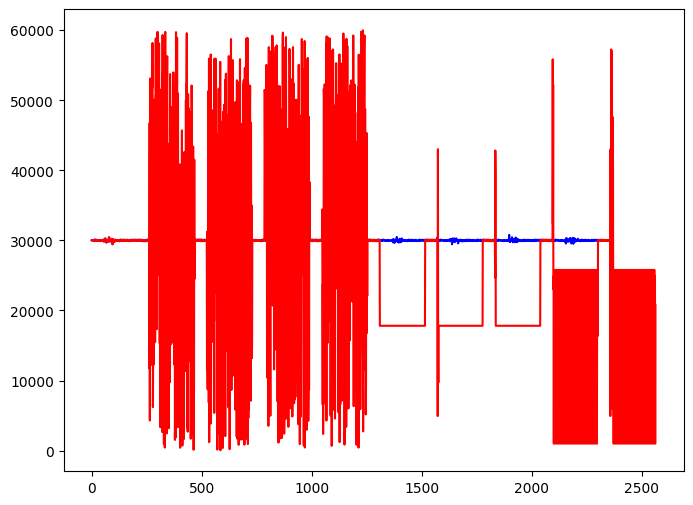

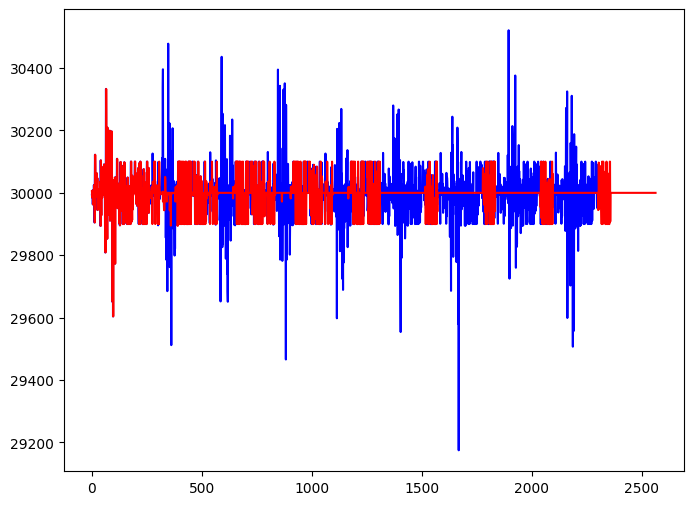

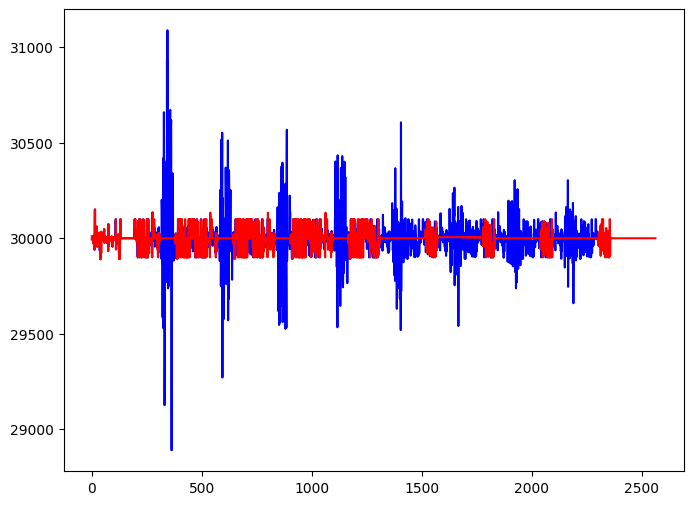

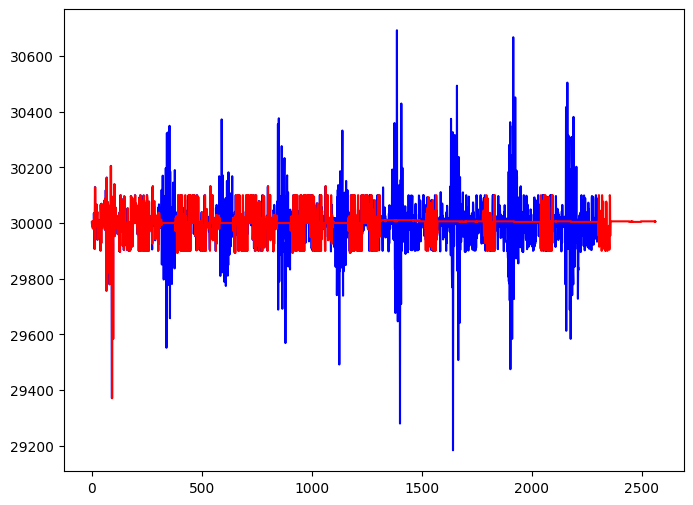

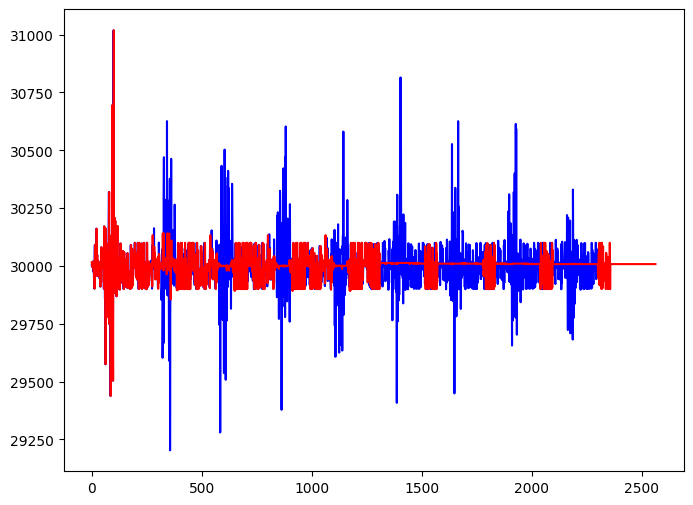

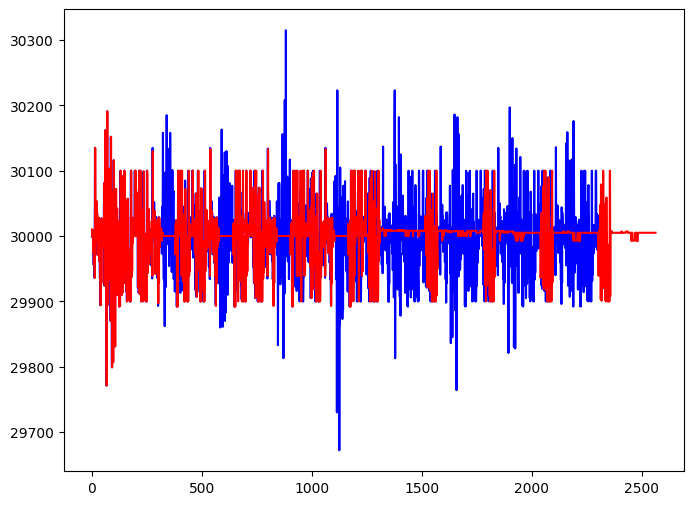

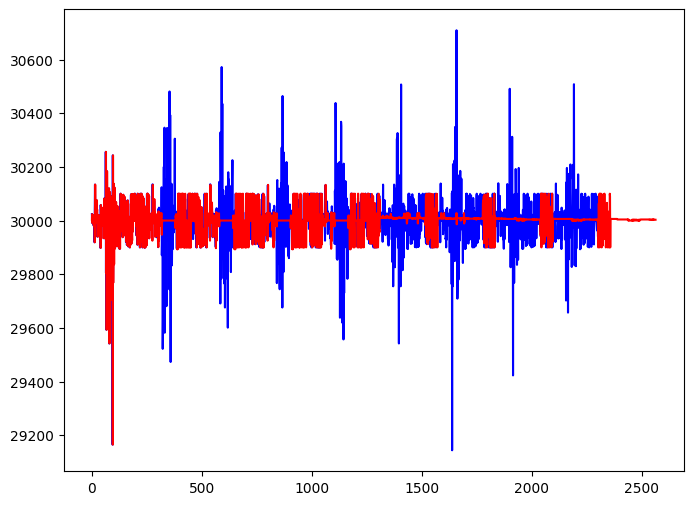

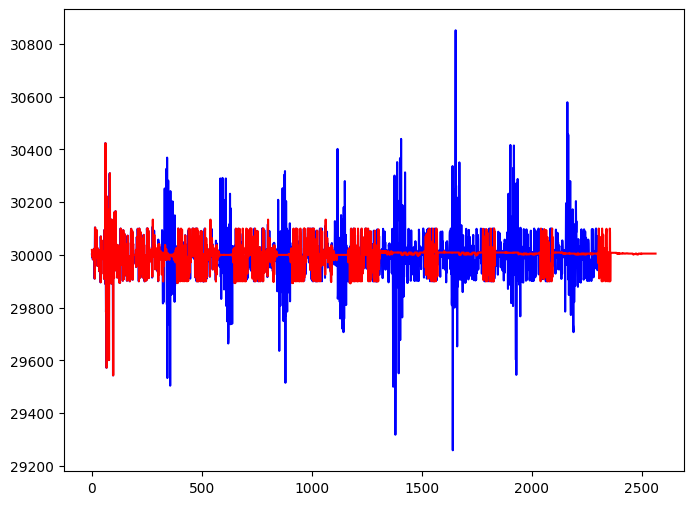

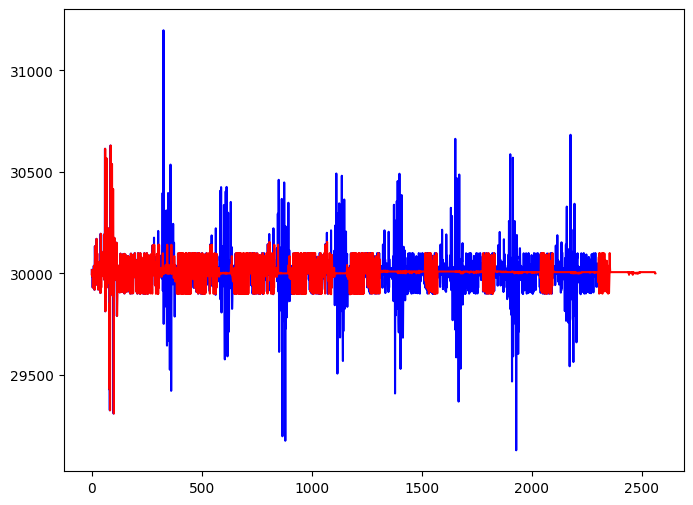

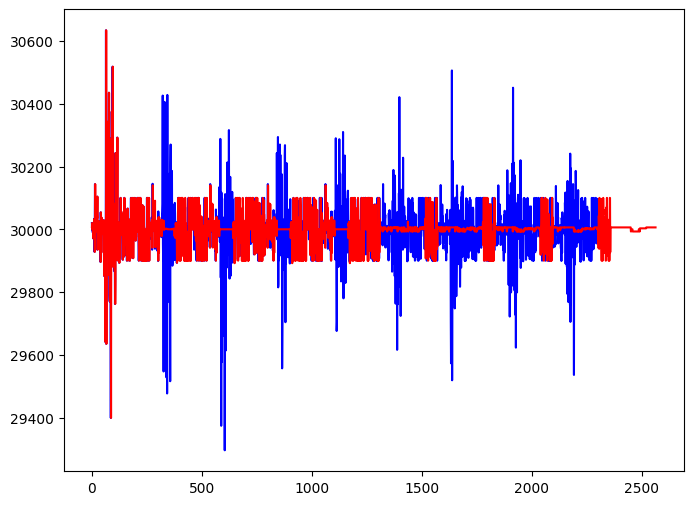

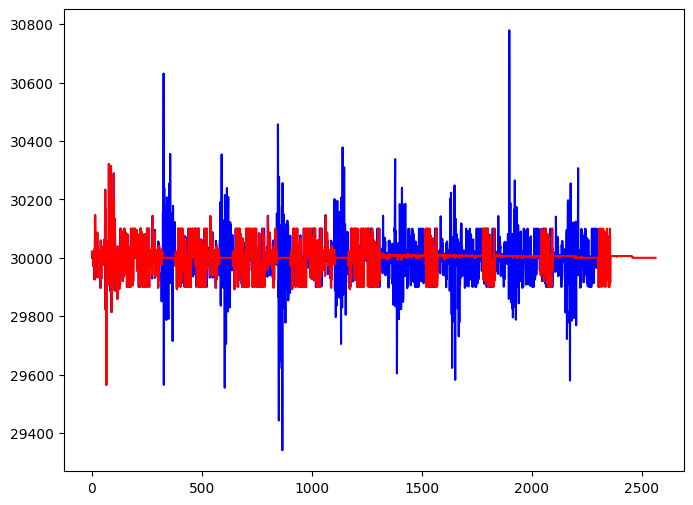

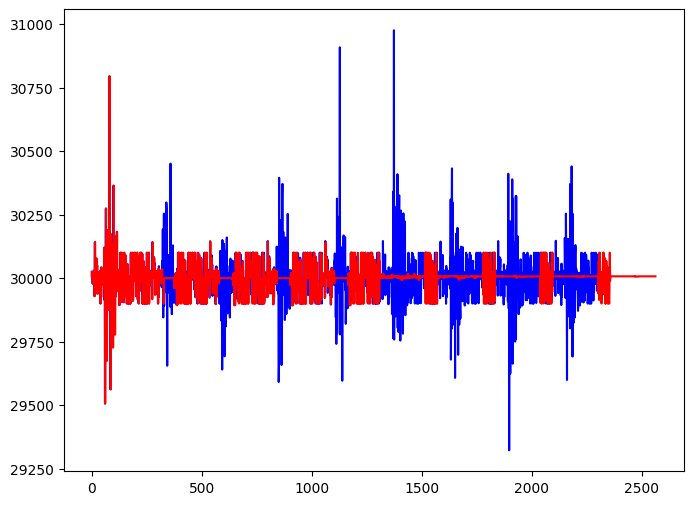

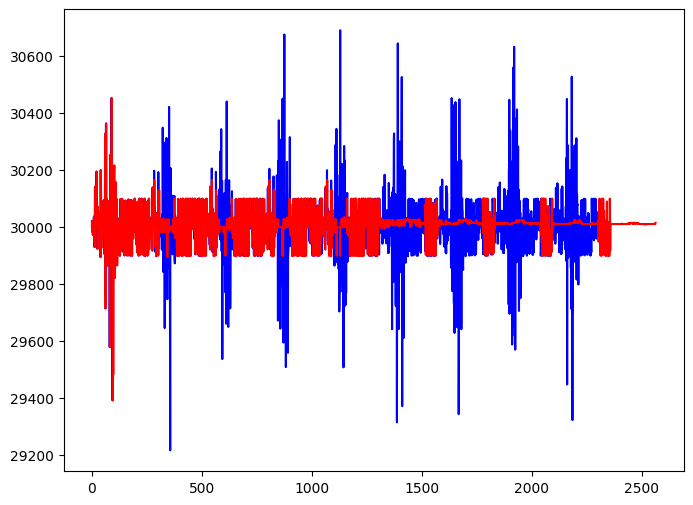

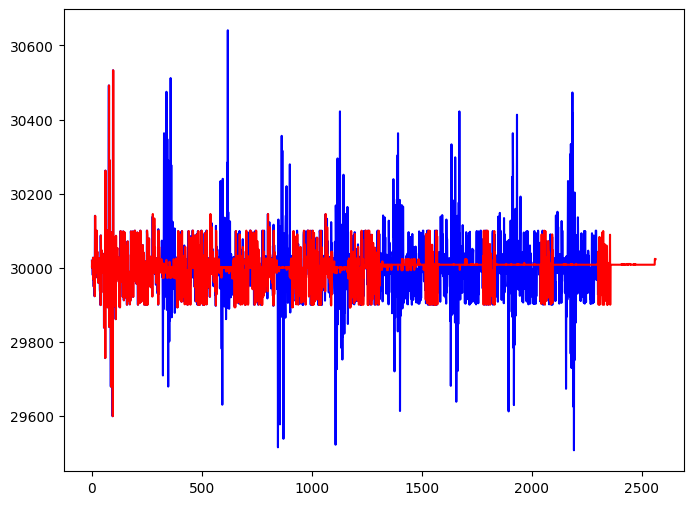

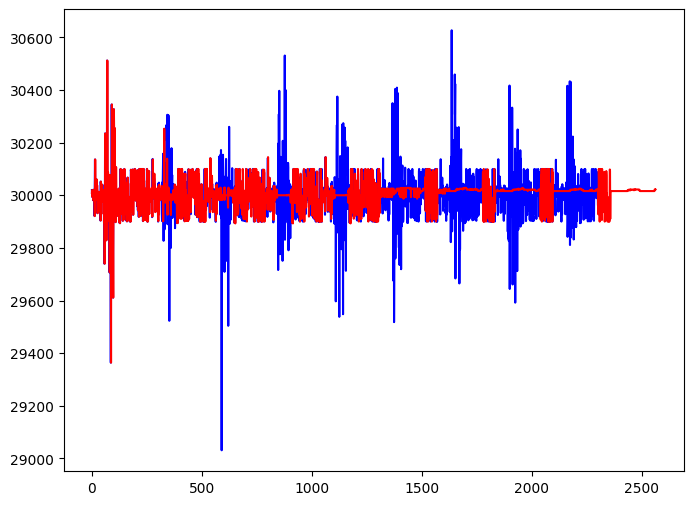

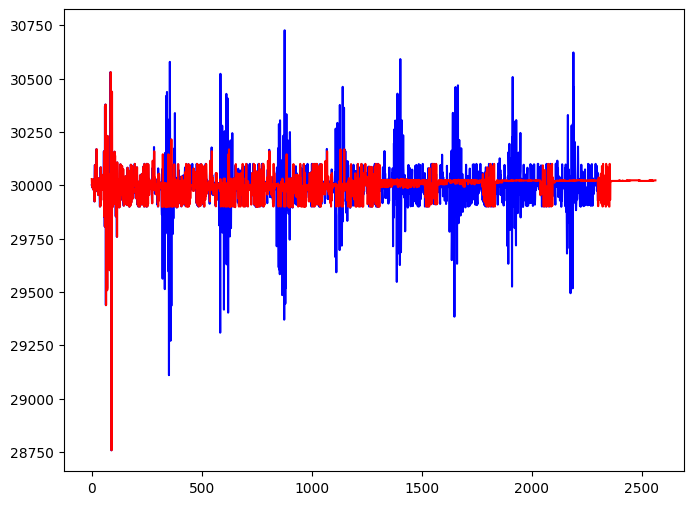

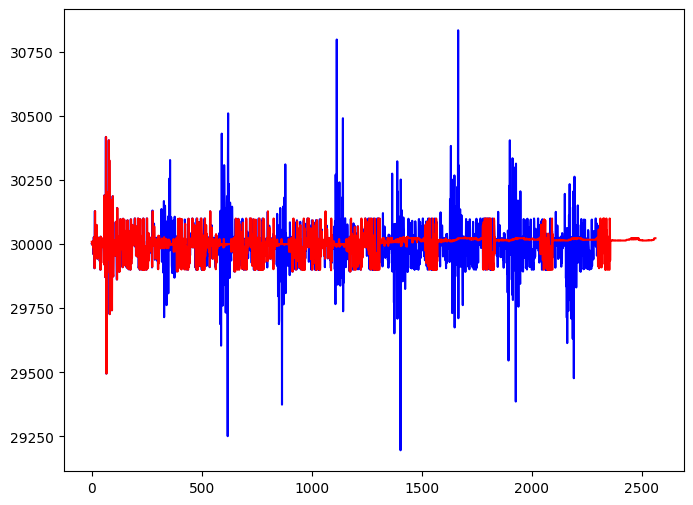

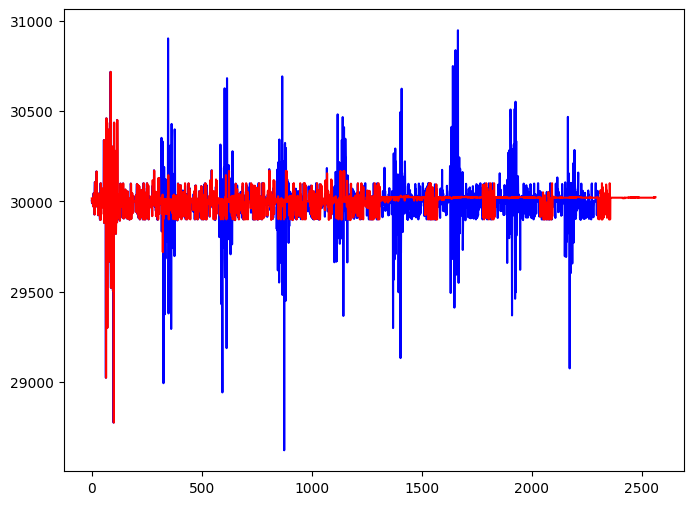

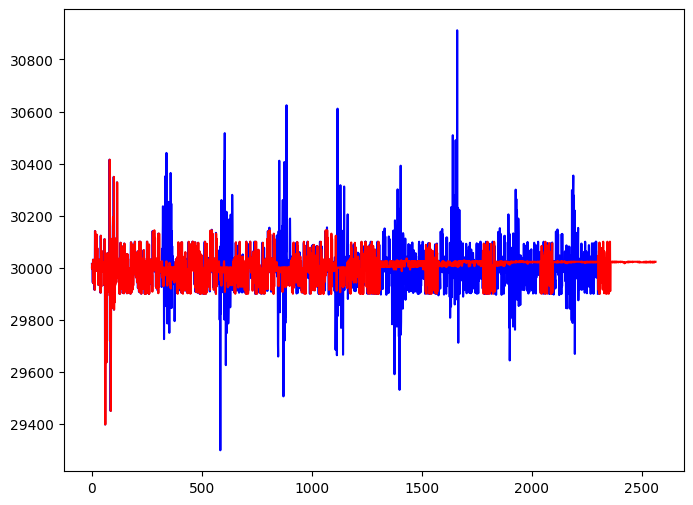

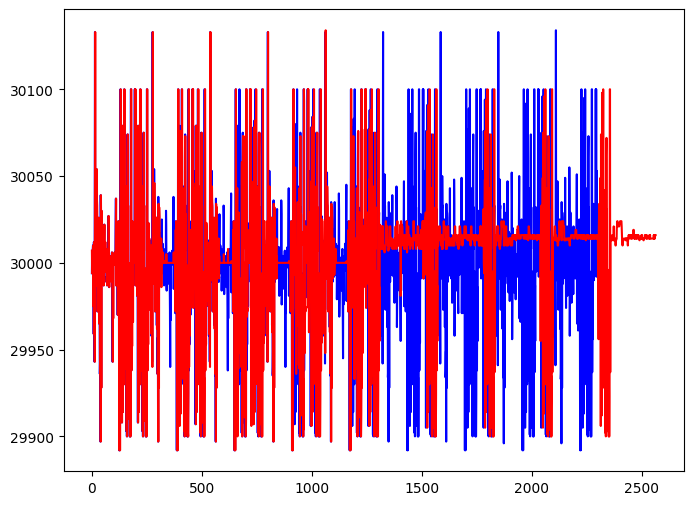

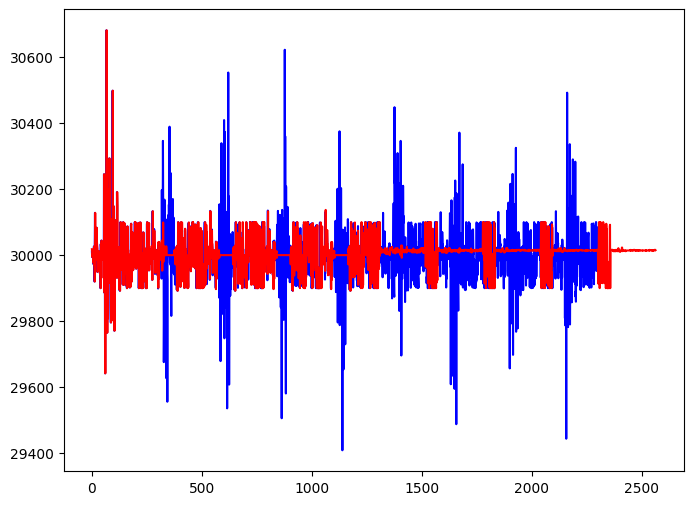

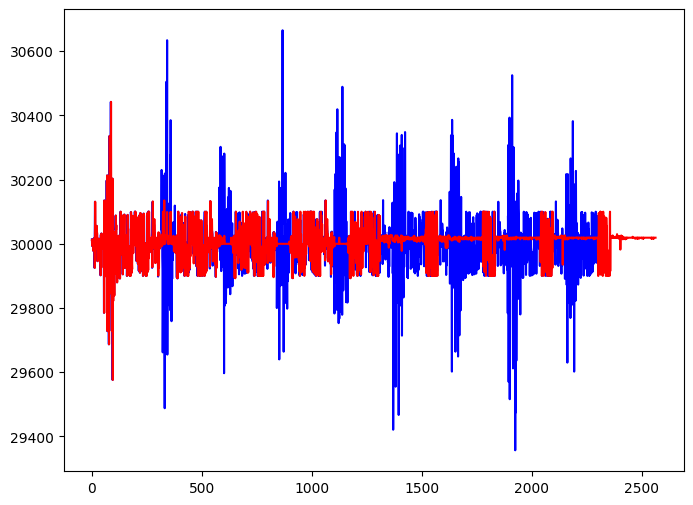

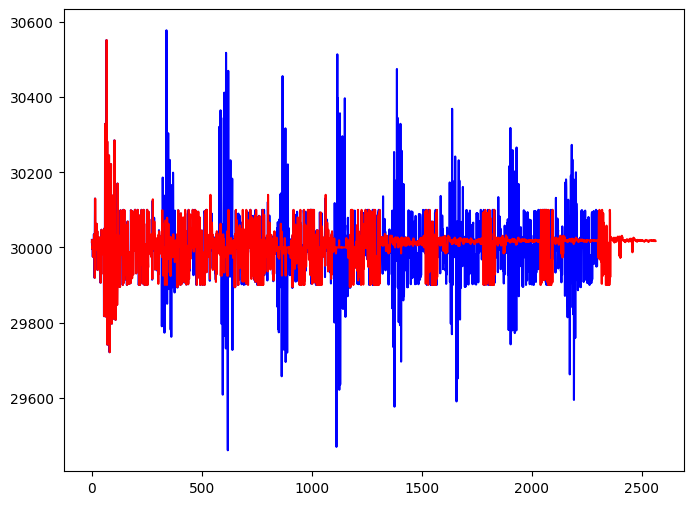

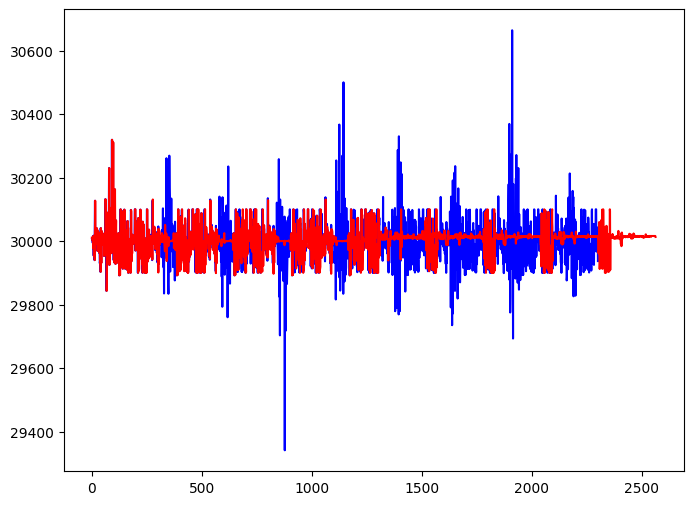

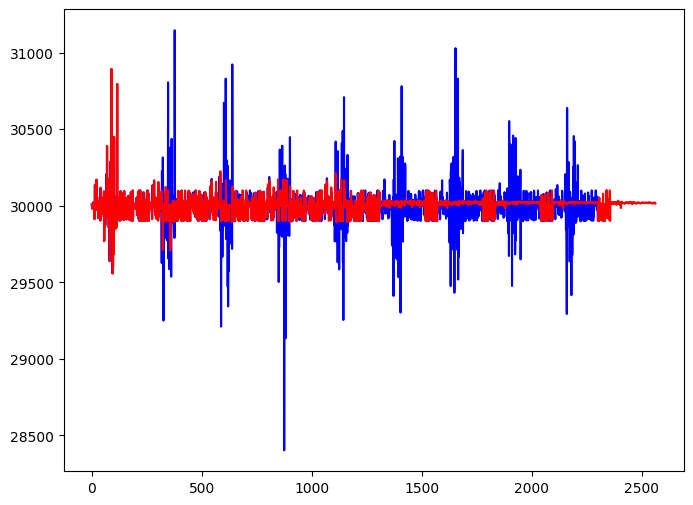

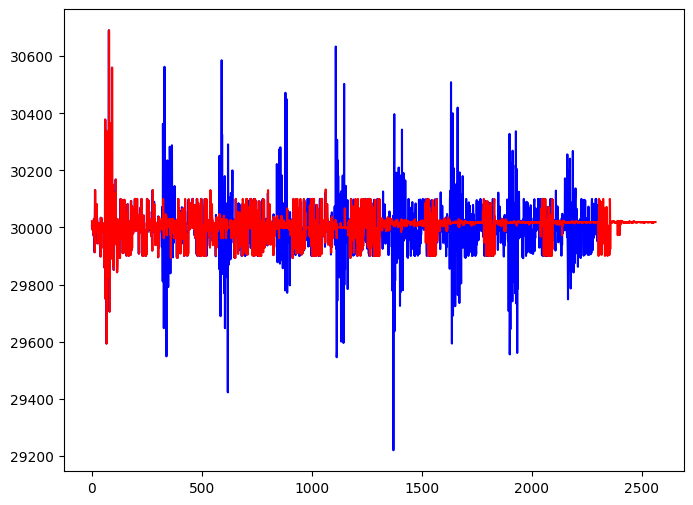

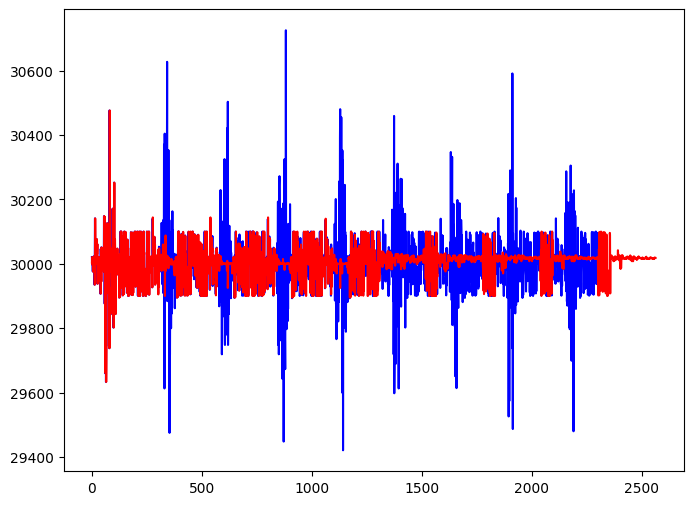

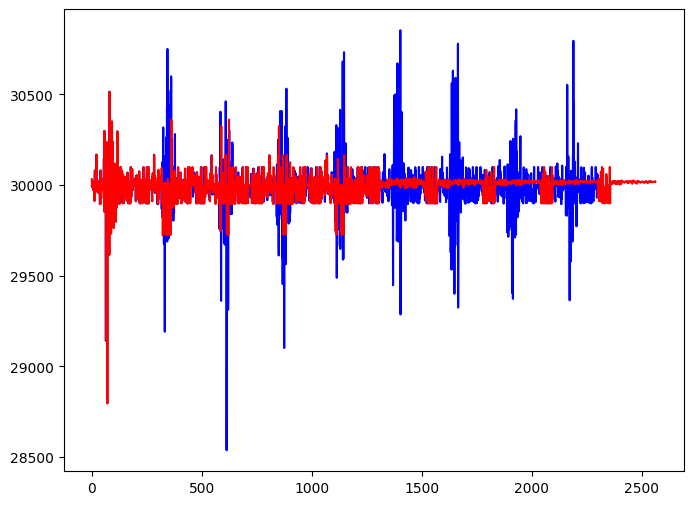

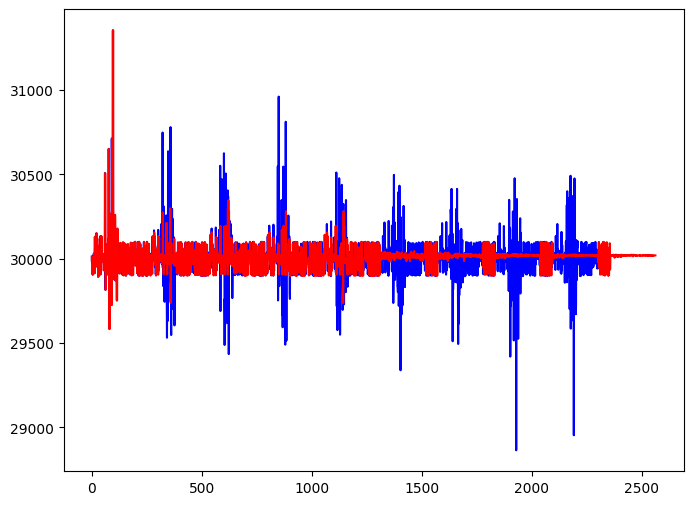

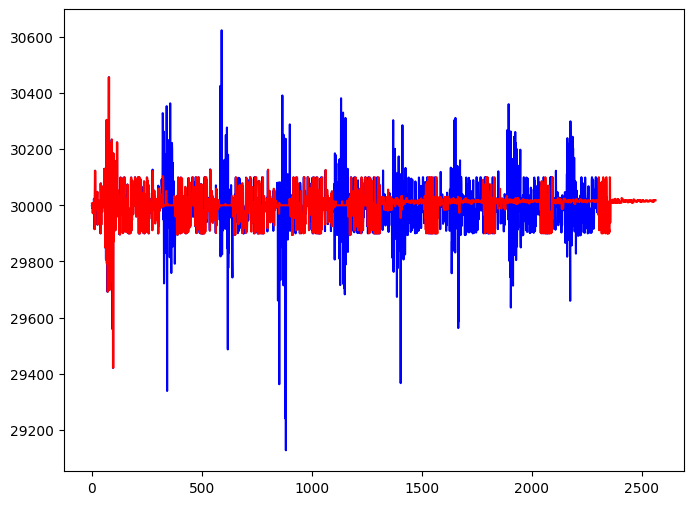

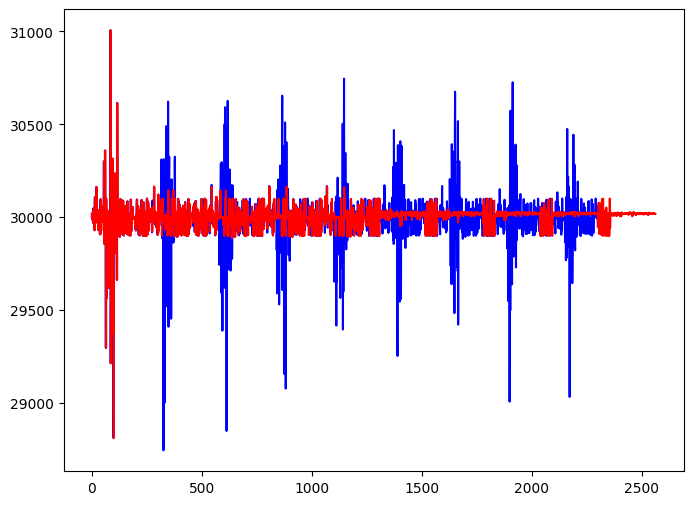

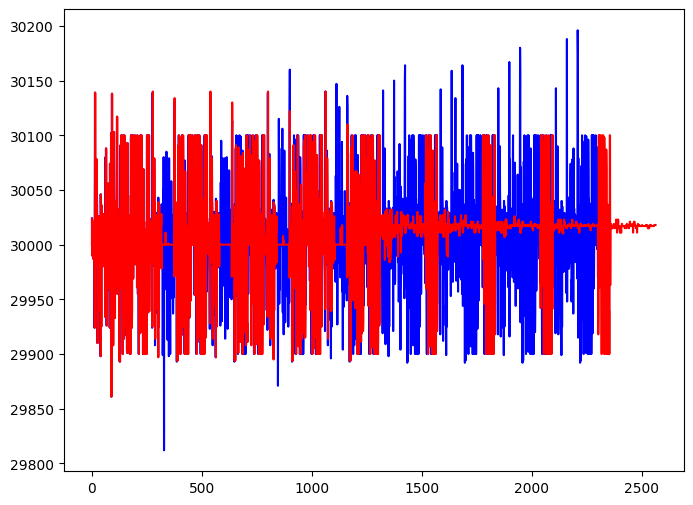

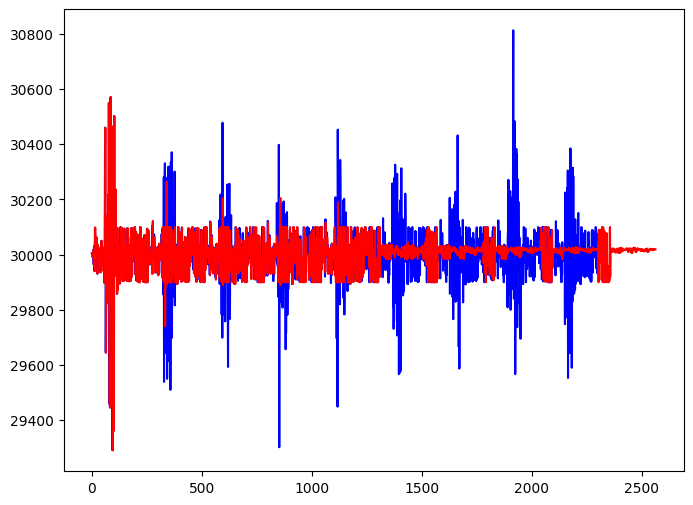

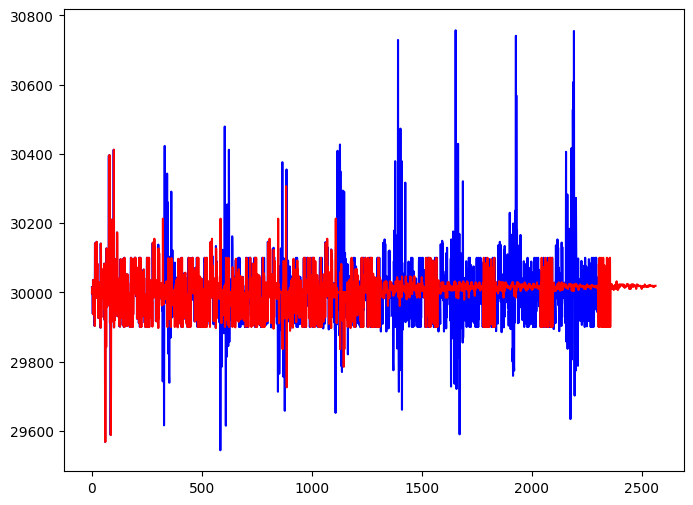

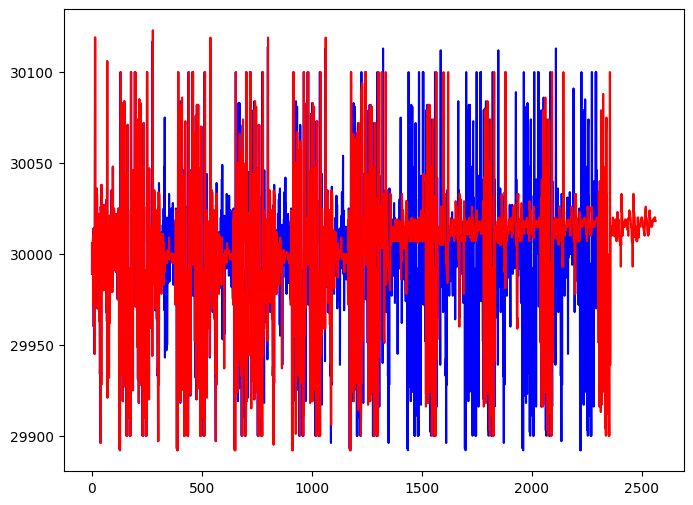

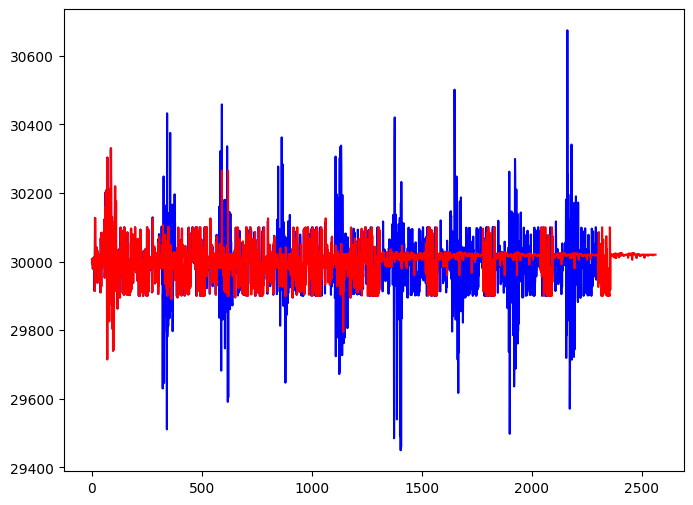

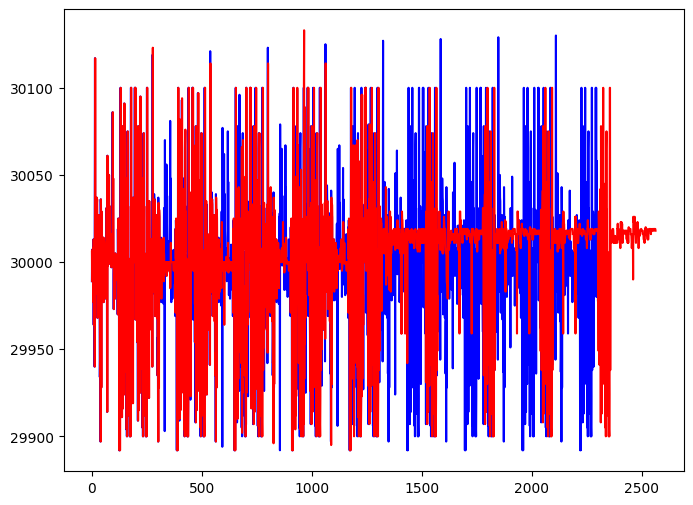

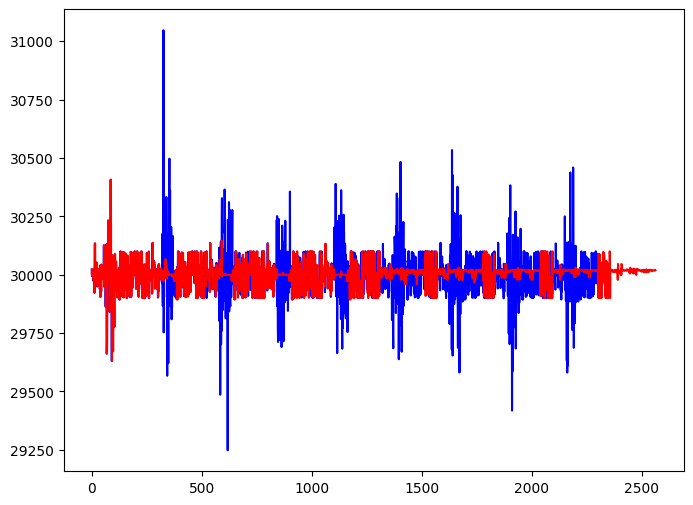

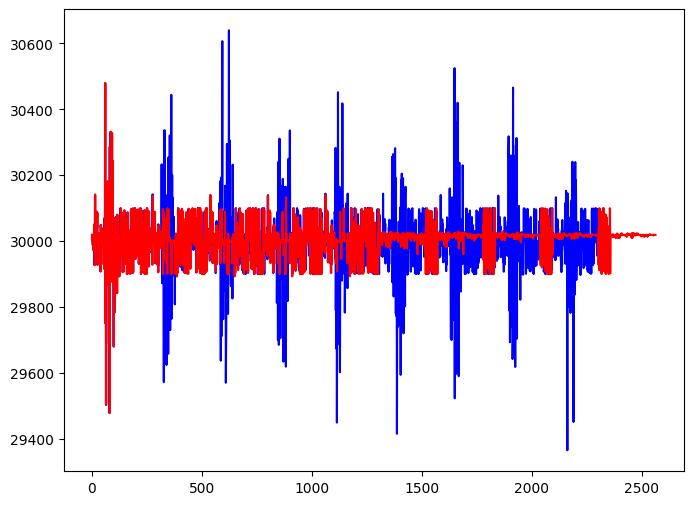

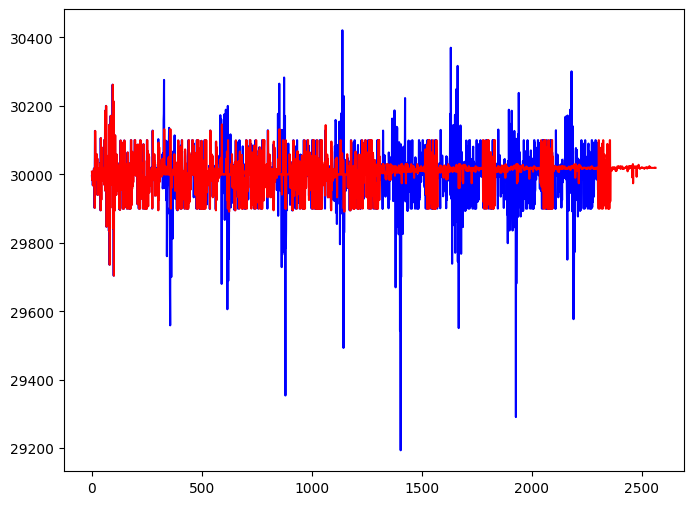

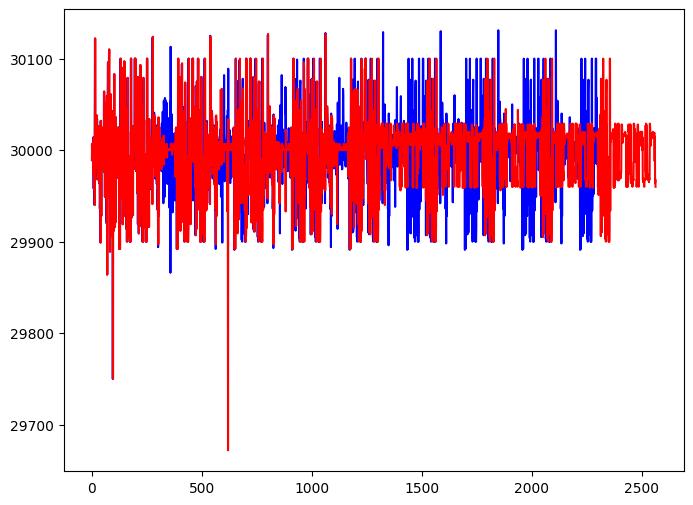

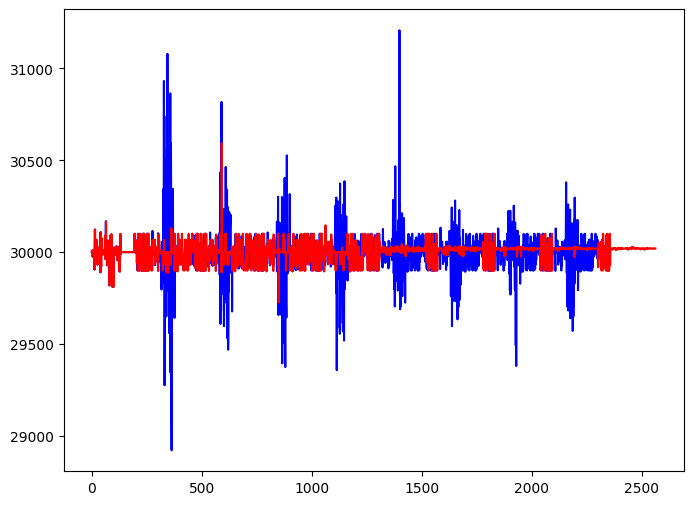

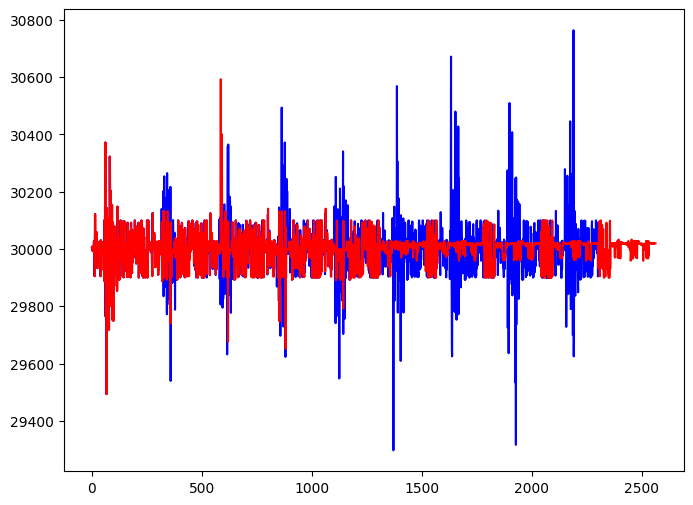

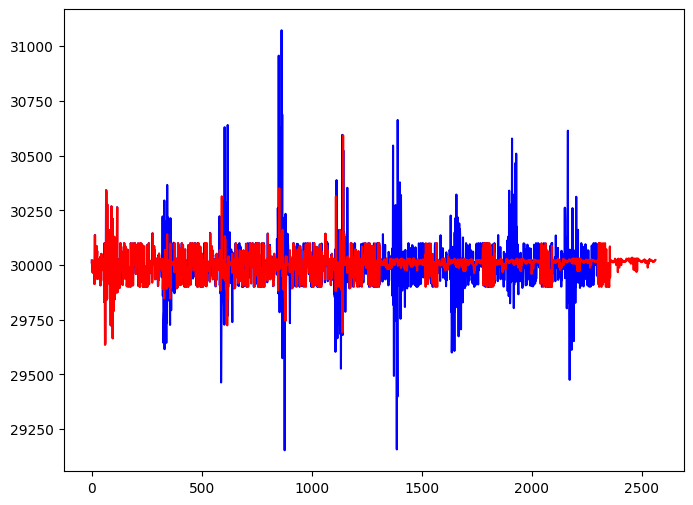

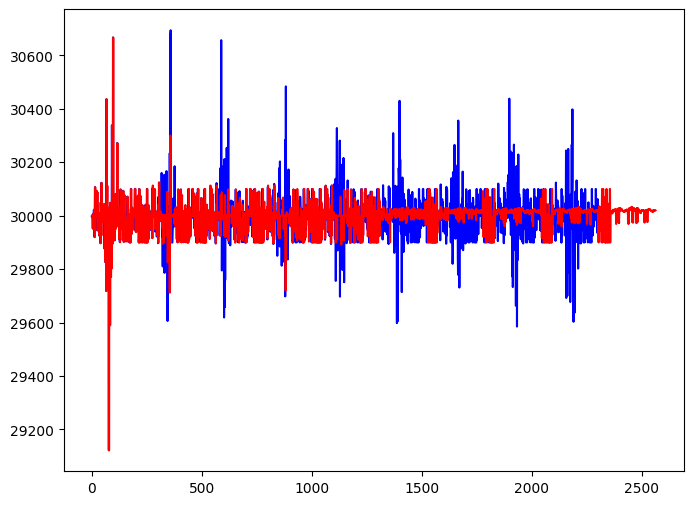

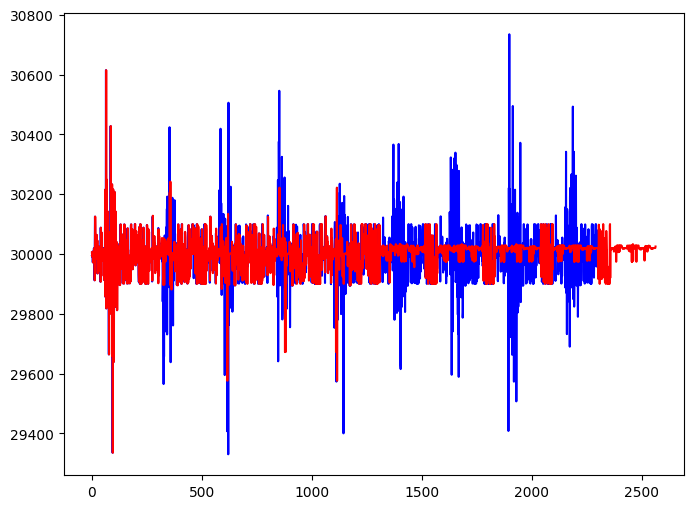

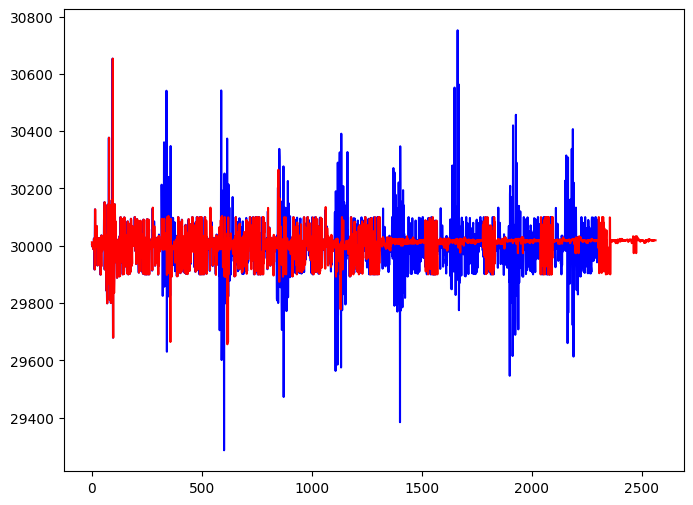

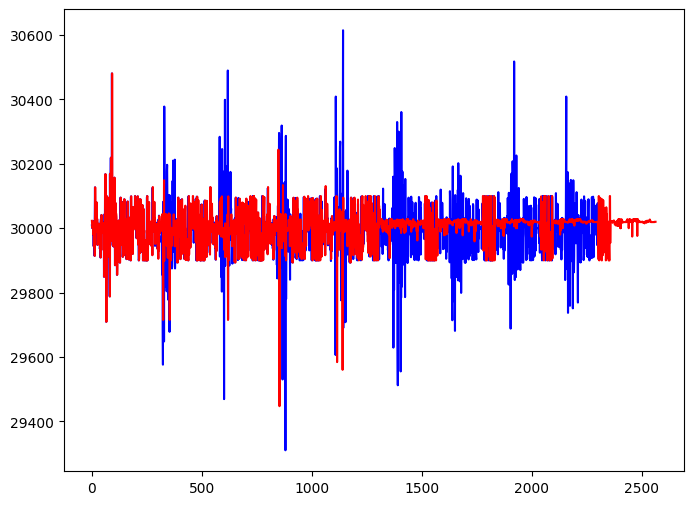

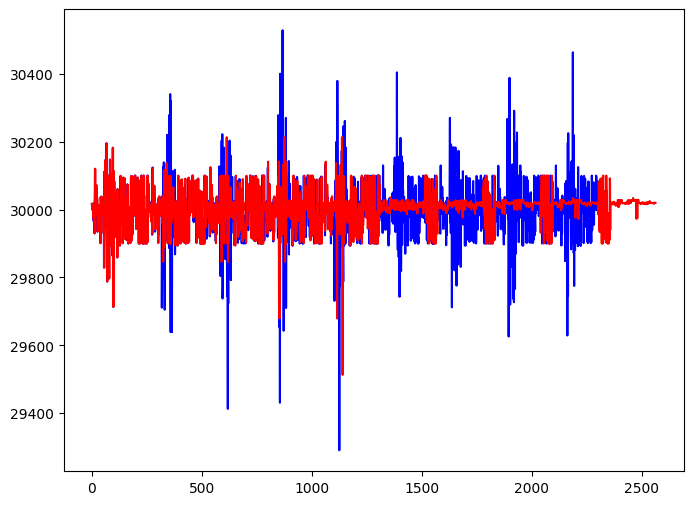

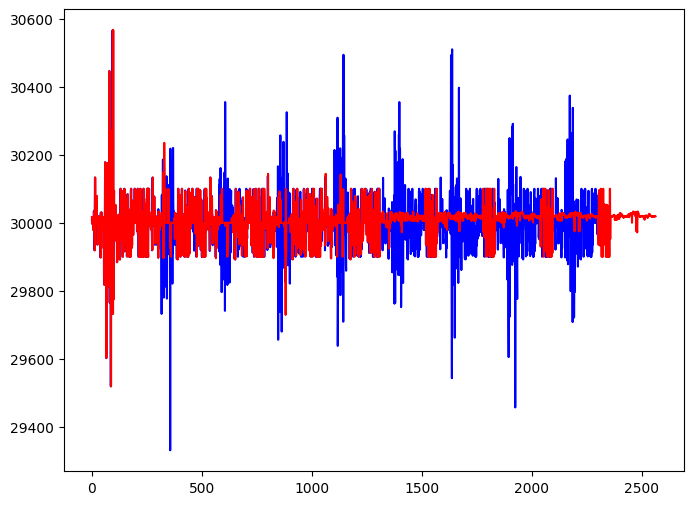

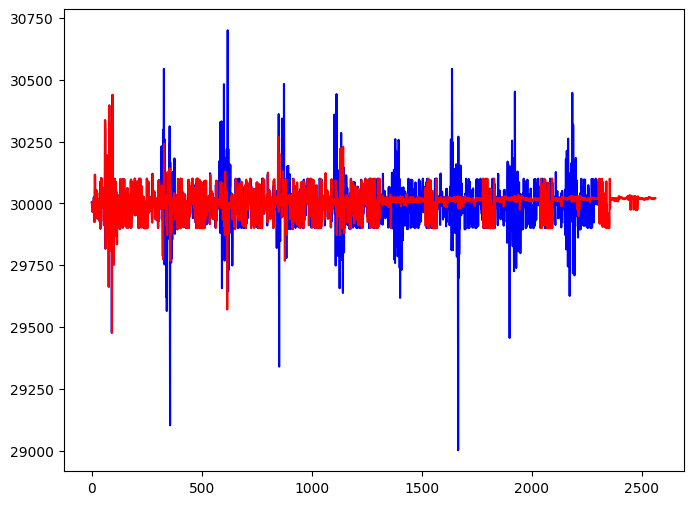

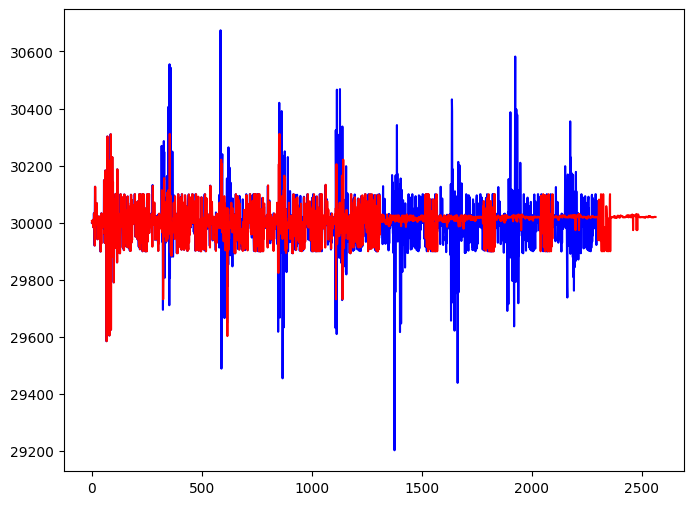

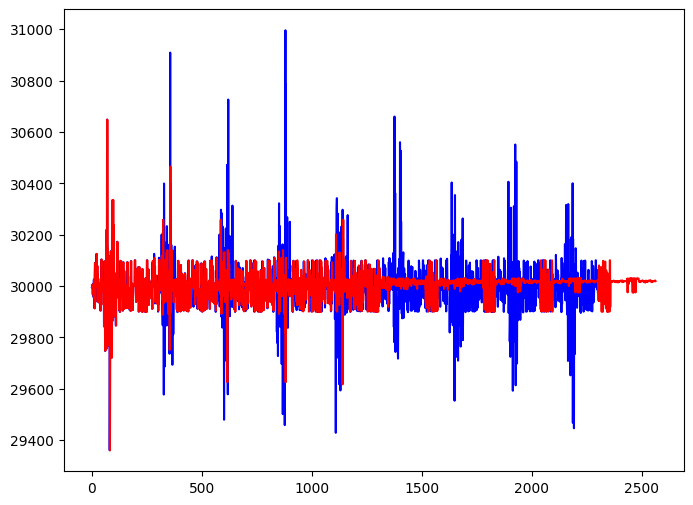

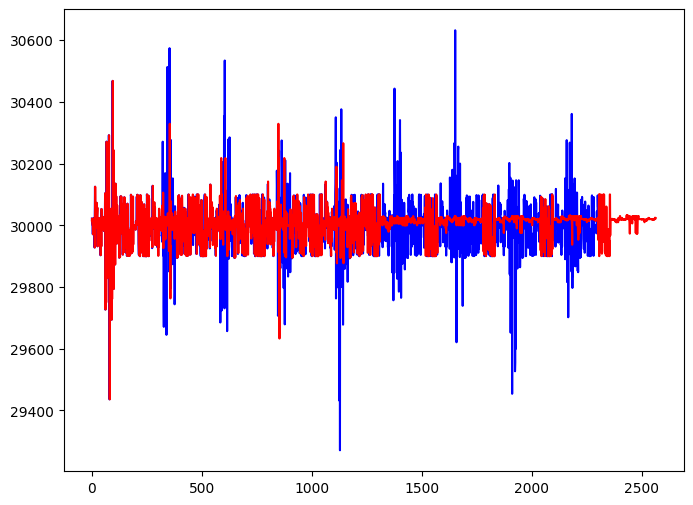

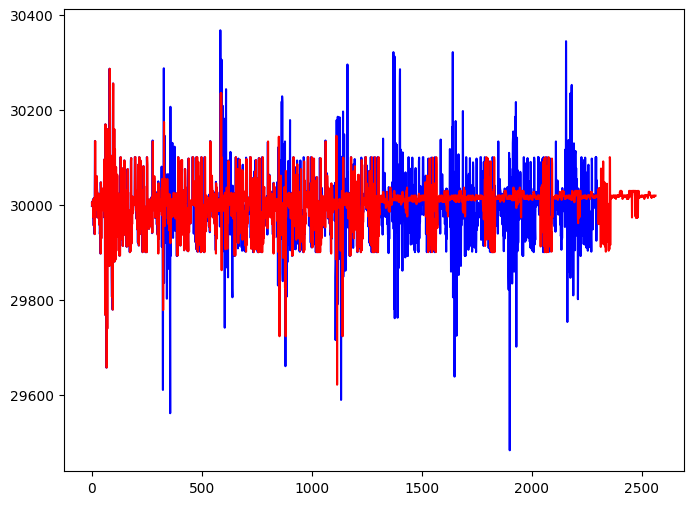

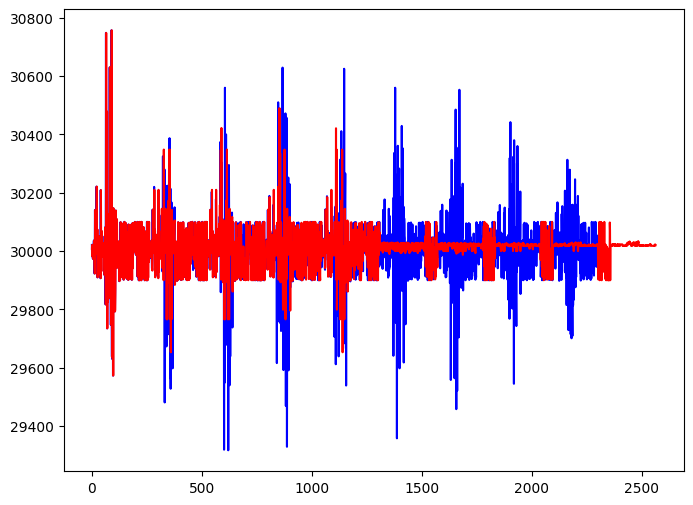

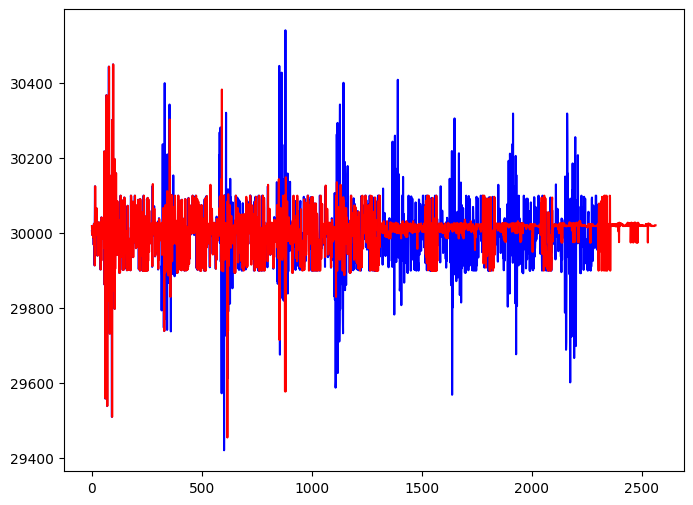

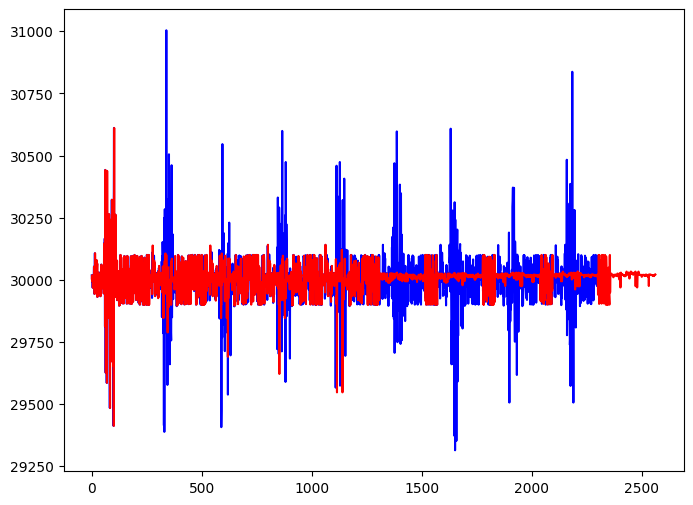

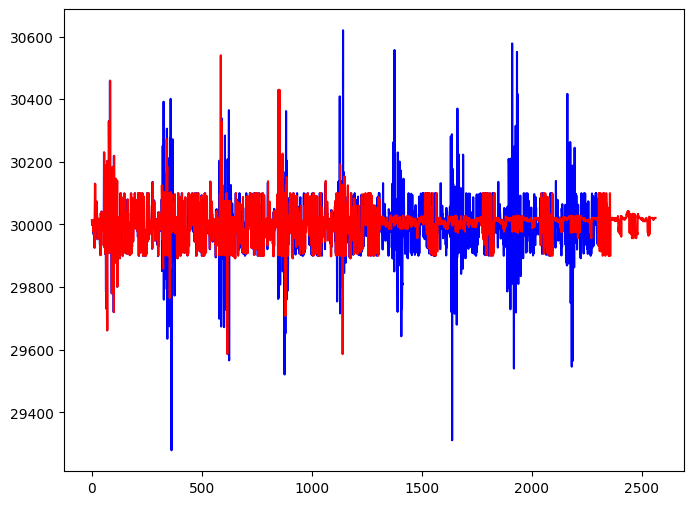

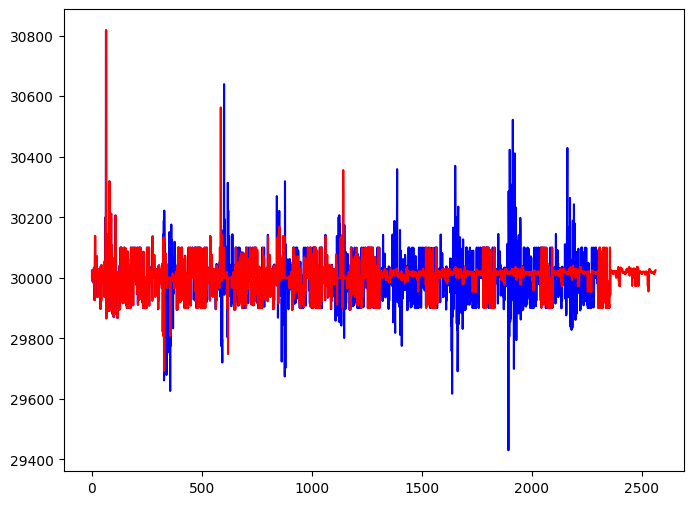

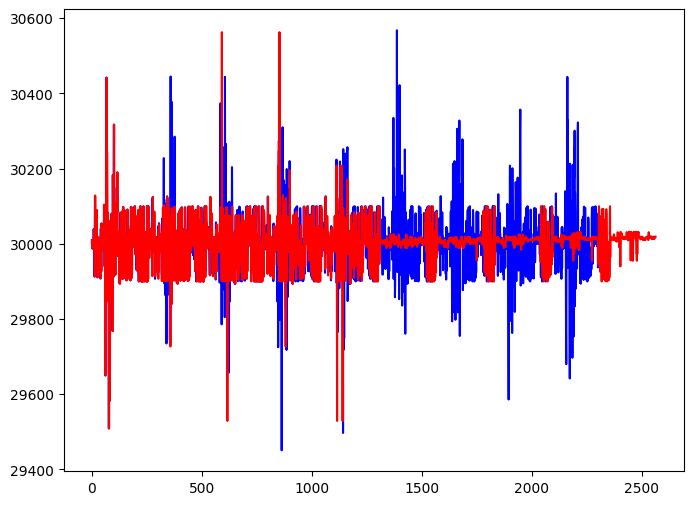

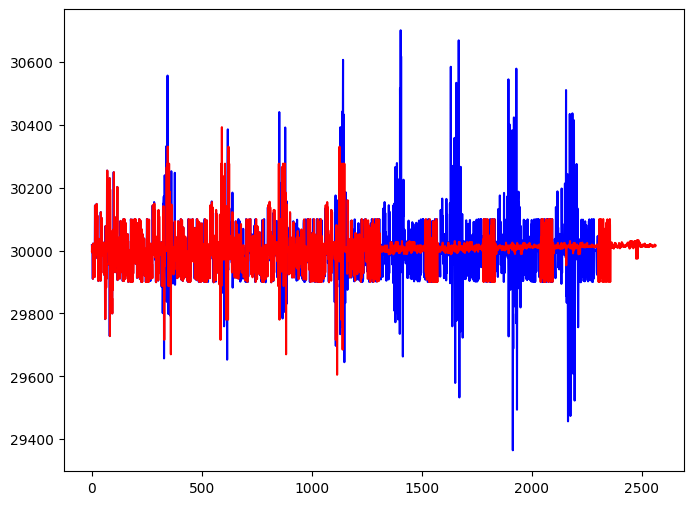

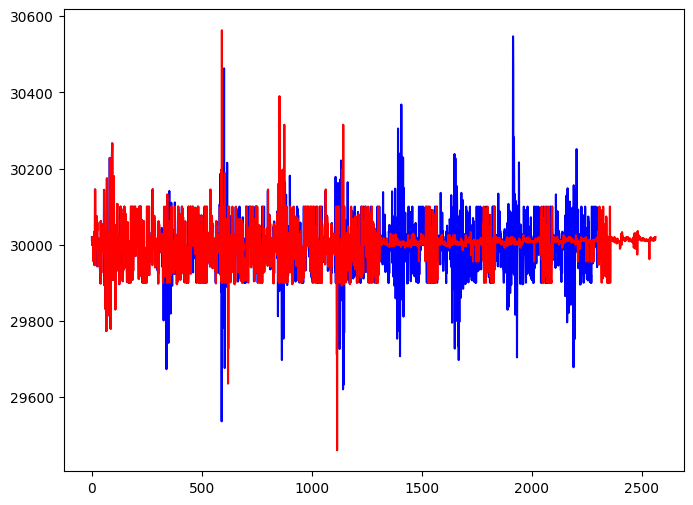

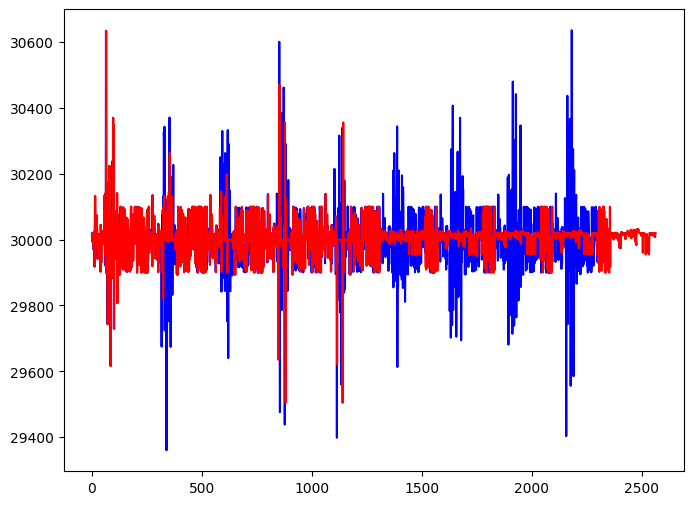

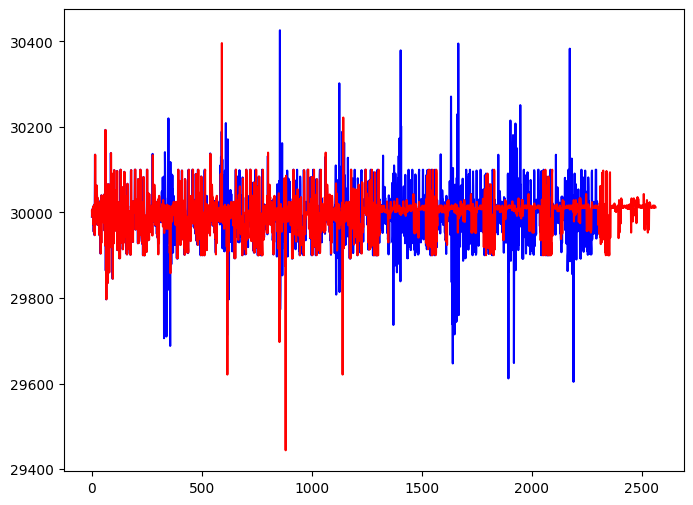

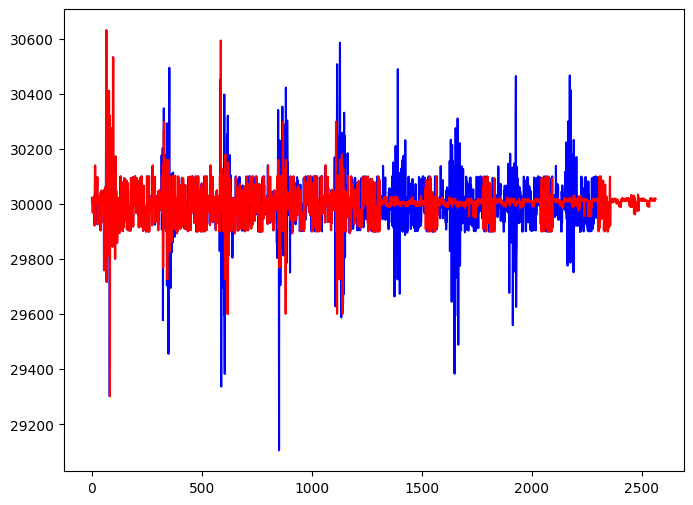

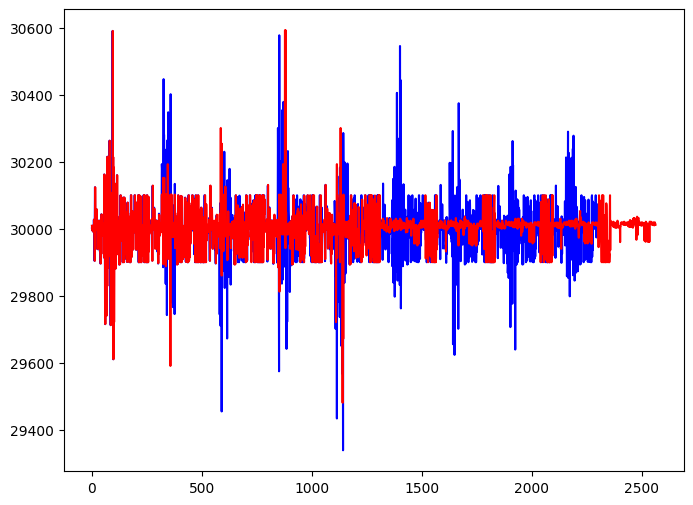

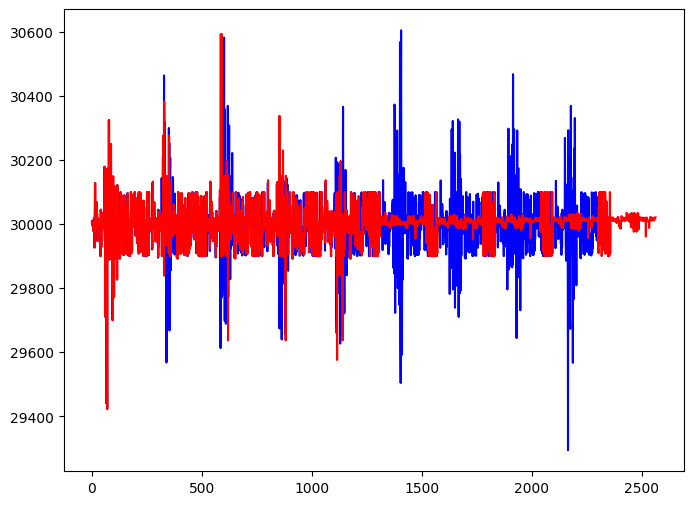

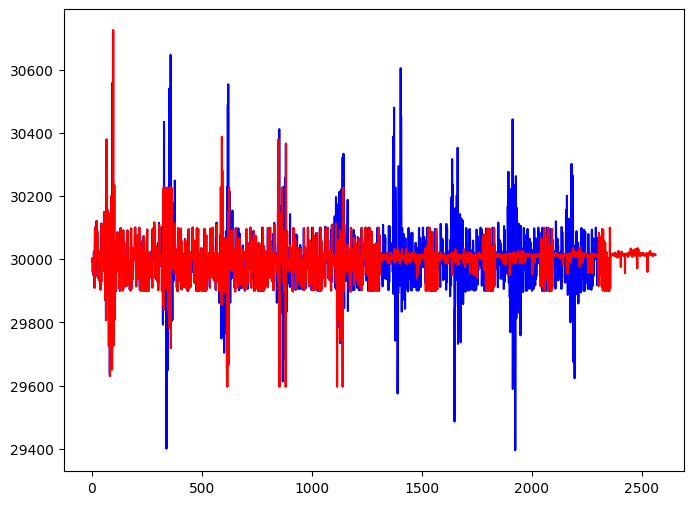

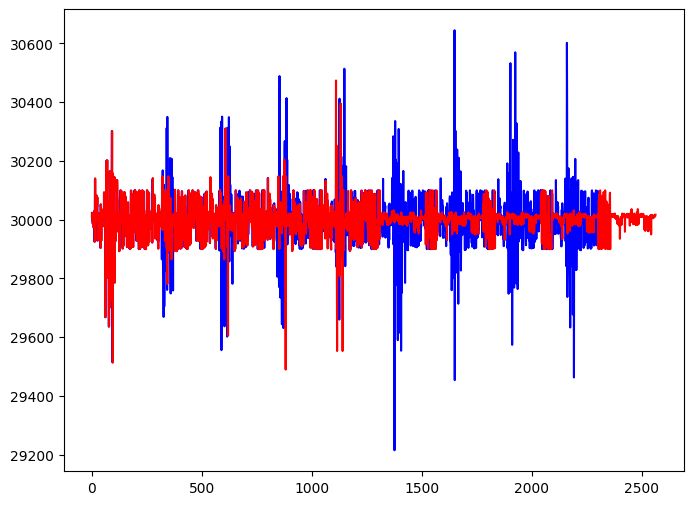

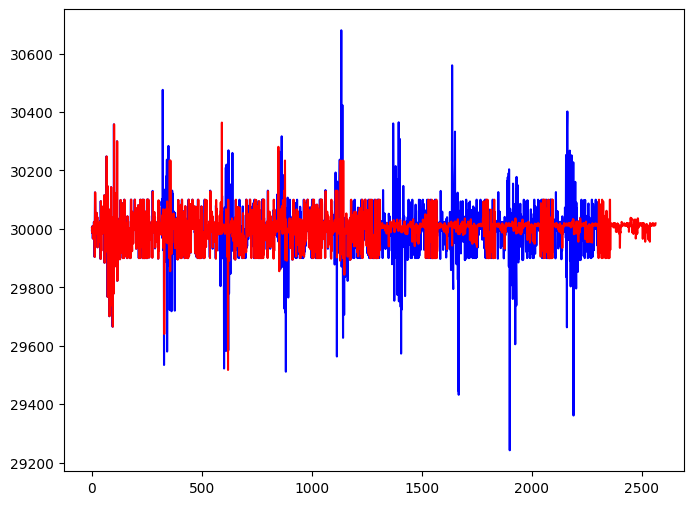

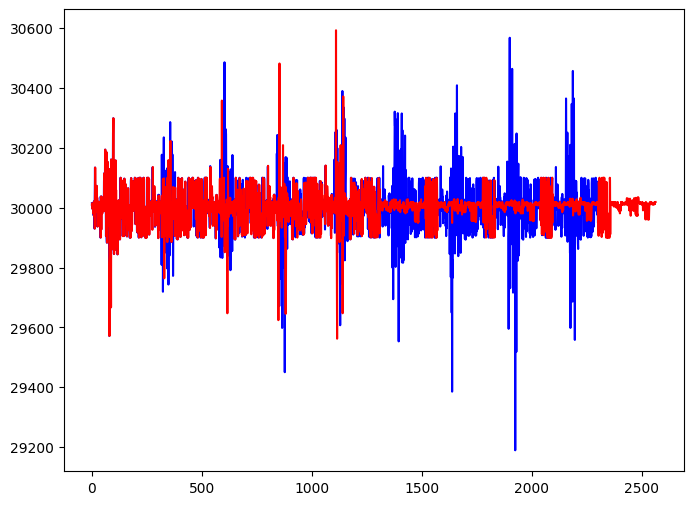

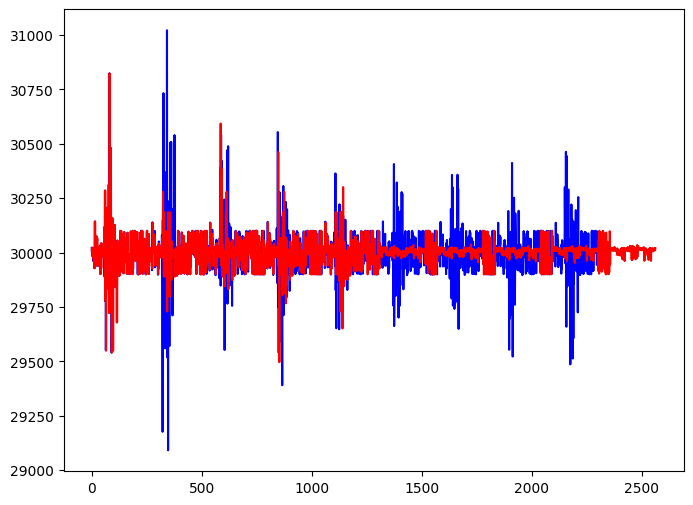

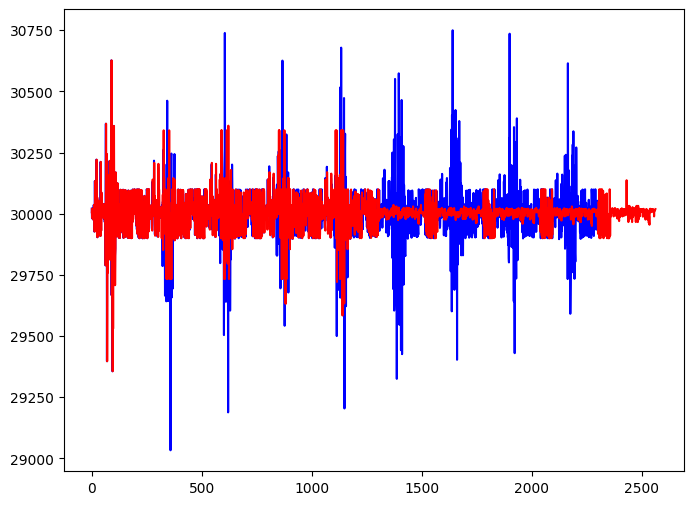

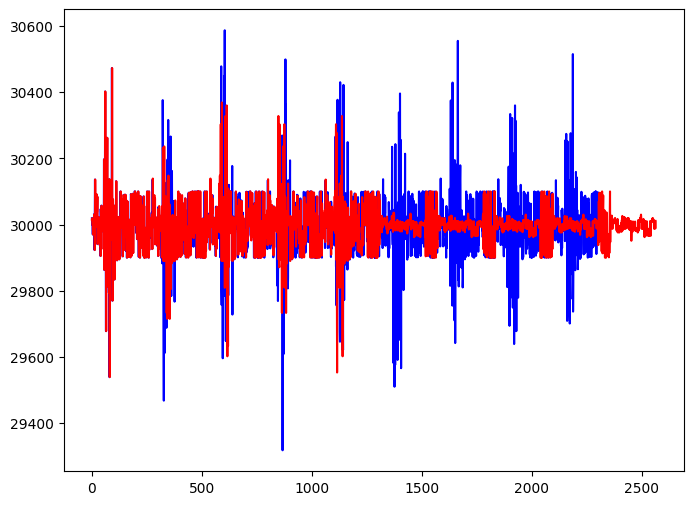

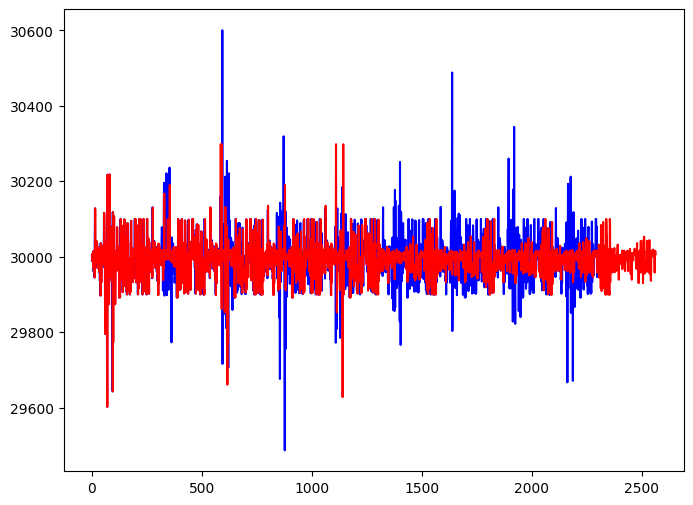

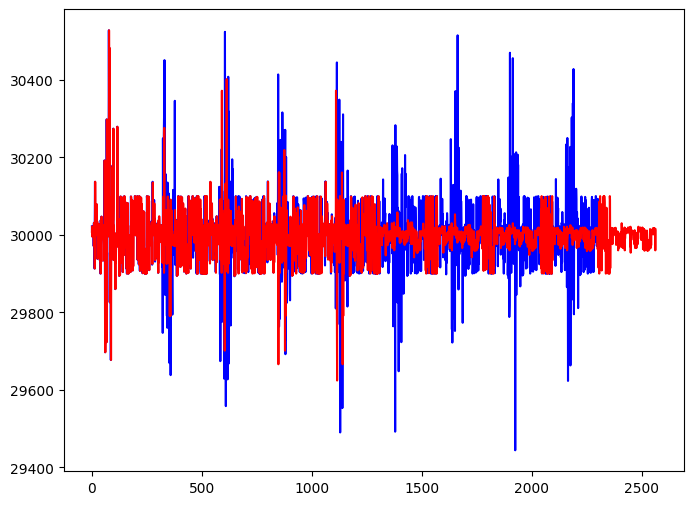

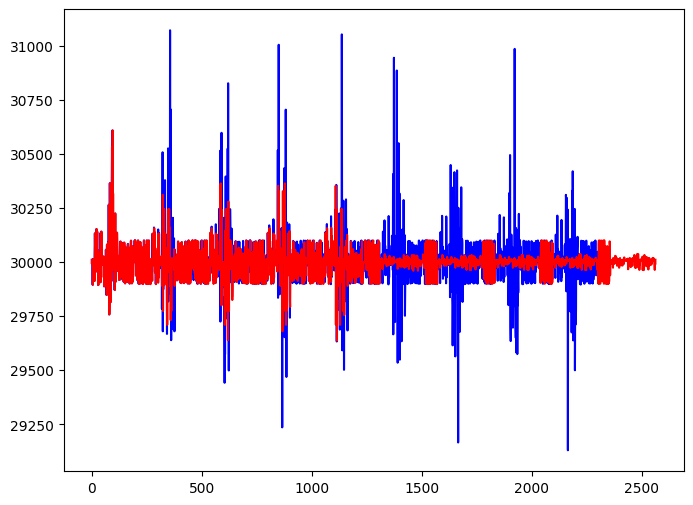

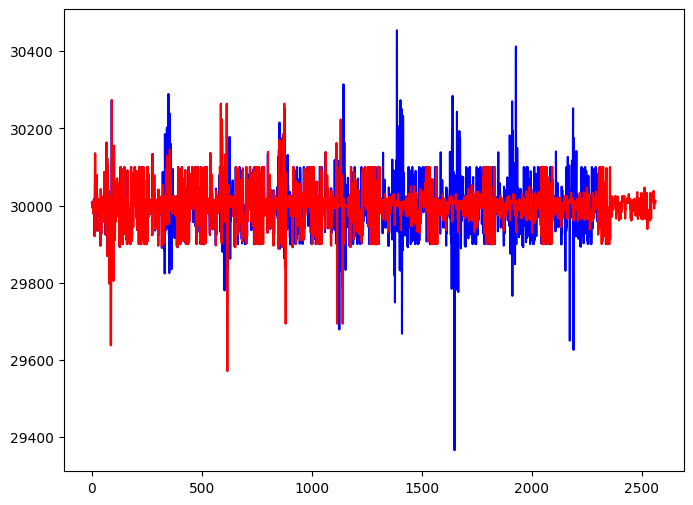

In [ ]:
# get default config and overrides from the command line, if any
config = get_config()
config.trainer.device='cuda'
# config.trainer.num_workers = 0 # windows only
# config.merge_from_args(sys.argv[1:])
setup_logging(config)
set_seed(config.system.seed)

# construct the training dataset
train_actions = 5
test_actions  = 10
test_dataset  = TrajectoryDataset(TrajectoryDataset.get_default_config(test_actions,"/content/drive/MyDrive/train_trajs.pkl"))
train_dataset = TrajectoryDataset(TrajectoryDataset.get_default_config(train_actions,"/content/drive/MyDrive/test_trajs.pkl"))


# construct the model
config.model.vocab_size = train_dataset.get_vocab_size()
config.model.block_size = train_dataset.get_block_size()
print(f'[Train Dataset Size] : {train_dataset.__len__()}')
print(f'[Test Dataset Size] : {test_dataset.__len__()}')
print(config)
model = GPT(config.model)

# construct the trainer object
trainer = Trainer(config.trainer, model, train_dataset)

# make history!
train_loss_history = []

# iteration callback
def batch_end_callback(trainer):

    train_loss_history += [trainer.loss.item()]

    if trainer.iter_num % 10 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")

    if trainer.iter_num % 500 == 0:
        # evaluate both the train and test score
        model.eval()
        with torch.no_grad():
            # sample from the model...
            random_traj  = test_dataset.__getitem__(random.randint(0,test_dataset.__len__()))
            state_action, num_actions = config.data.STATE_DIM+config.data.ACTION_DIM, test_actions-1
            traj_action  = [random_traj[0][i*state_action+config.data.STATE_DIM:(i+1)*state_action] for i in range(num_actions)]
            input_traj = torch.concatenate([random_traj[0][:config.data.STATE_DIM]]+traj_action, dim=0)[None,...].to(trainer.device)
            y_tokenized = model.generate(input_traj, temperature=1.0, do_sample=False, top_k=10, n_actions=num_actions)[0]
            # will use the decoded version inside the predictive sampling controller
            y = train_dataset.decoder(y_tokenized)
            # draw the result plot
            fig, ax = plt.subplots(figsize=(32, 6))
            label = random_traj[0][:(num_actions)*state_action+config.data.STATE_DIM]
            ax.plot(list(range(label.shape[0])), label, color='blue', label='ground truth')
            ax.plot(list(range(y_tokenized.shape[0])), y_tokenized.detach().cpu().numpy(), color='red', label='generated')
            plt.plot()

        # save the latest model
        print("saving model")
        ckpt_path = os.path.join(config.system.work_dir, "model.pt")
        torch.save(model.state_dict(), ckpt_path)
        with open(os.path.join(config.system.work_dir,"train_history.pkl"),"wb") as f:
            pickle.dump(train_loss_history, f)
        # revert model to training mode
        model.train()

trainer.set_callback('on_batch_end', batch_end_callback)

# run the optimization
trainer.run()